## UHI INTENSITY

These variables describe the location of a place and the environmental and urban characteristics around it, which are useful for studying Urban Heat Island (UHI) effects.

Longitude and Latitude give the exact geographic position of a place on the Earth. They are simply coordinates that tell us where each location is.

UHI_Class represents the Urban Heat Island category for that location. It shows how hot or cool an area is compared to its surroundings and is usually used as the target variable when building a prediction model.

median_NDVI measures how green the area is. It comes from satellite images and indicates the amount of vegetation. Higher values mean more trees and plants, while lower values mean little or no greenery.

median_NDBI measures how built-up the area is. It also comes from satellite data and reflects the presence of buildings, roads, and other concrete surfaces. Higher values mean the area is more urbanized.

median_NDWI measures how much surface water or moisture is present, such as rivers, lakes, or wet ground. Higher values mean more water or moisture in the area.

building_density_100m shows how crowded the area is with buildings within a 100-meter radius. A higher value means there are more buildings packed into a small space.

Short Summary

Together, these variables describe where a place is, how hot it is, how green it is, how built-up it is, how wet it is, and how crowded it is with buildings.
They help explain why some parts of a city are hotter than others and are commonly used to model and predict urban heat patterns.

## IMPORTATION OF LIBARIES

In [1]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization libraries
import matplotlib.pyplot as plt
from matplotlib.cm import RdYlGn,jet,RdBu
import seaborn as sns
sns.set()
sns.set(style="darkgrid")
plt.rcParams['figure.figsize']=(10,10)

# Data manipulation and analysis
import numpy as np
import pandas as pd

# Multi-dimensional arrays and datasets (e.g., NetCDF, Zarr)
import xarray as xr

# Geospatial raster data handling with CRS support
import rioxarray as rxr

# Geospatial vector data handling (e.g., shapefiles, GeoJSON)
import geopandas as gpd
from shapely.geometry import box, Point

# Coordinate transformations
from pyproj import Proj, Transformer, CRS

# Raster operations and spatial windowing
import rasterio
from rasterio.windows import from_bounds

# Feature preprocessing and data splitting
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Machine learning model and evaluation metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report

# Planetary Computer tools for STAC API access and authentication
import pystac_client
import planetary_computer as pc
from pystac.extensions.eo import EOExtension as eo

# Progress bar for loops
from tqdm import tqdm

# Date/time handling
from datetime import date

In [2]:
# Planetary Computer and STAC tools
import pystac_client
import planetary_computer
import odc
from odc.stac import stac_load


In [3]:
# reading the csv file 
chile_heat_df=pd.read_csv('sample_chile_uhi_data.csv')
chile_heat_df.head()

Longitude   Latitude UHI_Class
0 -70.580508 -33.586980       Low
1 -70.579480 -33.592099       Low
2 -70.578366 -33.597419    Medium
3 -70.566661 -33.597109       Low
4 -70.566296 -33.597079    Medium

In [4]:
# reading the csv file
Brazil_heat_df=pd.read_csv('sample_Brazil_uhi_data.csv')
Brazil_heat_df.head()

Longitude   Latitude UHI_Class
0 -43.278320 -22.901192    Medium
1 -43.278298 -22.901215    Medium
2 -43.278277 -22.901235    Medium
3 -43.278218 -22.901298    Medium
4 -43.278185 -22.901335    Medium

In [5]:
# visualize the bands of the downloaded GeoTIFF images.
def plot_spectral_indices(tiff_path, location_name="Location"):
    """
    Reads and plots NDVI, NDBI, and NDWI bands from a GeoTIFF file.
    
    Parameters:
    - tiff_path (str): Path to the GeoTIFF file.
    - location_name (str): Name of the location to be shown in the plot title.
    """
    with rasterio.open(tiff_path) as src:
        NDVI = src.read(1)  # Band 1: NDVI
        NDBI = src.read(2)  # Band 2: NDBI
        NDWI = src.read(3)  # Band 3: NDWI

    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    axes = axes.flatten()
    fig.suptitle(f"{location_name} - Spectral Indices", fontsize=16, color='darkblue', y=1.05)

    # NDVI plot
    im1 = axes[0].imshow(NDVI, cmap='viridis')
    axes[0].set_title('NDVI')
    fig.colorbar(im1, ax=axes[0])

    # NDBI plot
    im2 = axes[1].imshow(NDBI, cmap='viridis')
    axes[1].set_title('NDBI')
    fig.colorbar(im2, ax=axes[1])

    # NDWI plot
    im3 = axes[2].imshow(NDWI, cmap='viridis')
    axes[2].set_title('NDWI')
    fig.colorbar(im3, ax=axes[2])

    # Empty plot slot (optional)
    axes[3].axis('off')

    plt.tight_layout()
    plt.show()

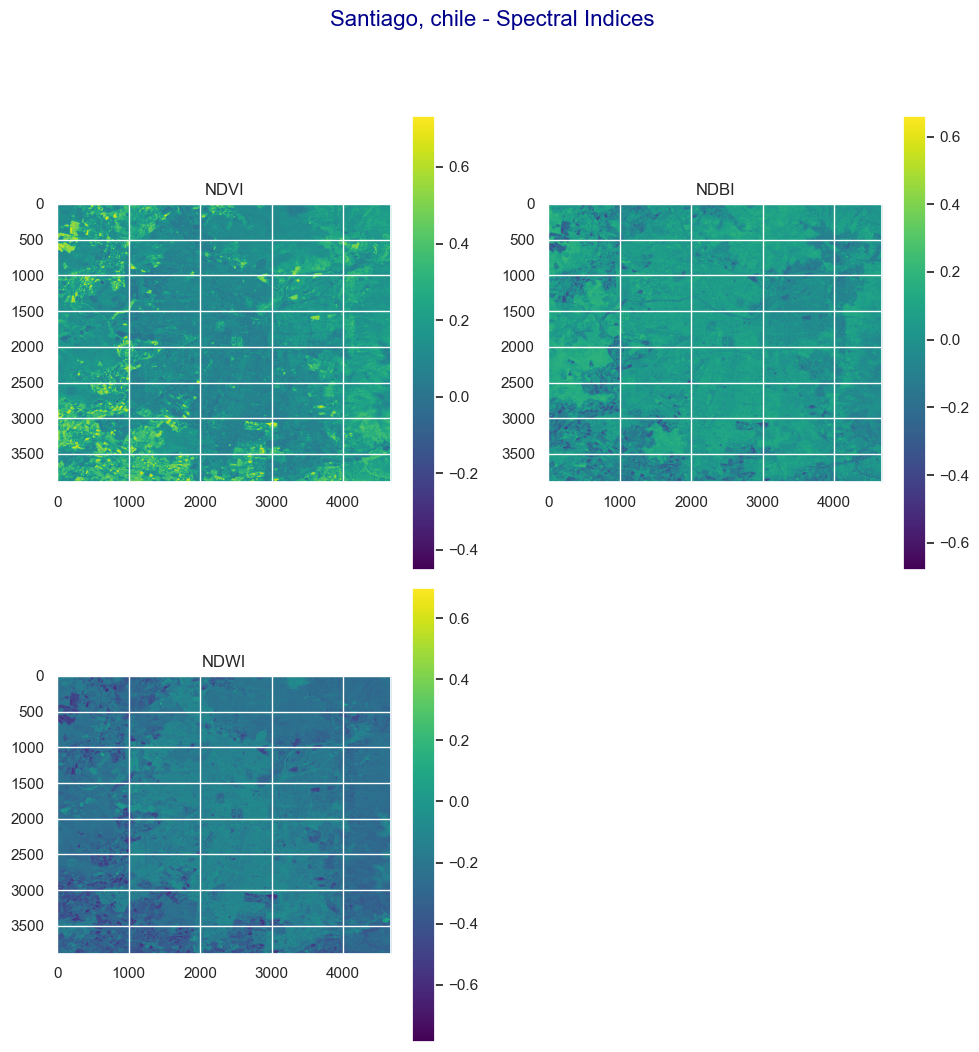

In [6]:
# For santiago location
plot_spectral_indices("./Data/sample_chile.tiff", location_name="Santiago, chile")

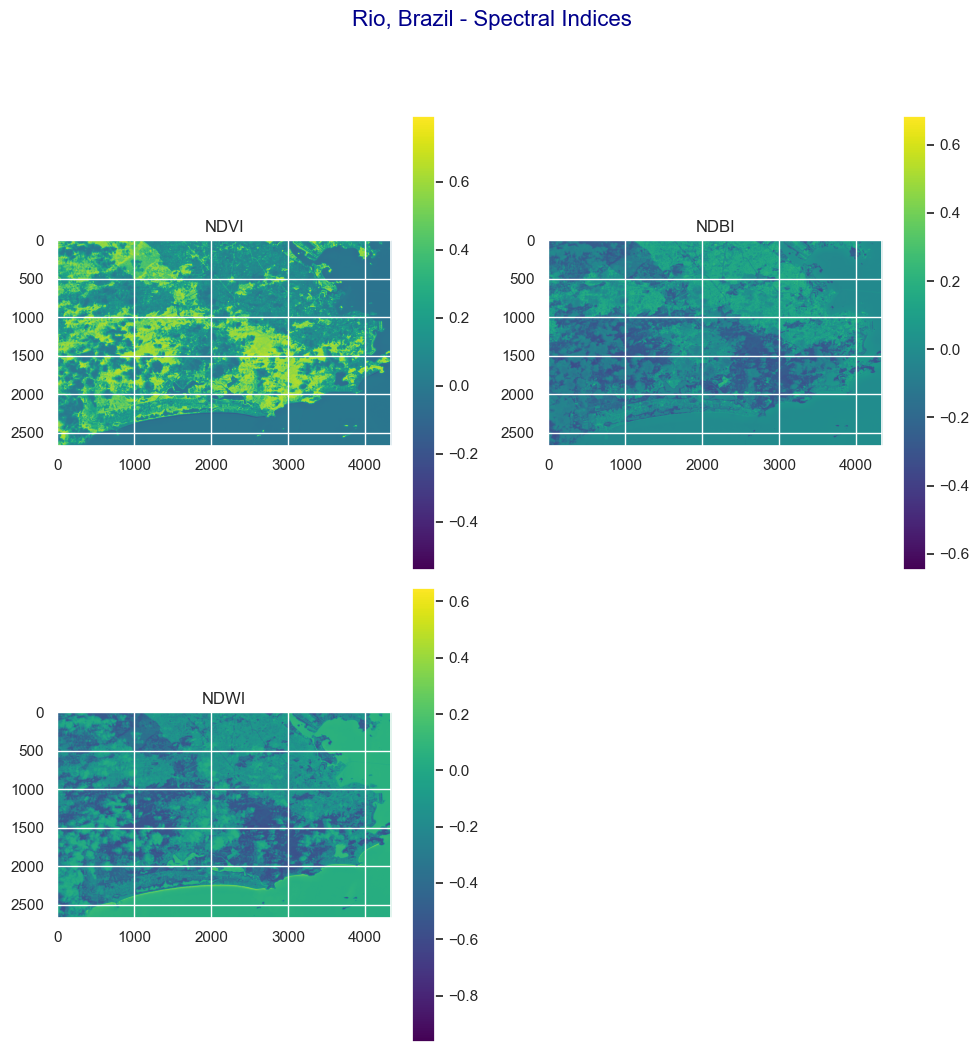

In [7]:
# For Rio location
plot_spectral_indices("./Data/sample_Brazil.tiff", location_name="Rio, Brazil")

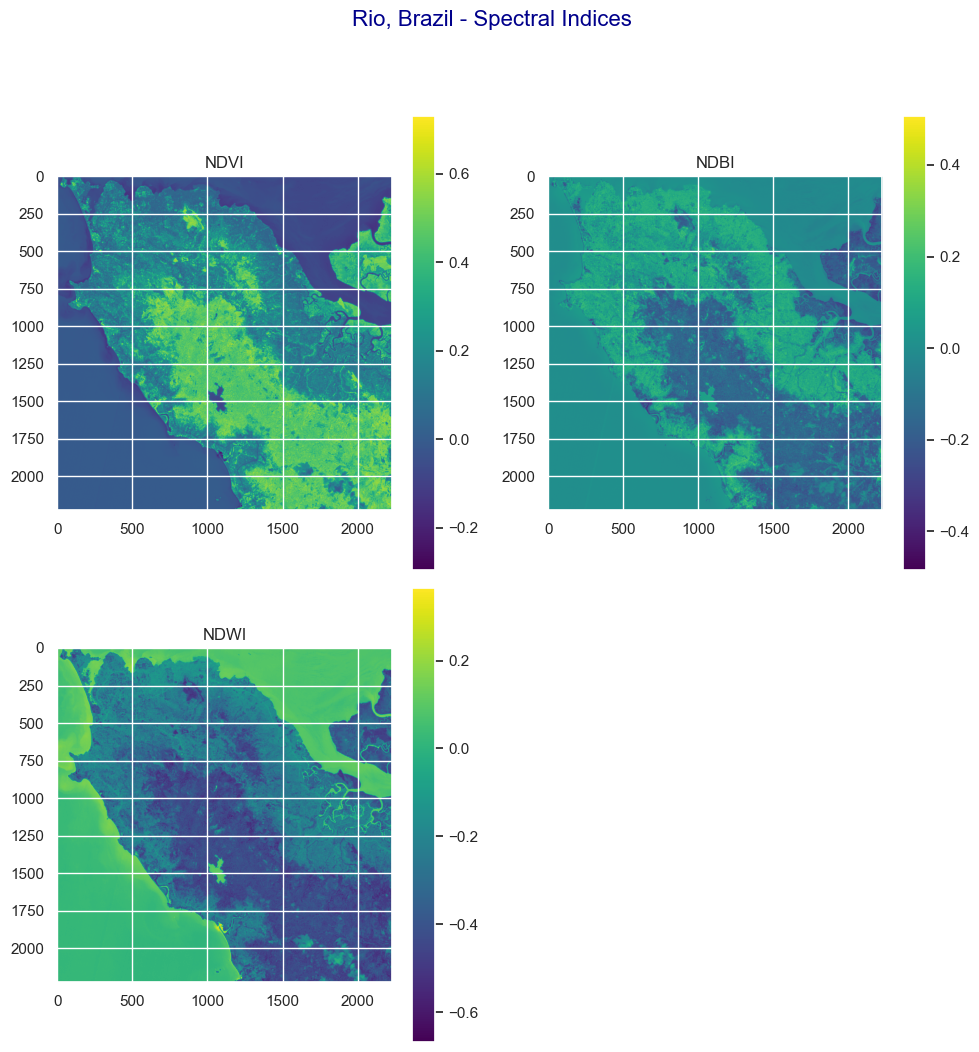

In [8]:
# For Rio location
plot_spectral_indices("./Data/sample_Sierra_V2.tiff", location_name="Rio, Brazil")

In [9]:
# Extract spectral indices for each location
def extract_band_vales(
    geotiff_path,
    csv_input_path
):
    
    # Load the GeoTIFF data
    data = rxr.open_rasterio(geotiff_path)
    tiff_crs = data.rio.crs

    # Read the Excel file using pandas
    df = pd.read_csv(csv_input_path)
    latitudes = df['Latitude'].values
    longitudes = df['Longitude'].values

    # 3. Convert lat/long to the GeoTIFF's CRS
    # Create a Proj object for EPSG:4326 (WGS84 - lat/long) and the GeoTIFF's CRS
    proj_wgs84 = Proj(init='epsg:4326')  # EPSG:4326 is the common lat/long CRS
    proj_tiff = Proj(tiff_crs)
    
    # Create a transformer object
    transformer = Transformer.from_proj(proj_wgs84, proj_tiff)

    median_NDVI = []
    median_NDBI = []
    median_NDWI = []

# Iterate over the latitudes and longitudes, and extract the corresponding band values
    for lat, lon in tqdm(zip(latitudes, longitudes), total=len(latitudes), desc="Mapping values"):
    # Assuming the correct dimensions are 'y' and 'x' (replace these with actual names from data.coords)
    
        NDVI = data.sel(x=lon, y=lat,  band=1, method="nearest").values
        median_NDVI.append(NDVI)
    
        NDBI = data.sel(x=lon, y=lat, band=2, method="nearest").values
        median_NDBI.append(NDBI)
        
        NDWI = data.sel(x=lon, y=lat, band=3, method="nearest").values
        median_NDWI.append(NDWI)


    # Create a DataFrame with the band values
    # Create a DataFrame to store the band values
    df["median_NDVI"] = median_NDVI
    df["median_NDBI"] = median_NDBI
    df["median_NDWI"] = median_NDWI

    return df

In [10]:
# Mapping satellite data with training data for the chile location.
chile_heat_data = extract_band_vales(geotiff_path="./Data/sample_chile.tiff", csv_input_path="./Data/sample_chile_uhi_data.csv")
chile_heat_data.head()



Mapping values: 100%|███████████████████████████████████████████████████████████| 21662/21662 [01:56<00:00, 186.02it/s]


Longitude   Latitude UHI_Class           median_NDVI           median_NDBI  \
0 -70.580508 -33.586980       Low    0.1583836507199257   0.05261158594491928   
1 -70.579480 -33.592099       Low   0.19064493267186391  0.008264462809917356   
2 -70.578366 -33.597419    Medium  0.039317858834675506   0.05512489233419466   
3 -70.566661 -33.597109       Low    0.1606896551724138  0.025900737953986397   
4 -70.566296 -33.597079    Medium  0.022598870056497175  0.003715425897894592   

            median_NDWI  
0  -0.17752596789423986  
1   -0.1988582302568982  
2  -0.06349975763451285  
3   -0.1927710843373494  
4  -0.07227488151658767

In [11]:
# Mapping satellite data with training data for the Brazil location.
Brazil_heat_data = extract_band_vales(geotiff_path="./Data/sample_Brazil.tiff", csv_input_path="./Data/sample_Brazil_uhi_data.csv")
Brazil_heat_data.head()

Mapping values: 100%|███████████████████████████████████████████████████████████| 28488/28488 [02:41<00:00, 176.45it/s]


Longitude   Latitude UHI_Class           median_NDVI           median_NDBI  \
0 -43.278320 -22.901192    Medium    0.0327132777421424  -0.01689562608558345   
1 -43.278298 -22.901215    Medium    0.0327132777421424  -0.01689562608558345   
2 -43.278277 -22.901235    Medium  0.005279831045406547   0.04305578823923605   
3 -43.278218 -22.901298    Medium   0.01802838511699271   0.15383389128008926   
4 -43.278185 -22.901335    Medium  0.002041649652919559   0.11790079079798706   

             median_NDWI  
0   -0.06870229007633588  
1   -0.06870229007633588  
2  -0.028077753779697623  
3    -0.0645808263136783  
4  -0.045590115040477205

In [12]:
# Computes building density (buildings per square meter) within a square buffer (default: 100 meters)
# around each point defined in a CSV file. Input building footprints are read from a shapefile (.shp).
def compute_building_density(
    csv_path,
    buildings_shp_path,
    lat_col="Latitude",
    lon_col="Longitude",
    buffer_m=100
):
    """
    Computes building density (buildings per m²) within a square buffer around each point.

    Parameters:
    - csv_path: str, path to input CSV with latitude and longitude
    - buildings_kml_path: str, path to KML with building footprints
    - lat_col: str, column name for latitude
    - lon_col: str, column name for longitude
    - buffer_m: float, buffer size in meters (square)

    Returns:
    - GeoDataFrame with new column: 'building_density_100m'
    """

    # Load CSV and convert to GeoDataFrame
    df = pd.read_csv(csv_path)
    df['geometry'] = df.apply(lambda row: Point(row[lon_col], row[lat_col]), axis=1)
    
    # Convert the DataFrame to a GeoDataFrame in WGS84 (EPSG:4326)
    gdf_points = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326")
    
    # Load the building footprints from the shapefile
    gdf_buildings = gpd.read_file(buildings_shp_path)
    
    # Reproject buildings GeoDataFrame to EPSG:3857 (Web Mercator) if not already in that CRS
    # This projection uses meters, which is essential for accurate area and distance calculations
    if gdf_buildings.crs != "EPSG:3857":
        gdf_buildings = gdf_buildings.to_crs(epsg=3857)

    # Reproject point geometries to EPSG:3857 for consistent metric-based buffering
    gdf_points = gdf_points.to_crs(epsg=3857)

    # Initialize a list to store computed building densities
    building_densities = []

    # Loop through each point to compute the number of buildings within the buffer
    for _, row in tqdm(gdf_points.iterrows(), total=len(gdf_points), desc="Calculating building density"):
        point_geom = row.geometry
        
        # Create a square buffer (bounding box) of side `buffer_m` centered on the point
        buffer_geom = box(
            point_geom.x - buffer_m / 2, point_geom.y - buffer_m / 2,
            point_geom.x + buffer_m / 2, point_geom.y + buffer_m / 2
        )

        # Select buildings that intersect with the buffer area
        buildings_in_buffer = gdf_buildings[gdf_buildings.geometry.intersects(buffer_geom)].copy()
        
        
        # Repair invalid geometries using a zero-width buffer (commonly used geometry fix)
        buildings_in_buffer["geometry"] = buildings_in_buffer.geometry.buffer(0)
        
        # Compute area of the square buffer in square meters
        area_m2 = buffer_geom.area
        
        # Count the number of buildings intersecting the buffer
        bldg_count = len(buildings_in_buffer)
        
        # Compute building density as count per square meter
        density = bldg_count / area_m2 if area_m2 > 0 else 0

        # Append the result to the list
        building_densities.append(density)
        
    # Add the computed densities as a new column in the points GeoDataFrame
    gdf_points["building_density_100m"] = building_densities
    return gdf_points


In [13]:
# Compute building density within 100-meter square buffers around each point 
# in the Santiago UHI dataset, using building footprints from 'Chile.shp'.
chile_buildings_data = compute_building_density(
    csv_path="./Data/sample_chile_uhi_data.csv",
    buildings_shp_path="./Data/Chile Building Footprints/Chile_clipped.shp")


# Preview the first few rows of the resulting GeoDataFrame, 
# which now includes a 'building_density_100m' column.
chile_buildings_data.head()


Calculating building density: 100%|██████████████████████████████████████████████| 21662/21662 [32:40<00:00, 11.05it/s]


Longitude   Latitude UHI_Class                           geometry  \
0 -70.580508 -33.586980       Low  POINT (-7856986.247 -3973477.416)   
1 -70.579480 -33.592099       Low  POINT (-7856871.774 -3974161.536)   
2 -70.578366 -33.597419    Medium  POINT (-7856747.761 -3974872.544)   
3 -70.566661 -33.597109       Low  POINT (-7855444.813 -3974831.078)   
4 -70.566296 -33.597079    Medium  POINT (-7855404.166 -3974827.012)   

   building_density_100m  
0                 0.0005  
1                 0.0002  
2                 0.0001  
3                 0.0012  
4                 0.0010

In [14]:
# Compute building density within 100-meter square buffers around each point 
# in the Rio UHI dataset, using building footprints from 'Brazil.shp'.
Brazil_buildings_data = compute_building_density(
    csv_path="./Data/sample_Brazil_uhi_data.csv",
    buildings_shp_path="./Data/Brazil Building Footprints/Brazil_clipped.shp")


# Preview the first few rows of the resulting GeoDataFrame, 
# which now includes a 'building_density_100m' column.
Brazil_buildings_data.head()


Calculating building density: 100%|██████████████████████████████████████████████| 28488/28488 [35:22<00:00, 13.42it/s]


Longitude   Latitude UHI_Class                           geometry  \
0 -43.278320 -22.901192    Medium  POINT (-4817720.545 -2620073.807)   
1 -43.278298 -22.901215    Medium  POINT (-4817718.132 -2620076.626)   
2 -43.278277 -22.901235    Medium  POINT (-4817715.721 -2620079.043)   
3 -43.278218 -22.901298    Medium  POINT (-4817709.227 -2620086.696)   
4 -43.278185 -22.901335    Medium  POINT (-4817705.517 -2620091.128)   

   building_density_100m  
0                 0.0002  
1                 0.0002  
2                 0.0002  
3                 0.0002  
4                 0.0002

In [15]:
# Combine UHI data with extracted building density feature for Santiago.
# Selected features include location (Longitude, Latitude), UHI classification,
# median vegetation, built-up, and water indices, along with building density.
chile_combined = pd.concat([chile_heat_data[['Longitude', 'Latitude', 'UHI_Class', 'median_NDVI', 'median_NDBI', 'median_NDWI']], 
                               chile_buildings_data[['building_density_100m']]], axis=1)

# Repeat the same combination for Rio de Janeiro.
Brazil_combined = pd.concat([Brazil_heat_data[['Longitude', 'Latitude', 'UHI_Class', 'median_NDVI', 'median_NDBI', 'median_NDWI']], 
                          Brazil_buildings_data[['building_density_100m']]], axis=1)


In [16]:
# Merge the combined data from Santiago and Rio into a single training DataFrame.
# This unified dataset includes UHI class, spectral indices, and building density features.
train_df= pd.concat([chile_combined,Brazil_combined], axis=0)

# Preview the first few rows of the training dataset.
train_df.head()

Longitude   Latitude UHI_Class           median_NDVI           median_NDBI  \
0 -70.580508 -33.586980       Low    0.1583836507199257   0.05261158594491928   
1 -70.579480 -33.592099       Low   0.19064493267186391  0.008264462809917356   
2 -70.578366 -33.597419    Medium  0.039317858834675506   0.05512489233419466   
3 -70.566661 -33.597109       Low    0.1606896551724138  0.025900737953986397   
4 -70.566296 -33.597079    Medium  0.022598870056497175  0.003715425897894592   

            median_NDWI  building_density_100m  
0  -0.17752596789423986                 0.0005  
1   -0.1988582302568982                 0.0002  
2  -0.06349975763451285                 0.0001  
3   -0.1927710843373494                 0.0012  
4  -0.07227488151658767                 0.0010

In [17]:
# List of columns to check for duplicates
columns_to_check = ['median_NDVI', 'median_NDBI', 'median_NDWI', 'building_density_100m']

# Convert numpy arrays in columns to tuples so they can be compared properly
for col in columns_to_check:
    train_df[col] = train_df[col].apply(
        lambda x: tuple(x) if isinstance(x, np.ndarray) and x.ndim > 0 else x
    )

# Check number of duplicates before dropping
num_duplicates = train_df.duplicated(subset=columns_to_check).sum()
print(f"Number of duplicate rows based on {columns_to_check}: {num_duplicates}")

# Drop duplicate rows based on the selected columns, keeping the first occurrence
uhi_data = train_df.drop_duplicates(subset=columns_to_check, keep='first')

# Show first few rows of the cleaned DataFrame
uhi_data.head()

Number of duplicate rows based on ['median_NDVI', 'median_NDBI', 'median_NDWI', 'building_density_100m']: 5229


Longitude   Latitude UHI_Class  median_NDVI  median_NDBI  median_NDWI  \
0 -70.580508 -33.586980       Low     0.158384     0.052612    -0.177526   
1 -70.579480 -33.592099       Low     0.190645     0.008264    -0.198858   
2 -70.578366 -33.597419    Medium     0.039318     0.055125    -0.063500   
3 -70.566661 -33.597109       Low     0.160690     0.025901    -0.192771   
4 -70.566296 -33.597079    Medium     0.022599     0.003715    -0.072275   

   building_density_100m  
0                 0.0005  
1                 0.0002  
2                 0.0001  
3                 0.0012  
4                 0.0010

In [18]:
# Resetting the index
uhi_data=uhi_data.reset_index(drop=True)

In [19]:
#Reading the coordinates for the submission
test_file = pd.read_csv('./Test.csv')
test_file.head()

ID  Longitude  Latitude  Target
0  ID_1 -13.272932  8.447807     NaN
1  ID_2 -13.272938  8.447757     NaN
2  ID_3 -13.272997  8.447133     NaN
3  ID_4 -13.273002  8.447015     NaN
4  ID_5 -13.273007  8.446915     NaN

In [20]:
# Mapping satellite data with training data for the sierra location.
Sierra_heat_data = extract_band_vales(geotiff_path="./Data/sample_Sierra_V2.tiff", csv_input_path="./Test.csv")
Sierra_heat_data.head()

Mapping values: 100%|███████████████████████████████████████████████████████████| 14105/14105 [01:08<00:00, 204.57it/s]


ID  Longitude  Latitude  Target          median_NDVI  \
0  ID_1 -13.272932  8.447807     NaN  0.02374893977947413   
1  ID_2 -13.272938  8.447757     NaN  0.02374893977947413   
2  ID_3 -13.272997  8.447133     NaN  0.15561335067186824   
3  ID_4 -13.273002  8.447015     NaN  0.12137823022709475   
4  ID_5 -13.273007  8.446915     NaN  0.10152881223049784   

            median_NDBI           median_NDWI  
0   0.15976331360946747  -0.11192998618148318  
1   0.15976331360946747  -0.11192998618148318  
2    0.0887027858485729   -0.2348309402501158  
3  0.053066622582244996  -0.19159558976492616  
4   0.08304780551476587  -0.21566082630326627

In [21]:
# Compute building density within 100-meter square buffers around each point 
# in the Sierrs UHI dataset, using building footprints from 'Sierra Leone.shp'.
Sierra_buildings_data = compute_building_density(
    csv_path="./Test.csv",
    buildings_shp_path="./Data/Sierra Leone Building Footprints/Sierra Leone_clipped.shp")

Sierra_buildings_data.head()


Calculating building density: 100%|██████████████████████████████████████████████| 14105/14105 [05:06<00:00, 46.03it/s]


ID  Longitude  Latitude  Target                         geometry  \
0  ID_1 -13.272932  8.447807     NaN  POINT (-1477535.995 943831.442)   
1  ID_2 -13.272938  8.447757     NaN  POINT (-1477536.736 943825.815)   
2  ID_3 -13.272997  8.447133     NaN  POINT (-1477543.231 943755.665)   
3  ID_4 -13.273002  8.447015     NaN  POINT (-1477543.787 943742.348)   
4  ID_5 -13.273007  8.446915     NaN  POINT (-1477544.344 943731.094)   

   building_density_100m  
0                 0.0015  
1                 0.0014  
2                 0.0010  
3                 0.0011  
4                 0.0011

In [22]:
# Combine UHI data with extracted building density feature for Sierra.
# Selected features include location (Longitude, Latitude), UHI classification,
# median vegetation, built-up, and water indices, along with building density.
sierra_combined = pd.concat([Sierra_heat_data[['Longitude', 'Latitude', 'Target', 'median_NDVI', 'median_NDBI', 'median_NDWI']], 
                             Sierra_buildings_data[['building_density_100m']]], axis=1)

In [23]:
# Create a copy of the Sierra dataset for validation purposes to avoid modifying the original data
test_data=sierra_combined.copy()

### Analysis of Dataset

In [24]:
#checking for nan values
uhi_data.isnull().sum()

Longitude                0
Latitude                 0
UHI_Class                0
median_NDVI              0
median_NDBI              0
median_NDWI              0
building_density_100m    0
dtype: int64

In [25]:
# chaeck the value count of the Uhi_class
uhi_data['UHI_Class'].value_counts()


UHI_Class
High      15804
Medium    15010
Low       14107
Name: count, dtype: int64

From the UHI class highh as most occurence indicating it area of the location examined head high heat than ares with low or medium heat temperature 

In [26]:
#The point-based UHI dataset was converted into a GeoDataFrame using
#geographic coordinates (WGS84).The data were subsequently reprojected into the Web Mercator coordinate
#reference system (EPSG:3857) to enable accurate distance-based spatial analysis and buffer operations in metric units
gdf = gpd.GeoDataFrame(
    uhi_data,
    geometry=gpd.points_from_xy(uhi_data.Longitude, uhi_data.Latitude),
    crs="EPSG:4326"
).to_crs(epsg=3857)


from the visualization from
1. areas with had high median ndvi had more low temperature than the medium and hihg
2. high temperture was of the lowest ocuurence in the plot and it had some outliers

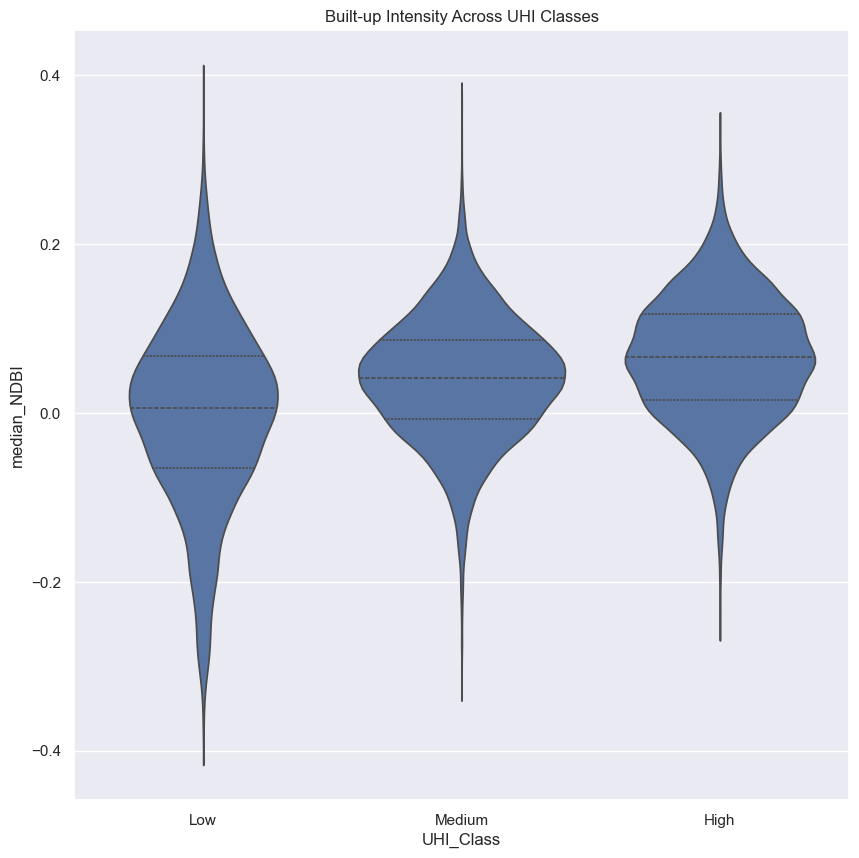

In [27]:
# creating a volinplot
sns.violinplot(
    data=gdf,
    x="UHI_Class",
    y="median_NDBI",
    inner="quartile"
)
plt.title("Built-up Intensity Across UHI Classes")
plt.show()


from the visualization from violin plot
1. the uhi clas of the low as more values in the buttom part indicating that at low ndbi the low temparture is much
2. while the medium and high temperture as more feature at the top path indicating haigr tempearture with the increase in median ndbi
3. at average the high temperature of the UHI class is more than the rest indicating it as more occurence that both low and medium

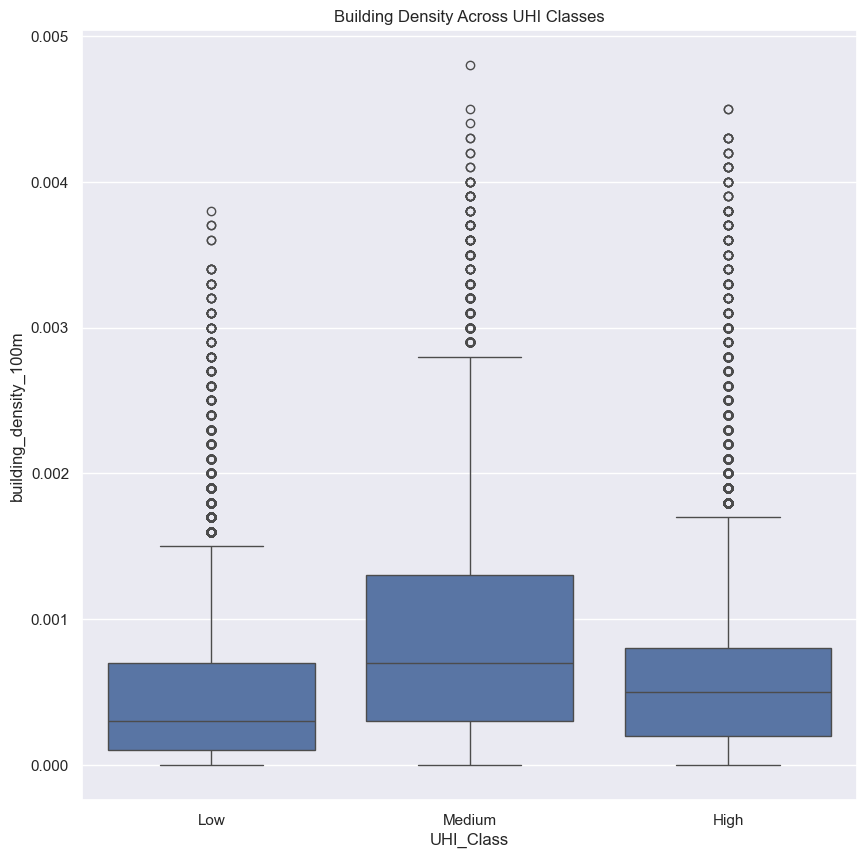

In [28]:
#creating a box plot
sns.boxplot(
    data=gdf,
    x="UHI_Class",
    y="building_density_100m"
)
plt.title("Building Density Across UHI Classes")
plt.show()


### The boxplot reveals distinct patterns in how temperature varies with urban intensity and building density.

First, medium-temperature areas show the highest occurrence of observations, indicating that most locations in the dataset fall within the medium UHI class. The presence of a few outliers suggests that some locations within this group experience unusually low or high temperatures compared to the general trend, likely due to local factors such as vegetation cover, shading, or surface materials.

Second, low-temperature areas have the least occurrence, implying that truly cool zones are relatively rare in the study area. This supports the idea that as building presence increases, natural cooling effects (from vegetation and open land) are reduced, causing surface temperatures to rise. In other words, urban development appears to be suppressing the formation of low-temperature zones.

Third, the plot shows that areas with high building density are mainly associated with medium to high temperatures. This reflects the well-known urban heat island effect, where dense concentrations of buildings, concrete, and asphalt absorb and retain heat, leading to higher surface temperatures.

Finally, areas with low building density tend to exhibit lower temperatures. These zones are more likely to include open spaces, vegetation, or undeveloped land, which promote cooling through shading and evapotranspiration.

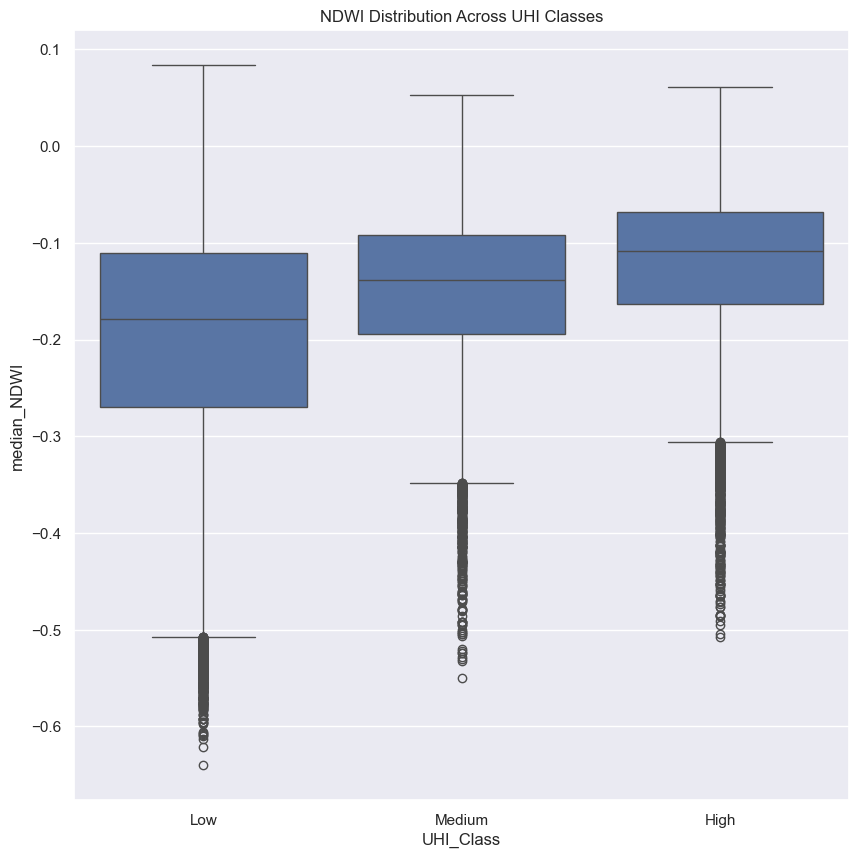

In [29]:
sns.boxplot(
    data=gdf,
    x="UHI_Class",
    y="median_NDWI"
)
plt.title("NDWI Distribution Across UHI Classes")
plt.show()


## From the box visualization btw median ndwi and uhi class

1.  low-UHI areas are, on average, slightly drier than medium and high-UHI areas.
2.  This could happen if many “low-UHI” zones are open bare land, sandy areas, or sparsely vegetated regions rather than green parks or water-rich zones.
3.  Low-UHI areas are more mixed in character — some are very dry, others less so.
4.  Medium and high-UHI areas are more homogeneous in surface moisture.
   
The boxplot shows that low-UHI areas have slightly lower (more negative) median NDWI values and much greater variability than medium and high-UHI areas, indicating that low-UHI zones are generally drier but more heterogeneous in moisture conditions, while higher-UHI zones have more uniform and moderately higher surface moisture.

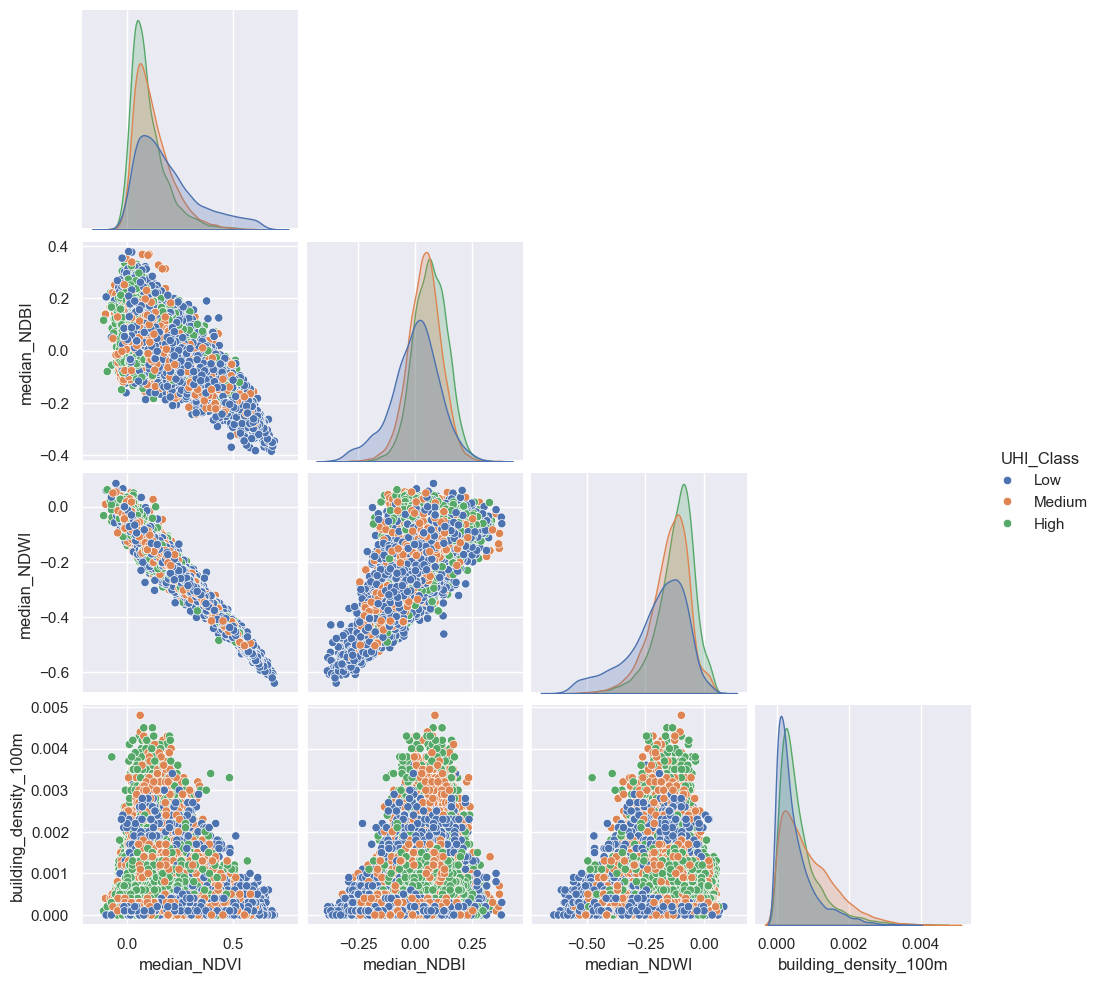

In [30]:
#check the correlation of the features using pair plot
sns.pairplot(
    gdf[
        [
            "median_NDVI",
            "median_NDBI",
            "median_NDWI",
            "building_density_100m",
            "UHI_Class"
        ]
    ],
    hue="UHI_Class",
    corner=True
)
plt.show()


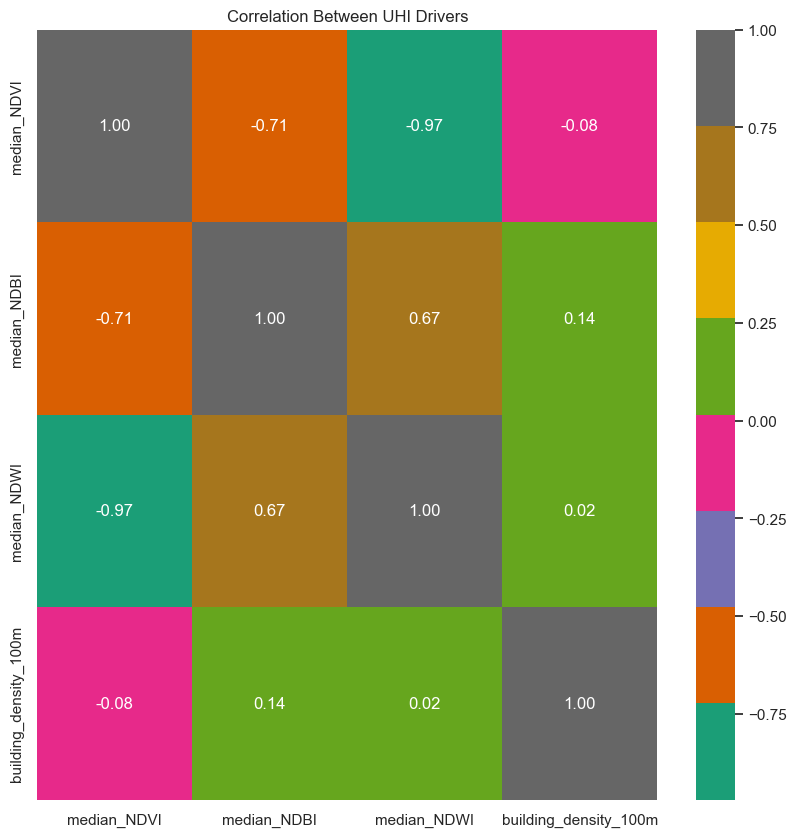

In [31]:
# creating hetmap fro nurmerical correlation
corr = gdf[
    [
        "median_NDVI",
        "median_NDBI",
        "median_NDWI",
        "building_density_100m"
    ]
].corr()

sns.heatmap(
    corr,
    annot=True,
    cmap="Dark2",
    fmt=".2f"
)
plt.title("Correlation Between UHI Drivers")
plt.show()


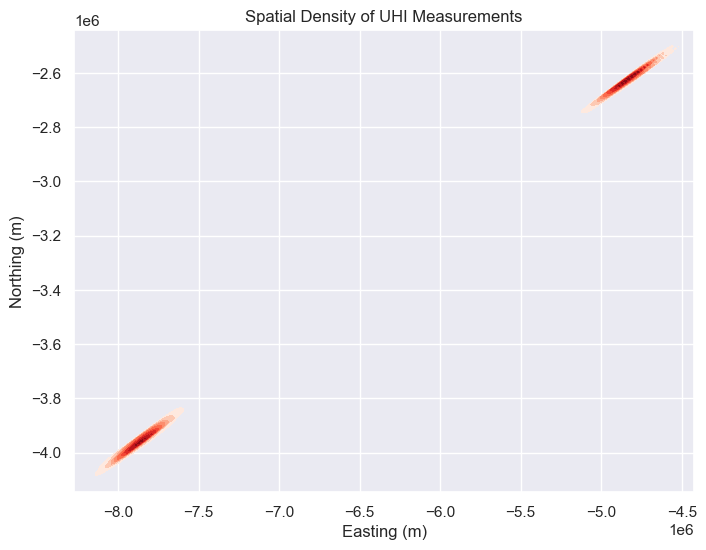

In [32]:
import seaborn as sns

plt.figure(figsize=(8,6))
sns.kdeplot(
    x=gdf.geometry.x,
    y=gdf.geometry.y,
    fill=True,
    cmap="Reds",
    bw_adjust=0.5
)
plt.title("Spatial Density of UHI Measurements")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.show()


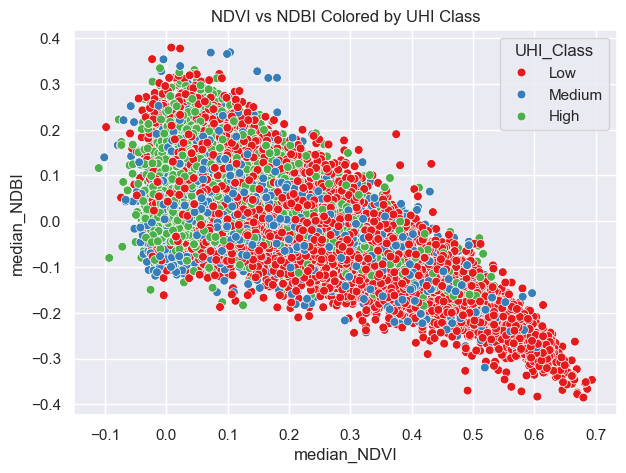

In [33]:
plt.figure(figsize=(7,5))
sns.scatterplot(
    data=gdf,
    x="median_NDVI",
    y="median_NDBI",
    hue="UHI_Class",
    palette="Set1",
    s=40
)
plt.title("NDVI vs NDBI Colored by UHI Class")
plt.show()


## The scatter plot shows a clear relationship between vegetation, built-up intensity, and surface temperature.

First, in the region where NDVI ranges from about 0.5 to 0.7 and NDBI ranges from about –0.4 to –0.3, there is a strong concentration of low-temperature occurrences. This pattern indicates that areas with high vegetation cover and low built-up intensity tend to experience cooler surface temperatures. Vegetation promotes cooling through shading and evapotranspiration, while low NDBI values reflect minimal building and impervious surfaces.

Second, in the upper region of the plot—where NDBI is higher (more built-up surfaces) and NDVI is lower (less vegetation)—high-temperature occurrences dominate. This confirms that densely built areas with limited vegetation are more prone to heat accumulation, consistent with the urban heat island effect.

Third, the medium-temperature class spreads widely across the diagram and overlaps with both the low- and high-temperature groups. This suggests that medium-temperature zones represent transitional or mixed land-cover conditions, where moderate vegetation and moderate building density coexist. Because of this mixed surface character, their thermal behavior overlaps with both cooler vegetated zones and hotter built-up zones.

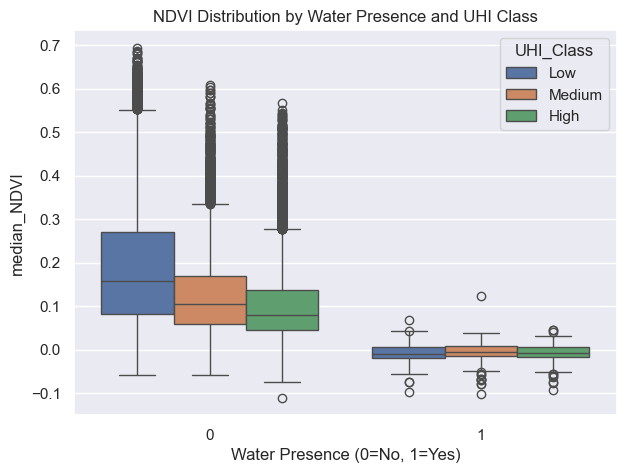

In [34]:
gdf["water_presence"] = (gdf["median_NDWI"] > 0).astype(int)

plt.figure(figsize=(7,5))
sns.boxplot(
    data=gdf,
    x="water_presence",
    y="median_NDVI",
    hue="UHI_Class"
)
plt.title("NDVI Distribution by Water Presence and UHI Class")
plt.xlabel("Water Presence (0=No, 1=Yes)")
plt.show()


### The boxplot reveals meaningful relationships between vegetation (NDVI), water presence, and surface temperature.

First, the plot shows that the low-temperature class has the largest occurrence, indicating that most observations fall within cooler surface temperature conditions. This suggests that, overall, the study area is dominated by relatively cool or moderately cool environments rather than extreme heat conditions.

Second, at high NDVI values, the low-temperature class clearly dominates over the medium and high-temperature classes. This confirms that areas with dense vegetation cover tend to experience lower surface temperatures. Vegetation enhances cooling through shading and evapotranspiration, thereby reducing surface heat accumulation.

Third, this cooling effect is particularly evident in conditions where there is an absence of surface water. In such areas, vegetation alone appears to play a major role in regulating surface temperature, compensating for the lack of cooling from water bodies.

Fourth, in the presence of surface water, the low-temperature class is still slightly more frequent than the high-temperature class. This indicates that water bodies strengthen the cooling effect, especially during cooler weather conditions. It also suggests a dynamic response:

when conditions are cool, water and vegetation together promote rapid temperature reduction,

whereas during hotter conditions, the same areas can still retain some heat, producing occasional higher-temperature observations.

This explains why both low and high temperatures can still appear near water-rich zones, although low temperatures remain dominant.

Finally, the medium-temperature class shows the highest number of outliers, although outliers are also present in the low- and high-temperature groups. This suggests that medium-temperature zones are the most heterogeneous, likely representing mixed land-cover conditions where small changes in vegetation density, moisture, or built-up surfaces can cause notable deviations in surface temperature.

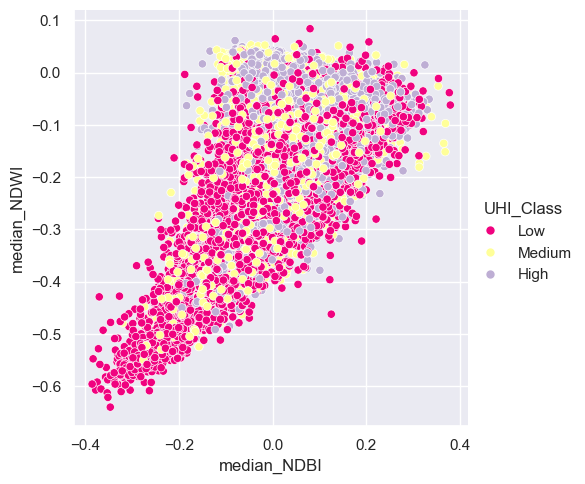

In [35]:
# replot visualization
sns.relplot(x="median_NDBI", y="median_NDWI", hue="UHI_Class",data=uhi_data, palette="Accent_r")

### The scatter plot highlights how surface moisture (NDWI), built-up intensity (NDBI), and temperature interact across the study area.

First, in the region where NDWI ranges from about –0.6 to –0.4 and NDBI ranges from about –0.4 to –0.2, there is a strong concentration of low-temperature occurrences. This pattern indicates that areas with low to moderate surface moisture and low built-up intensity tend to experience cooler surface temperatures. These zones are likely characterized by open land, sparse development, and limited impervious surfaces, which reduces heat accumulation.

Second, the medium-temperature class is relatively scarce across the entire plot. This suggests that most locations tend to fall more clearly into either cool or hot surface conditions, rather than exhibiting intermediate thermal behavior. In other words, the thermal contrast between cooler and hotter zones in the city appears quite pronounced.

Third, at higher values of both NDWI and NDBI, the scatter plot shows a higher concentration of high-temperature occurrences. This indicates that areas with both greater surface moisture and higher building density tend to be warmer. In an urban context, this can occur in densely built zones located near rivers, wetlands, lagoons, or coastal margins, where moisture is present but extensive impervious surfaces and human activity still dominate the surface energy balance.

Finally, taken together, these patterns indicate that in this city, high water presence combined with high built-up density is associated with elevated surface temperatures. This suggests that the cooling potential of surface water is being offset—or even overwhelmed—by the strong heat-retaining effects of dense urban development and impervious materials.

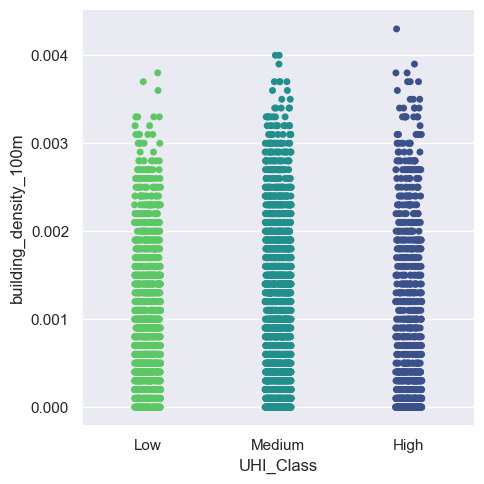

In [36]:
# creating a catplot
sns.catplot(y="building_density_100m", x="UHI_Class",palette ="viridis_r", kind='strip',data=uhi_data[:5000]);

from the plot
1. high as the hihest occurence from the plot btw building densty _100m
2. high als has the hihest outerlier than medium and low

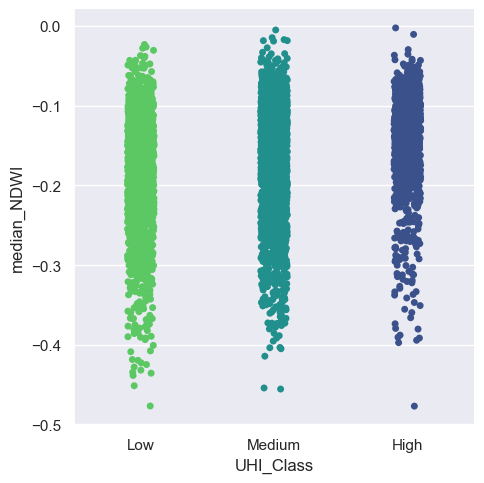

In [37]:
# catplot visalization
sns.catplot(y="median_NDWI", x="UHI_Class",palette ="viridis_r", kind='strip',data=uhi_data[:5000]);

### The catplot illustrates how surface moisture (NDWI) is distributed across different temperature or UHI classes.

First, the plot shows that most observations occur at the mid to high values of NDWI. This indicates that a large proportion of the study area has moderate to relatively high surface moisture, suggesting the presence of vegetation moisture, irrigated surfaces, wetlands, or proximity to water bodies across many locations in the city.

Second, the high-temperature class has the lowest occurrence throughout the dataset. This implies that extreme hot conditions are relatively limited in spatial extent compared to low- and medium-temperature conditions. In other words, although urban heat islands exist, they occupy a smaller fraction of the total area than cooler or moderately warm zones.

Third, the low-temperature class has the highest occurrence, indicating that most locations fall within cooler surface temperature conditions. However, all UHI (or temperature) classes exhibit outliers, meaning that within each class there are a few locations with unusually low or high NDWI values. This reflects localized anomalies such as isolated water bodies, irrigated parks, dense vegetation patches, or highly impervious surfaces embedded within otherwise different thermal zones.

In [38]:
# checking missing values
uhi_data.isnull().sum()

Longitude                0
Latitude                 0
UHI_Class                0
median_NDVI              0
median_NDBI              0
median_NDWI              0
building_density_100m    0
dtype: int64

## TEST_DATA

In [39]:
#checking for nan values
test_data.isnull().sum()

Longitude                    0
Latitude                     0
Target                   14105
median_NDVI                  0
median_NDBI                  0
median_NDWI                  0
building_density_100m        0
dtype: int64

In [40]:
# convertibg the longitude and latitude into spatial data
gdt = gpd.GeoDataFrame(
    test_data,
    geometry=gpd.points_from_xy(test_data.Longitude, test_data.Latitude),
    crs="EPSG:4326"
).to_crs(epsg=3857)


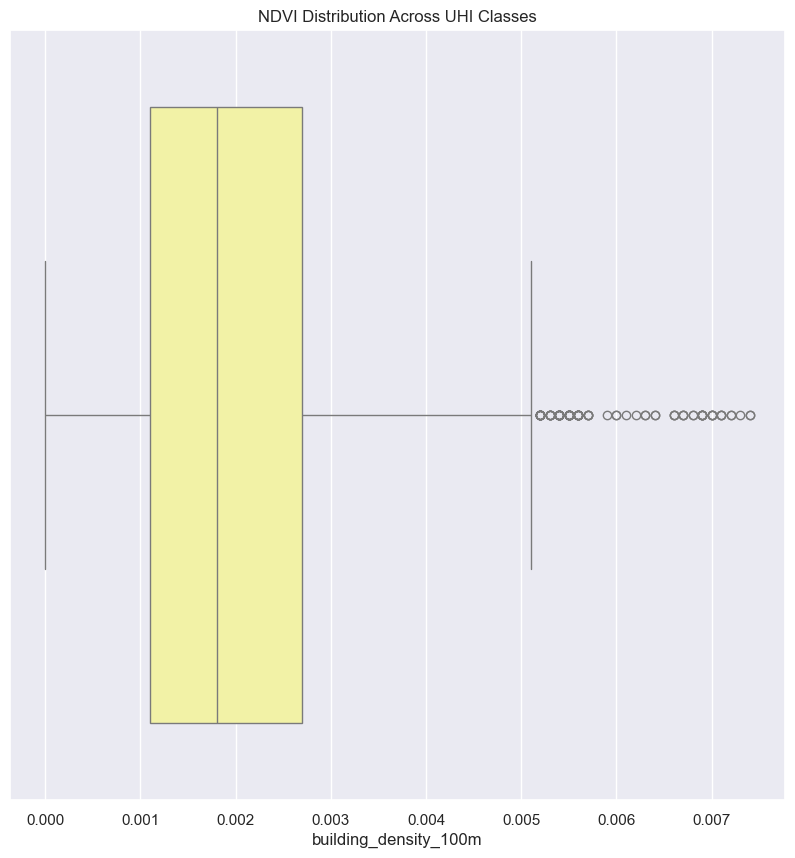

In [41]:
sns.boxplot(
    data=gdt,
    x="building_density_100m",
    palette="Accent_r"
)
plt.title("NDVI Distribution Across UHI Classes")
plt.show()


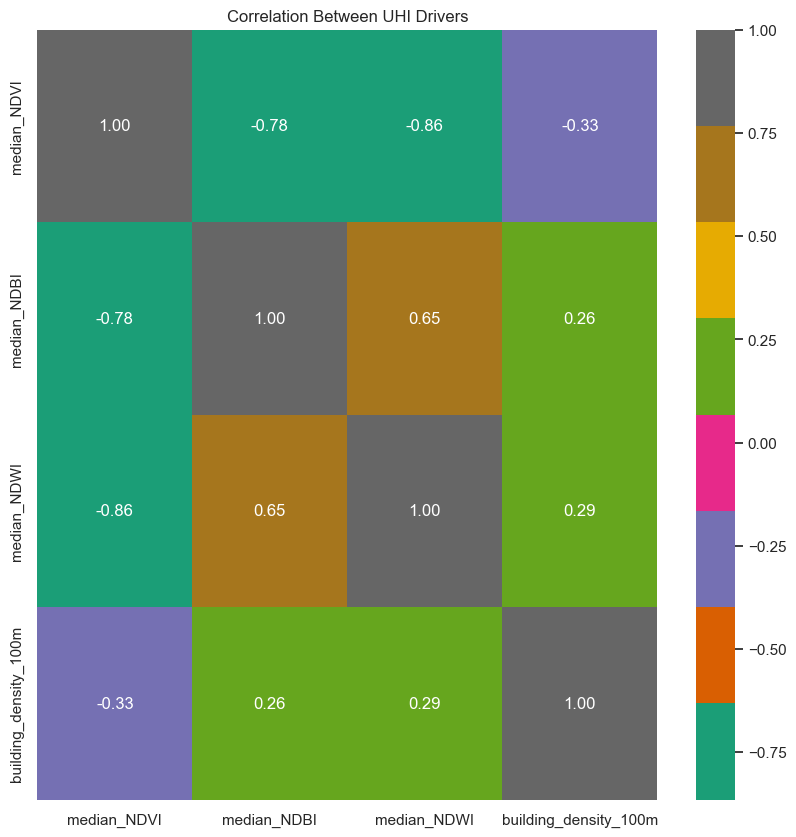

In [42]:
corr = gdt[
    [
        "median_NDVI",
        "median_NDBI",
        "median_NDWI",
        "building_density_100m"
    ]
].corr()

sns.heatmap(
    corr,
    annot=True,
    cmap="Dark2",
    fmt=".2f"
)
plt.title("Correlation Between UHI Drivers")
plt.show()


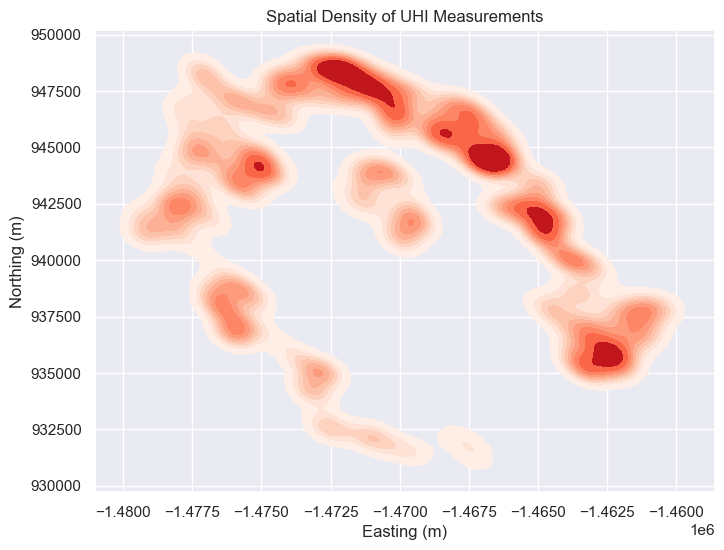

In [43]:
import seaborn as sns

plt.figure(figsize=(8,6))
sns.kdeplot(
    x=gdt.geometry.x,
    y=gdt.geometry.y,
    fill=True,
    cmap="Reds",
    bw_adjust=0.5
)
plt.title("Spatial Density of UHI Measurements")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.show()


In [44]:
test_data.isnull().sum()

Longitude                    0
Latitude                     0
Target                   14105
median_NDVI                  0
median_NDBI                  0
median_NDWI                  0
building_density_100m        0
dtype: int64

### FEATURE ENGINEERING

In [45]:
# 1. Vegetation Stress Index
# high when vegetation is low AND buildings are dense
uhi_data['Vegetation_Stress'] = (1 - uhi_data['median_NDVI']) * uhi_data['building_density_100m']

uhi_data.head()

Longitude   Latitude UHI_Class  median_NDVI  median_NDBI  median_NDWI  \
0 -70.580508 -33.586980       Low     0.158384     0.052612    -0.177526   
1 -70.579480 -33.592099       Low     0.190645     0.008264    -0.198858   
2 -70.578366 -33.597419    Medium     0.039318     0.055125    -0.063500   
3 -70.566661 -33.597109       Low     0.160690     0.025901    -0.192771   
4 -70.566296 -33.597079    Medium     0.022599     0.003715    -0.072275   

   building_density_100m  Vegetation_Stress  
0                 0.0005           0.000421  
1                 0.0002           0.000162  
2                 0.0001           0.000096  
3                 0.0012           0.001007  
4                 0.0010           0.000977

In [46]:
# 2. Urbanization Index
# captures overall urban built-up pressure
uhi_data['Urbanization_Index'] = uhi_data['median_NDBI'] * uhi_data['building_density_100m']
uhi_data.head()

Longitude   Latitude UHI_Class  median_NDVI  median_NDBI  median_NDWI  \
0 -70.580508 -33.586980       Low     0.158384     0.052612    -0.177526   
1 -70.579480 -33.592099       Low     0.190645     0.008264    -0.198858   
2 -70.578366 -33.597419    Medium     0.039318     0.055125    -0.063500   
3 -70.566661 -33.597109       Low     0.160690     0.025901    -0.192771   
4 -70.566296 -33.597079    Medium     0.022599     0.003715    -0.072275   

   building_density_100m  Vegetation_Stress  Urbanization_Index  
0                 0.0005           0.000421            0.000026  
1                 0.0002           0.000162            0.000002  
2                 0.0001           0.000096            0.000006  
3                 0.0012           0.001007            0.000031  
4                 0.0010           0.000977            0.000004

In [47]:
# 3. Wetness Deficit
# high when water/moisture is low
uhi_data['Wetness_Deficit'] = 1 - uhi_data['median_NDWI']
uhi_data.head()

Longitude   Latitude UHI_Class  median_NDVI  median_NDBI  median_NDWI  \
0 -70.580508 -33.586980       Low     0.158384     0.052612    -0.177526   
1 -70.579480 -33.592099       Low     0.190645     0.008264    -0.198858   
2 -70.578366 -33.597419    Medium     0.039318     0.055125    -0.063500   
3 -70.566661 -33.597109       Low     0.160690     0.025901    -0.192771   
4 -70.566296 -33.597079    Medium     0.022599     0.003715    -0.072275   

   building_density_100m  Vegetation_Stress  Urbanization_Index  \
0                 0.0005           0.000421            0.000026   
1                 0.0002           0.000162            0.000002   
2                 0.0001           0.000096            0.000006   
3                 0.0012           0.001007            0.000031   
4                 0.0010           0.000977            0.000004   

   Wetness_Deficit  
0         1.177526  
1         1.198858  
2         1.063500  
3         1.192771  
4         1.072275

In [48]:
# 4. Green vs Built Balance
# ratio of vegetation to impervious surface
uhi_data['Green_vs_Built'] = uhi_data['median_NDVI'] / (uhi_data['median_NDBI'] + 1e-4)
uhi_data.head()

Longitude   Latitude UHI_Class  median_NDVI  median_NDBI  median_NDWI  \
0 -70.580508 -33.586980       Low     0.158384     0.052612    -0.177526   
1 -70.579480 -33.592099       Low     0.190645     0.008264    -0.198858   
2 -70.578366 -33.597419    Medium     0.039318     0.055125    -0.063500   
3 -70.566661 -33.597109       Low     0.160690     0.025901    -0.192771   
4 -70.566296 -33.597079    Medium     0.022599     0.003715    -0.072275   

   building_density_100m  Vegetation_Stress  Urbanization_Index  \
0                 0.0005           0.000421            0.000026   
1                 0.0002           0.000162            0.000002   
2                 0.0001           0.000096            0.000006   
3                 0.0012           0.001007            0.000031   
4                 0.0010           0.000977            0.000004   

   Wetness_Deficit  Green_vs_Built  
0         1.177526        3.004722  
1         1.198858       22.792251  
2         1.063500        0.711959  
3         1.192771        6.180196  
4         1.072275        5.923027

In [49]:
from sklearn.cluster import KMeans
# 5. Spatial clusters from coordinates (adds urban zones)
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
uhi_data['urban_zone_cluster'] = kmeans.fit_predict(uhi_data[['Longitude', 'Latitude']])
uhi_data.head()

Longitude   Latitude UHI_Class  median_NDVI  median_NDBI  median_NDWI  \
0 -70.580508 -33.586980       Low     0.158384     0.052612    -0.177526   
1 -70.579480 -33.592099       Low     0.190645     0.008264    -0.198858   
2 -70.578366 -33.597419    Medium     0.039318     0.055125    -0.063500   
3 -70.566661 -33.597109       Low     0.160690     0.025901    -0.192771   
4 -70.566296 -33.597079    Medium     0.022599     0.003715    -0.072275   

   building_density_100m  Vegetation_Stress  Urbanization_Index  \
0                 0.0005           0.000421            0.000026   
1                 0.0002           0.000162            0.000002   
2                 0.0001           0.000096            0.000006   
3                 0.0012           0.001007            0.000031   
4                 0.0010           0.000977            0.000004   

   Wetness_Deficit  Green_vs_Built  urban_zone_cluster  
0         1.177526        3.004722                   4  
1         1.198858       22.792251                   4  
2         1.063500        0.711959                   4  
3         1.192771        6.180196                   4  
4         1.072275        5.923027                   4

In [50]:
 # 2. Green vs built / moisture interactions
uhi_data["green_minus_built"] = uhi_data["median_NDVI"] - uhi_data["median_NDBI"]
uhi_data["built_intensity"] = uhi_data["median_NDBI"] * uhi_data["building_density_100m"]
uhi_data["dry_built_intensity"] = uhi_data["median_NDBI"] * uhi_data["Wetness_Deficit"]

uhi_data["NDBI_NDWI_index"] = (
        (uhi_data["median_NDBI"] - uhi_data["median_NDWI"]) /
        (uhi_data["median_NDBI"] + uhi_data["median_NDWI"] + 1e-6)
    )


In [51]:
# log transform to reduce skew
uhi_data["log_building_density"] = np.log1p(uhi_data["building_density_100m"])


In [52]:
  # 3. Cooling / heating composite indices
uhi_data["cooling_index"] = (
        uhi_data["median_NDVI"] +
        uhi_data["median_NDWI"] -
        uhi_data["Vegetation_Stress"]
    )

In [53]:
# producing heat_risk_index from additin of ndbi,urbanization_index and wetneess deficit
uhi_data["heat_risk_index"] = (
        uhi_data["median_NDBI"] +
        uhi_data["Urbanization_Index"] +
        uhi_data["Wetness_Deficit"]
    )

In [54]:
# net_cooling _minus_heating creted
uhi_data["net_cooling_minus_heating"] = (
        uhi_data["cooling_index"] - uhi_data["heat_risk_index"]
    )

In [55]:
from scipy import stats
from sklearn.preprocessing import PowerTransformer

def apply_best_transformation(series, name="feature"):
    """
    Apply the statistically best transformation for highly skewed data
    Returns transformed series and transformation details
    """
    original_skew = series.skew()
    print(f"📊 {name} - Original skewness: {original_skew:.3f}")
    
    # DECISION LOGIC
    if original_skew > 1.5:  # High positive skew like 1.63
        if (series > 0).all():
            # Box-Cox is statistically optimal
            transformed, lambda_opt = stats.boxcox(series)
            method = f"Box-Cox (λ={lambda_opt:.3f})"
            
        else:
            # Yeo-Johnson for zeros/negatives
            pt = PowerTransformer(method='yeo-johnson')
            transformed = pt.fit_transform(series.values.reshape(-1, 1)).flatten()
            method = "Yeo-Johnson"
    
    elif original_skew > 0.5:  # Moderate skew
        # Log transformation is sufficient
        if (series > 0).all():
            transformed = np.log(series)
            method = "Log"
        else:
            transformed = np.log(series - series.min() + 1)
            method = "Log(x-min+1)"
    
    else:  # Low skew
        transformed = series.values
        method = "None (skew < 0.5)"
    
    # Results
    final_skew = pd.Series(transformed).skew()
    improvement = abs(original_skew) - abs(final_skew)
    
    print(f"✅ Applied: {method}")
    print(f"📈 Final skewness: {final_skew:.3f}")
    print(f"🎯 Improvement: {improvement:.3f}")
    
    if abs(final_skew) > 0.5:
        print(f"⚠️ Warning: Skew still > 0.5. Consider additional processing.")
    
    return transformed, method

# Usage - ONE LINE
uhi_data['Urbanization_Index'], method_used = apply_best_transformation(uhi_data['Urbanization_Index'])


📊 feature - Original skewness: 1.744
✅ Applied: Yeo-Johnson
📈 Final skewness: -0.403
🎯 Improvement: 1.342


In [56]:
def apply_best_transformation(series, name="feature"):
    """
    Apply the statistically best transformation for highly skewed data
    Returns transformed series and transformation details
    """
    original_skew = series.skew()
    print(f"📊 {name} - Original skewness: {original_skew:.3f}")
    
    # DECISION LOGIC
    if original_skew > 1.5:  # High positive skew like 1.63
        if (series > 0).all():
            # Box-Cox is statistically optimal
            transformed, lambda_opt = stats.boxcox(series)
            method = f"Box-Cox (λ={lambda_opt:.3f})"
            
        else:
            # Yeo-Johnson for zeros/negatives
            pt = PowerTransformer(method='yeo-johnson')
            transformed = pt.fit_transform(series.values.reshape(-1, 1)).flatten()
            method = "Yeo-Johnson"
    
    elif original_skew > 0.5:  # Moderate skew
        # Log transformation is sufficient
        if (series > 0).all():
            transformed = np.log(series)
            method = "Log"
        else:
            transformed = np.log(series - series.min() + 1)
            method = "Log(x-min+1)"
    
    else:  # Low skew
        transformed = series.values
        method = "None (skew < 0.5)"
    
    # Results
    final_skew = pd.Series(transformed).skew()
    improvement = abs(original_skew) - abs(final_skew)
    
    print(f"✅ Applied: {method}")
    print(f"📈 Final skewness: {final_skew:.3f}")
    print(f"🎯 Improvement: {improvement:.3f}")
    
    if abs(final_skew) > 0.5:
        print(f"⚠️ Warning: Skew still > 0.5. Consider additional processing.")
    
    return transformed, method

# Usage - ONE LINE
uhi_data['Wetness_Deficit'], method_used = apply_best_transformation(uhi_data['Wetness_Deficit'])


📊 feature - Original skewness: 1.162
✅ Applied: Log
📈 Final skewness: 0.859
🎯 Improvement: 0.302
⚠️ Warning: Skew still > 0.5. Consider additional processing.


In [57]:
# MINIMAL WORKING CODE FOR YOUR -44.629 SKEW

import pandas as pd
import numpy as np
from sklearn.preprocessing import PowerTransformer, QuantileTransformer

def fix_your_extreme_skew(df, feature_name):
    """
    Fix extreme skew (-44.629) with Yeo-Johnson → Quantile Transform
    """
    # Step 1: Yeo-Johnson
    pt = PowerTransformer(method='yeo-johnson')
    yj_transformed = pt.fit_transform(df[[feature_name]])
    skew_yj = pd.Series(yj_transformed.flatten()).skew()
    
    print(f"After Yeo-Johnson: skew = {skew_yj:.3f}")
    
    # Step 2: Quantile Transform if needed
    if abs(skew_yj) > 0.5:
        qt = QuantileTransformer(output_distribution='normal', n_quantiles=1000)
        final_transformed = qt.fit_transform(yj_transformed)
        skew_final = pd.Series(final_transformed.flatten()).skew()
        print(f"After Quantile Transform: skew = {skew_final:.3f}")
    else:
        final_transformed = yj_transformed
        skew_final = skew_yj
    
    # Add to dataframe
    df[f'{feature_name}_fixed'] = final_transformed
    
    print(f"\n✅ COMPLETE: {feature_name} skew reduced from {uhi_data['Green_vs_Built'].skew():.3f} to {skew_final:.3f}")
    
    return df

# USAGE
df = fix_your_extreme_skew(uhi_data, 'Wetness_Deficit')

After Yeo-Johnson: skew = -0.002

✅ COMPLETE: Wetness_Deficit skew reduced from -44.629 to -0.002


In [58]:
def apply_best_transformation(series, name="feature"):
    """
    Apply the statistically best transformation for highly skewed data
    Returns transformed series and transformation details
    """
    original_skew = series.skew()
    print(f"📊 {name} - Original skewness: {original_skew:.3f}")
    
    # DECISION LOGIC
    if original_skew > 1.5:  # High positive skew like 1.63
        if (series > 0).all():
            # Box-Cox is statistically optimal
            transformed, lambda_opt = stats.boxcox(series)
            method = f"Box-Cox (λ={lambda_opt:.3f})"
            
        else:
            # Yeo-Johnson for zeros/negatives
            pt = PowerTransformer(method='yeo-johnson')
            transformed = pt.fit_transform(series.values.reshape(-1, 1)).flatten()
            method = "Yeo-Johnson"
    
    elif original_skew > 0.5:  # Moderate skew
        # Log transformation is sufficient
        if (series > 0).all():
            transformed = np.log(series)
            method = "Log"
        else:
            transformed = np.log(series - series.min() + 1)
            method = "Log(x-min+1)"
    
    else:  # Low skew
        transformed = series.values
        method = "None (skew < 0.5)"
    
    # Results
    final_skew = pd.Series(transformed).skew()
    improvement = abs(original_skew) - abs(final_skew)
    
    print(f"✅ Applied: {method}")
    print(f"📈 Final skewness: {final_skew:.3f}")
    print(f"🎯 Improvement: {improvement:.3f}")
    
    if abs(final_skew) > 0.5:
        print(f"⚠️ Warning: Skew still > 0.5. Consider additional processing.")
    
    return transformed, method

# Usage - ONE LINE
uhi_data['Green_vs_Built'], method_used = apply_best_transformation(uhi_data['Green_vs_Built'])


📊 feature - Original skewness: -44.629
✅ Applied: None (skew < 0.5)
📈 Final skewness: -44.629
🎯 Improvement: 0.000
⚠️ Warning: Skew still > 0.5. Consider additional processing.


In [59]:
from sklearn.preprocessing import PowerTransformer, QuantileTransformer

def fix_your_extreme_skew(df, feature_name):
    """
    Fix extreme skew (-44.629) with Yeo-Johnson → Quantile Transform
    """
    # Step 1: Yeo-Johnson
    pt = PowerTransformer(method='yeo-johnson')
    yj_transformed = pt.fit_transform(df[[feature_name]])
    skew_yj = pd.Series(yj_transformed.flatten()).skew()
    
    print(f"After Yeo-Johnson: skew = {skew_yj:.3f}")
    
    # Step 2: Quantile Transform if needed
    if abs(skew_yj) > 0.5:
        qt = QuantileTransformer(output_distribution='normal', n_quantiles=1000)
        final_transformed = qt.fit_transform(yj_transformed)
        skew_final = pd.Series(final_transformed.flatten()).skew()
        print(f"After Quantile Transform: skew = {skew_final:.3f}")
    else:
        final_transformed = yj_transformed
        skew_final = skew_yj
    
    # Add to dataframe
    df[f'{feature_name}_fixed'] = final_transformed
    
    print(f"\n✅ COMPLETE: {feature_name} skew reduced from {uhi_data['Green_vs_Built'].skew():.3f} to {skew_final:.3f}")
    
    return df

# USAGE
df = fix_your_extreme_skew(uhi_data, 'Green_vs_Built')

After Yeo-Johnson: skew = -0.451

✅ COMPLETE: Green_vs_Built skew reduced from -44.629 to -0.451


In [60]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.preprocessing import PowerTransformer

def apply_best_transformation(series, name="feature"):
    """
    Apply the statistically best transformation for highly skewed data
    Returns transformed series and transformation details
    """
    original_skew = series.skew()
    print(f"📊 {name} - Original skewness: {original_skew:.3f}")
    
    # DECISION LOGIC
    if original_skew > 1.5:  # High positive skew like 1.63
        if (series > 0).all():
            # Box-Cox is statistically optimal
            transformed, lambda_opt = stats.boxcox(series)
            method = f"Box-Cox (λ={lambda_opt:.3f})"
            
        else:
            # Yeo-Johnson for zeros/negatives
            pt = PowerTransformer(method='yeo-johnson')
            transformed = pt.fit_transform(series.values.reshape(-1, 1)).flatten()
            method = "Yeo-Johnson"
    
    elif original_skew > 0.5:  # Moderate skew
        # Log transformation is sufficient
        if (series > 0).all():
            transformed = np.log(series)
            method = "Log"
        else:
            transformed = np.log(series - series.min() + 1)
            method = "Log(x-min+1)"
    
    else:  # Low skew
        transformed = series.values
        method = "None (skew < 0.5)"
    
    # Results
    final_skew = pd.Series(transformed).skew()
    improvement = abs(original_skew) - abs(final_skew)
    
    print(f"✅ Applied: {method}")
    print(f"📈 Final skewness: {final_skew:.3f}")
    print(f"🎯 Improvement: {improvement:.3f}")
    
    if abs(final_skew) > 0.5:
        print(f"⚠️ Warning: Skew still > 0.5. Consider additional processing.")
    
    return transformed, method

# Usage - ONE LINE
uhi_data['median_NDVI'], method_used = apply_best_transformation(uhi_data['median_NDVI'])


📊 feature - Original skewness: 1.558
✅ Applied: Yeo-Johnson
📈 Final skewness: 0.111
🎯 Improvement: 1.447


In [61]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.preprocessing import PowerTransformer

def apply_best_transformation(series, name="feature"):
    """
    Apply the statistically best transformation for highly skewed data
    Returns transformed series and transformation details
    """
    original_skew = series.skew()
    print(f"📊 {name} - Original skewness: {original_skew:.3f}")
    
    # DECISION LOGIC
    if original_skew > 1.5:  # High positive skew like 1.63
        if (series > 0).all():
            # Box-Cox is statistically optimal
            transformed, lambda_opt = stats.boxcox(series)
            method = f"Box-Cox (λ={lambda_opt:.3f})"
            
        else:
            # Yeo-Johnson for zeros/negatives
            pt = PowerTransformer(method='yeo-johnson')
            transformed = pt.fit_transform(series.values.reshape(-1, 1)).flatten()
            method = "Yeo-Johnson"
    
    elif original_skew > 0.5:  # Moderate skew
        # Log transformation is sufficient
        if (series > 0).all():
            transformed = np.log(series)
            method = "Log"
        else:
            transformed = np.log(series - series.min() + 1)
            method = "Log(x-min+1)"
    
    else:  # Low skew
        transformed = series.values
        method = "None (skew < 0.5)"
    
    # Results
    final_skew = pd.Series(transformed).skew()
    improvement = abs(original_skew) - abs(final_skew)
    
    print(f"✅ Applied: {method}")
    print(f"📈 Final skewness: {final_skew:.3f}")
    print(f"🎯 Improvement: {improvement:.3f}")
    
    if abs(final_skew) > 0.5:
        print(f"⚠️ Warning: Skew still > 0.5. Consider additional processing.")
    
    return transformed, method

# Usage - ONE LINE
uhi_data['median_NDBI'], method_used = apply_best_transformation(uhi_data['median_NDBI'])


📊 feature - Original skewness: -0.571
✅ Applied: None (skew < 0.5)
📈 Final skewness: -0.571
🎯 Improvement: 0.000
⚠️ Warning: Skew still > 0.5. Consider additional processing.


In [62]:
from sklearn.preprocessing import PowerTransformer, QuantileTransformer

def fix_your_extreme_skew(df, feature_name):
    """
    Fix extreme skew (-44.629) with Yeo-Johnson → Quantile Transform
    """
    # Step 1: Yeo-Johnson
    pt = PowerTransformer(method='yeo-johnson')
    yj_transformed = pt.fit_transform(df[[feature_name]])
    skew_yj = pd.Series(yj_transformed.flatten()).skew()
    
    print(f"After Yeo-Johnson: skew = {skew_yj:.3f}")
    
    # Step 2: Quantile Transform if needed
    if abs(skew_yj) > 0.5:
        qt = QuantileTransformer(output_distribution='normal', n_quantiles=1000)
        final_transformed = qt.fit_transform(yj_transformed)
        skew_final = pd.Series(final_transformed.flatten()).skew()
        print(f"After Quantile Transform: skew = {skew_final:.3f}")
    else:
        final_transformed = yj_transformed
        skew_final = skew_yj
    
    # Add to dataframe
    df[f'{feature_name}_fixed'] = final_transformed
    
    print(f"\n✅ COMPLETE: {feature_name} skew reduced from {uhi_data['Green_vs_Built'].skew():.3f} to {skew_final:.3f}")
    
    return df

# USAGE
df = fix_your_extreme_skew(uhi_data, 'median_NDBI')

After Yeo-Johnson: skew = 0.032

✅ COMPLETE: median_NDBI skew reduced from -44.629 to 0.032


In [63]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.preprocessing import PowerTransformer

def apply_best_transformation(series, name="feature"):
    """
    Apply the statistically best transformation for highly skewed data
    Returns transformed series and transformation details
    """
    original_skew = series.skew()
    print(f"📊 {name} - Original skewness: {original_skew:.3f}")
    
    # DECISION LOGIC
    if original_skew > 1.5:  # High positive skew like 1.63
        if (series > 0).all():
            # Box-Cox is statistically optimal
            transformed, lambda_opt = stats.boxcox(series)
            method = f"Box-Cox (λ={lambda_opt:.3f})"
            
        else:
            # Yeo-Johnson for zeros/negatives
            pt = PowerTransformer(method='yeo-johnson')
            transformed = pt.fit_transform(series.values.reshape(-1, 1)).flatten()
            method = "Yeo-Johnson"
    
    elif original_skew > 0.5:  # Moderate skew
        # Log transformation is sufficient
        if (series > 0).all():
            transformed = np.log(series)
            method = "Log"
        else:
            transformed = np.log(series - series.min() + 1)
            method = "Log(x-min+1)"
    
    else:  # Low skew
        transformed = series.values
        method = "None (skew < 0.5)"
    
    # Results
    final_skew = pd.Series(transformed).skew()
    improvement = abs(original_skew) - abs(final_skew)
    
    print(f"✅ Applied: {method}")
    print(f"📈 Final skewness: {final_skew:.3f}")
    print(f"🎯 Improvement: {improvement:.3f}")
    
    if abs(final_skew) > 0.5:
        print(f"⚠️ Warning: Skew still > 0.5. Consider additional processing.")
    
    return transformed, method

# Usage - ONE LINE
uhi_data['median_NDWI'], method_used = apply_best_transformation(uhi_data['median_NDWI'])


📊 feature - Original skewness: -1.162
✅ Applied: None (skew < 0.5)
📈 Final skewness: -1.162
🎯 Improvement: 0.000
⚠️ Warning: Skew still > 0.5. Consider additional processing.


In [64]:
def fix_your_extreme_skew(df, feature_name):
    """
    Fix extreme skew (-44.629) with Yeo-Johnson → Quantile Transform
    """
    # Step 1: Yeo-Johnson
    pt = PowerTransformer(method='yeo-johnson')
    yj_transformed = pt.fit_transform(df[[feature_name]])
    skew_yj = pd.Series(yj_transformed.flatten()).skew()
    
    print(f"After Yeo-Johnson: skew = {skew_yj:.3f}")
    
    # Step 2: Quantile Transform if needed
    if abs(skew_yj) > 0.5:
        qt = QuantileTransformer(output_distribution='normal', n_quantiles=1000)
        final_transformed = qt.fit_transform(yj_transformed)
        skew_final = pd.Series(final_transformed.flatten()).skew()
        print(f"After Quantile Transform: skew = {skew_final:.3f}")
    else:
        final_transformed = yj_transformed
        skew_final = skew_yj
    
    # Add to dataframe
    df[f'{feature_name}_fixed'] = final_transformed
    
    print(f"\n✅ COMPLETE: {feature_name} skew reduced from {uhi_data['Green_vs_Built'].skew():.3f} to {skew_final:.3f}")
    
    return df

# USAGE
df = fix_your_extreme_skew(uhi_data, 'median_NDWI')

After Yeo-Johnson: skew = -0.006

✅ COMPLETE: median_NDWI skew reduced from -44.629 to -0.006


In [65]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.preprocessing import PowerTransformer

def apply_best_transformation(series, name="feature"):
    """
    Apply the statistically best transformation for highly skewed data
    Returns transformed series and transformation details
    """
    original_skew = series.skew()
    print(f"📊 {name} - Original skewness: {original_skew:.3f}")
    
    # DECISION LOGIC
    if original_skew > 1.5:  # High positive skew like 1.63
        if (series > 0).all():
            # Box-Cox is statistically optimal
            transformed, lambda_opt = stats.boxcox(series)
            method = f"Box-Cox (λ={lambda_opt:.3f})"
            
        else:
            # Yeo-Johnson for zeros/negatives
            pt = PowerTransformer(method='yeo-johnson')
            transformed = pt.fit_transform(series.values.reshape(-1, 1)).flatten()
            method = "Yeo-Johnson"
    
    elif original_skew > 0.5:  # Moderate skew
        # Log transformation is sufficient
        if (series > 0).all():
            transformed = np.log(series)
            method = "Log"
        else:
            transformed = np.log(series - series.min() + 1)
            method = "Log(x-min+1)"
    
    else:  # Low skew
        transformed = series.values
        method = "None (skew < 0.5)"
    
    # Results
    final_skew = pd.Series(transformed).skew()
    improvement = abs(original_skew) - abs(final_skew)
    
    print(f"✅ Applied: {method}")
    print(f"📈 Final skewness: {final_skew:.3f}")
    print(f"🎯 Improvement: {improvement:.3f}")
    
    if abs(final_skew) > 0.5:
        print(f"⚠️ Warning: Skew still > 0.5. Consider additional processing.")
    
    return transformed, method

# Usage - ONE LINE
uhi_data['building_density_100m'], method_used = apply_best_transformation(uhi_data['building_density_100m'])


📊 feature - Original skewness: 1.593
✅ Applied: Yeo-Johnson
📈 Final skewness: 0.268
🎯 Improvement: 1.325


In [66]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.preprocessing import PowerTransformer

def apply_best_transformation(series, name="feature"):
    """
    Apply the statistically best transformation for highly skewed data
    Returns transformed series and transformation details
    """
    original_skew = series.skew()
    print(f"📊 {name} - Original skewness: {original_skew:.3f}")
    
    # DECISION LOGIC
    if original_skew > 1.5:  # High positive skew like 1.63
        if (series > 0).all():
            # Box-Cox is statistically optimal
            transformed, lambda_opt = stats.boxcox(series)
            method = f"Box-Cox (λ={lambda_opt:.3f})"
            
        else:
            # Yeo-Johnson for zeros/negatives
            pt = PowerTransformer(method='yeo-johnson')
            transformed = pt.fit_transform(series.values.reshape(-1, 1)).flatten()
            method = "Yeo-Johnson"
    
    elif original_skew > 0.5:  # Moderate skew
        # Log transformation is sufficient
        if (series > 0).all():
            transformed = np.log(series)
            method = "Log"
        else:
            transformed = np.log(series - series.min() + 1)
            method = "Log(x-min+1)"
    
    else:  # Low skew
        transformed = series.values
        method = "None (skew < 0.5)"
    
    # Results
    final_skew = pd.Series(transformed).skew()
    improvement = abs(original_skew) - abs(final_skew)
    
    print(f"✅ Applied: {method}")
    print(f"📈 Final skewness: {final_skew:.3f}")
    print(f"🎯 Improvement: {improvement:.3f}")
    
    if abs(final_skew) > 0.5:
        print(f"⚠️ Warning: Skew still > 0.5. Consider additional processing.")
    
    return transformed, method

# Usage - ONE LINE
uhi_data['green_minus_built'], method_used = apply_best_transformation(uhi_data['green_minus_built'])


📊 feature - Original skewness: 1.444
✅ Applied: Log(x-min+1)
📈 Final skewness: 0.996
🎯 Improvement: 0.448
⚠️ Warning: Skew still > 0.5. Consider additional processing.


In [67]:
# MINIMAL WORKING CODE FOR YOUR -44.629 SKEW

import pandas as pd
import numpy as np
from sklearn.preprocessing import PowerTransformer, QuantileTransformer

def fix_your_extreme_skew(df, feature_name):
    """
    Fix extreme skew (-44.629) with Yeo-Johnson → Quantile Transform
    """
    # Step 1: Yeo-Johnson
    pt = PowerTransformer(method='yeo-johnson')
    yj_transformed = pt.fit_transform(df[[feature_name]])
    skew_yj = pd.Series(yj_transformed.flatten()).skew()
    
    print(f"After Yeo-Johnson: skew = {skew_yj:.3f}")
    
    # Step 2: Quantile Transform 
    if abs(skew_yj) > 0.5:
        qt = QuantileTransformer(output_distribution='normal', n_quantiles=1000)
        final_transformed = qt.fit_transform(yj_transformed)
        skew_final = pd.Series(final_transformed.flatten()).skew()
        print(f"After Quantile Transform: skew = {skew_final:.3f}")
    else:
        final_transformed = yj_transformed
        skew_final = skew_yj
    
    # Add to dataframe
    df[f'{feature_name}_fixed'] = final_transformed
    
    print(f"\n✅ COMPLETE: {feature_name} skew reduced from {uhi_data['Green_vs_Built'].skew():.3f} to {skew_final:.3f}")
    
    return df

# USAGE
df = fix_your_extreme_skew(uhi_data, 'green_minus_built')

After Yeo-Johnson: skew = -0.014

✅ COMPLETE: green_minus_built skew reduced from -44.629 to -0.014


In [68]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.preprocessing import PowerTransformer

def apply_best_transformation(series, name="feature"):
    """
    Apply the statistically best transformation for highly skewed data
    Returns transformed series and transformation details
    """
    original_skew = series.skew()
    print(f"📊 {name} - Original skewness: {original_skew:.3f}")
    
    # DECISION LOGIC
    if original_skew > 1.5:  # High positive skew like 1.63
        if (series > 0).all():
            # Box-Cox is statistically optimal
            transformed, lambda_opt = stats.boxcox(series)
            method = f"Box-Cox (λ={lambda_opt:.3f})"
            
        else:
            # Yeo-Johnson for zeros/negatives
            pt = PowerTransformer(method='yeo-johnson')
            transformed = pt.fit_transform(series.values.reshape(-1, 1)).flatten()
            method = "Yeo-Johnson"
    
    elif original_skew > 0.5:  # Moderate skew
        # Log transformation is sufficient
        if (series > 0).all():
            transformed = np.log(series)
            method = "Log"
        else:
            transformed = np.log(series - series.min() + 1)
            method = "Log(x-min+1)"
    
    else:  # Low skew
        transformed = series.values
        method = "None (skew < 0.5)"
    
    # Results
    final_skew = pd.Series(transformed).skew()
    improvement = abs(original_skew) - abs(final_skew)
    
    print(f"✅ Applied: {method}")
    print(f"📈 Final skewness: {final_skew:.3f}")
    print(f"🎯 Improvement: {improvement:.3f}")
    
    if abs(final_skew) > 0.5:
        print(f"⚠️ Warning: Skew still > 0.5. Consider additional processing.")
    
    return transformed, method

# Usage - ONE LINE
uhi_data['built_intensity'], method_used = apply_best_transformation(uhi_data['built_intensity'])


📊 feature - Original skewness: 1.744
✅ Applied: Yeo-Johnson
📈 Final skewness: -0.403
🎯 Improvement: 1.342


In [69]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.preprocessing import PowerTransformer

def apply_best_transformation(series, name="feature"):
    """
    Apply the statistically best transformation for highly skewed data
    Returns transformed series and transformation details
    """
    original_skew = series.skew()
    print(f"📊 {name} - Original skewness: {original_skew:.3f}")
    
    # DECISION LOGIC
    if original_skew > 1.5:  # High positive skew like 1.63
        if (series > 0).all():
            # Box-Cox is statistically optimal
            transformed, lambda_opt = stats.boxcox(series)
            method = f"Box-Cox (λ={lambda_opt:.3f})"
            
        else:
            # Yeo-Johnson for zeros/negatives
            pt = PowerTransformer(method='yeo-johnson')
            transformed = pt.fit_transform(series.values.reshape(-1, 1)).flatten()
            method = "Yeo-Johnson"
    
    elif original_skew > 0.5:  # Moderate skew
        # Log transformation is sufficient
        if (series > 0).all():
            transformed = np.log(series)
            method = "Log"
        else:
            transformed = np.log(series - series.min() + 1)
            method = "Log(x-min+1)"
    
    else:  # Low skew
        transformed = series.values
        method = "None (skew < 0.5)"
    
    # Results
    final_skew = pd.Series(transformed).skew()
    improvement = abs(original_skew) - abs(final_skew)
    
    print(f"✅ Applied: {method}")
    print(f"📈 Final skewness: {final_skew:.3f}")
    print(f"🎯 Improvement: {improvement:.3f}")
    
    if abs(final_skew) > 0.5:
        print(f"⚠️ Warning: Skew still > 0.5. Consider additional processing.")
    
    return transformed, method

# Usage - ONE LINE
uhi_data['dry_built_intensity'], method_used = apply_best_transformation(uhi_data['dry_built_intensity'])


📊 feature - Original skewness: -1.152
✅ Applied: None (skew < 0.5)
📈 Final skewness: -1.152
🎯 Improvement: 0.000
⚠️ Warning: Skew still > 0.5. Consider additional processing.


In [70]:
# MINIMAL WORKING CODE FOR YOUR -44.629 SKEW

import pandas as pd
import numpy as np
from sklearn.preprocessing import PowerTransformer, QuantileTransformer

def fix_your_extreme_skew(df, feature_name):
    """
    Fix extreme skew (-44.629) with Yeo-Johnson → Quantile Transform
    """
    # Step 1: Yeo-Johnson
    pt = PowerTransformer(method='yeo-johnson')
    yj_transformed = pt.fit_transform(df[[feature_name]])
    skew_yj = pd.Series(yj_transformed.flatten()).skew()
    
    print(f"After Yeo-Johnson: skew = {skew_yj:.3f}")
    
    # Step 2: Quantile Transform if needed
    if abs(skew_yj) > 0.5:
        qt = QuantileTransformer(output_distribution='normal', n_quantiles=1000)
        final_transformed = qt.fit_transform(yj_transformed)
        skew_final = pd.Series(final_transformed.flatten()).skew()
        print(f"After Quantile Transform: skew = {skew_final:.3f}")
    else:
        final_transformed = yj_transformed
        skew_final = skew_yj
    
    # Add to dataframe
    df[f'{feature_name}_fixed'] = final_transformed
    
    print(f"\n✅ COMPLETE: {feature_name} skew reduced from {uhi_data['Green_vs_Built'].skew():.3f} to {skew_final:.3f}")
    
    return df

# USAGE
df = fix_your_extreme_skew(uhi_data, 'dry_built_intensity')

After Yeo-Johnson: skew = 0.067

✅ COMPLETE: dry_built_intensity skew reduced from -44.629 to 0.067


In [71]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.preprocessing import PowerTransformer

def apply_best_transformation(series, name="feature"):
    """
    Apply the statistically best transformation for highly skewed data
    Returns transformed series and transformation details
    """
    original_skew = series.skew()
    print(f"📊 {name} - Original skewness: {original_skew:.3f}")
    
    # DECISION LOGIC
    if original_skew > 1.5:  # High positive skew like 1.63
        if (series > 0).all():
            # Box-Cox is statistically optimal
            transformed, lambda_opt = stats.boxcox(series)
            method = f"Box-Cox (λ={lambda_opt:.3f})"
            
        else:
            # Yeo-Johnson for zeros/negatives
            pt = PowerTransformer(method='yeo-johnson')
            transformed = pt.fit_transform(series.values.reshape(-1, 1)).flatten()
            method = "Yeo-Johnson"
    
    elif original_skew > 0.5:  # Moderate skew
        # Log transformation is sufficient
        if (series > 0).all():
            transformed = np.log(series)
            method = "Log"
        else:
            transformed = np.log(series - series.min() + 1)
            method = "Log(x-min+1)"
    
    else:  # Low skew
        transformed = series.values
        method = "None (skew < 0.5)"
    
    # Results
    final_skew = pd.Series(transformed).skew()
    improvement = abs(original_skew) - abs(final_skew)
    
    print(f"✅ Applied: {method}")
    print(f"📈 Final skewness: {final_skew:.3f}")
    print(f"🎯 Improvement: {improvement:.3f}")
    
    if abs(final_skew) > 0.5:
        print(f"⚠️ Warning: Skew still > 0.5. Consider additional processing.")
    
    return transformed, method

# Usage - ONE LINE
uhi_data['NDBI_NDWI_index'], method_used = apply_best_transformation(uhi_data['NDBI_NDWI_index'])


📊 feature - Original skewness: -191.727
✅ Applied: None (skew < 0.5)
📈 Final skewness: -191.727
🎯 Improvement: 0.000
⚠️ Warning: Skew still > 0.5. Consider additional processing.


In [72]:
# MINIMAL WORKING CODE FOR YOUR -44.629 SKEW

import pandas as pd
import numpy as np
from sklearn.preprocessing import PowerTransformer, QuantileTransformer

def fix_your_extreme_skew(df, feature_name):
    """
    Fix extreme skew (-44.629) with Yeo-Johnson → Quantile Transform
    """
    # Step 1: Yeo-Johnson
    pt = PowerTransformer(method='yeo-johnson')
    yj_transformed = pt.fit_transform(df[[feature_name]])
    skew_yj = pd.Series(yj_transformed.flatten()).skew()
    
    print(f"After Yeo-Johnson: skew = {skew_yj:.3f}")
    
    # Step 2: Quantile Transform if needed
    if abs(skew_yj) > 0.5:
        qt = QuantileTransformer(output_distribution='normal', n_quantiles=1000)
        final_transformed = qt.fit_transform(yj_transformed)
        skew_final = pd.Series(final_transformed.flatten()).skew()
        print(f"After Quantile Transform: skew = {skew_final:.3f}")
    else:
        final_transformed = yj_transformed
        skew_final = skew_yj
    
    # Add to dataframe
    df[f'{feature_name}_fixed'] = final_transformed
    
    print(f"\n✅ COMPLETE: {feature_name} skew reduced from {uhi_data['Green_vs_Built'].skew():.3f} to {skew_final:.3f}")
    
    return df

# USAGE
df = fix_your_extreme_skew(uhi_data, 'NDBI_NDWI_index')

After Yeo-Johnson: skew = -9.192
After Quantile Transform: skew = -0.001

✅ COMPLETE: NDBI_NDWI_index skew reduced from -44.629 to -0.001


In [73]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.preprocessing import PowerTransformer

def apply_best_transformation(series, name="feature"):
    """
    Apply the statistically best transformation for highly skewed data
    Returns transformed series and transformation details
    """
    original_skew = series.skew()
    print(f"📊 {name} - Original skewness: {original_skew:.3f}")
    
    # DECISION LOGIC
    if original_skew > 1.5:  # High positive skew like 1.63
        if (series > 0).all():
            # Box-Cox is statistically optimal
            transformed, lambda_opt = stats.boxcox(series)
            method = f"Box-Cox (λ={lambda_opt:.3f})"
            
        else:
            # Yeo-Johnson for zeros/negatives
            pt = PowerTransformer(method='yeo-johnson')
            transformed = pt.fit_transform(series.values.reshape(-1, 1)).flatten()
            method = "Yeo-Johnson"
    
    elif original_skew > 0.5:  # Moderate skew
        # Log transformation is sufficient
        if (series > 0).all():
            transformed = np.log(series)
            method = "Log"
        else:
            transformed = np.log(series - series.min() + 1)
            method = "Log(x-min+1)"
    
    else:  # Low skew
        transformed = series.values
        method = "None (skew < 0.5)"
    
    # Results
    final_skew = pd.Series(transformed).skew()
    improvement = abs(original_skew) - abs(final_skew)
    
    print(f"✅ Applied: {method}")
    print(f"📈 Final skewness: {final_skew:.3f}")
    print(f"🎯 Improvement: {improvement:.3f}")
    
    if abs(final_skew) > 0.5:
        print(f"⚠️ Warning: Skew still > 0.5. Consider additional processing.")
    
    return transformed, method

# Usage - ONE LINE
uhi_data['log_building_density'], method_used = apply_best_transformation(uhi_data['log_building_density'])


📊 feature - Original skewness: 1.591
✅ Applied: Yeo-Johnson
📈 Final skewness: 0.268
🎯 Improvement: 1.323


In [74]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.preprocessing import PowerTransformer

def apply_best_transformation(series, name="feature"):
    """
    Apply the statistically best transformation for highly skewed data
    Returns transformed series and transformation details
    """
    original_skew = series.skew()
    print(f"📊 {name} - Original skewness: {original_skew:.3f}")
    
    # DECISION LOGIC
    if original_skew > 1.5:  # High positive skew like 1.63
        if (series > 0).all():
            # Box-Cox is statistically optimal
            transformed, lambda_opt = stats.boxcox(series)
            method = f"Box-Cox (λ={lambda_opt:.3f})"
            
        else:
            # Yeo-Johnson for zeros/negatives
            pt = PowerTransformer(method='yeo-johnson')
            transformed = pt.fit_transform(series.values.reshape(-1, 1)).flatten()
            method = "Yeo-Johnson"
    
    elif original_skew > 0.5:  # Moderate skew
        # Log transformation is sufficient
        if (series > 0).all():
            transformed = np.log(series)
            method = "Log"
        else:
            transformed = np.log(series - series.min() + 1)
            method = "Log(x-min+1)"
    
    else:  # Low skew
        transformed = series.values
        method = "None (skew < 0.5)"
    
    # Results
    final_skew = pd.Series(transformed).skew()
    improvement = abs(original_skew) - abs(final_skew)
    
    print(f"✅ Applied: {method}")
    print(f"📈 Final skewness: {final_skew:.3f}")
    print(f"🎯 Improvement: {improvement:.3f}")
    
    if abs(final_skew) > 0.5:
        print(f"⚠️ Warning: Skew still > 0.5. Consider additional processing.")
    
    return transformed, method

# Usage - ONE LINE
uhi_data['cooling_index'], method_used = apply_best_transformation(uhi_data['cooling_index'])


📊 feature - Original skewness: 0.380
✅ Applied: None (skew < 0.5)
📈 Final skewness: 0.380
🎯 Improvement: 0.000


In [75]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.preprocessing import PowerTransformer

def apply_best_transformation(series, name="feature"):
    """
    Apply the statistically best transformation for highly skewed data
    Returns transformed series and transformation details
    """
    original_skew = series.skew()
    print(f"📊 {name} - Original skewness: {original_skew:.3f}")
    
    # DECISION LOGIC
    if original_skew > 1.5:  # High positive skew like 1.63
        if (series > 0).all():
            # Box-Cox is statistically optimal
            transformed, lambda_opt = stats.boxcox(series)
            method = f"Box-Cox (λ={lambda_opt:.3f})"
            
        else:
            # Yeo-Johnson for zeros/negatives
            pt = PowerTransformer(method='yeo-johnson')
            transformed = pt.fit_transform(series.values.reshape(-1, 1)).flatten()
            method = "Yeo-Johnson"
    
    elif original_skew > 0.5:  # Moderate skew
        # Log transformation is sufficient
        if (series > 0).all():
            transformed = np.log(series)
            method = "Log"
        else:
            transformed = np.log(series - series.min() + 1)
            method = "Log(x-min+1)"
    
    else:  # Low skew
        transformed = series.values
        method = "None (skew < 0.5)"
    
    # Results
    final_skew = pd.Series(transformed).skew()
    improvement = abs(original_skew) - abs(final_skew)
    
    print(f"✅ Applied: {method}")
    print(f"📈 Final skewness: {final_skew:.3f}")
    print(f"🎯 Improvement: {improvement:.3f}")
    
    if abs(final_skew) > 0.5:
        print(f"⚠️ Warning: Skew still > 0.5. Consider additional processing.")
    
    return transformed, method

# Usage - ONE LINE
uhi_data['heat_risk_index'], method_used = apply_best_transformation(uhi_data['heat_risk_index'])


📊 feature - Original skewness: -0.536
✅ Applied: None (skew < 0.5)
📈 Final skewness: -0.536
🎯 Improvement: 0.000
⚠️ Warning: Skew still > 0.5. Consider additional processing.


In [76]:
# MINIMAL WORKING CODE FOR YOUR -44.629 SKEW

import pandas as pd
import numpy as np
from sklearn.preprocessing import PowerTransformer, QuantileTransformer

def fix_your_extreme_skew(df, feature_name):
    """
    Fix extreme skew (-44.629) with Yeo-Johnson → Quantile Transform
    """
    # Step 1: Yeo-Johnson
    pt = PowerTransformer(method='yeo-johnson')
    yj_transformed = pt.fit_transform(df[[feature_name]])
    skew_yj = pd.Series(yj_transformed.flatten()).skew()
    
    print(f"After Yeo-Johnson: skew = {skew_yj:.3f}")
    
    # Step 2: Quantile Transform if needed
    if abs(skew_yj) > 0.5:
        qt = QuantileTransformer(output_distribution='normal', n_quantiles=1000)
        final_transformed = qt.fit_transform(yj_transformed)
        skew_final = pd.Series(final_transformed.flatten()).skew()
        print(f"After Quantile Transform: skew = {skew_final:.3f}")
    else:
        final_transformed = yj_transformed
        skew_final = skew_yj
    
    # Add to dataframe
    df[f'{feature_name}_fixed'] = final_transformed
    
    print(f"\n✅ COMPLETE: {feature_name} skew reduced from {uhi_data['Green_vs_Built'].skew():.3f} to {skew_final:.3f}")
    
    return df

# USAGE
df = fix_your_extreme_skew(uhi_data, 'heat_risk_index')

After Yeo-Johnson: skew = 0.042

✅ COMPLETE: heat_risk_index skew reduced from -44.629 to 0.042


In [77]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.preprocessing import PowerTransformer

def apply_best_transformation(series, name="feature"):
    """
    Apply the statistically best transformation for highly skewed data
    Returns transformed series and transformation details
    """
    original_skew = series.skew()
    print(f"📊 {name} - Original skewness: {original_skew:.3f}")
    
    # DECISION LOGIC
    if original_skew > 1.5:  # High positive skew like 1.63
        if (series > 0).all():
            # Box-Cox is statistically optimal
            transformed, lambda_opt = stats.boxcox(series)
            method = f"Box-Cox (λ={lambda_opt:.3f})"
            
        else:
            # Yeo-Johnson for zeros/negatives
            pt = PowerTransformer(method='yeo-johnson')
            transformed = pt.fit_transform(series.values.reshape(-1, 1)).flatten()
            method = "Yeo-Johnson"
    
    elif original_skew > 0.5:  # Moderate skew
        # Log transformation is sufficient
        if (series > 0).all():
            transformed = np.log(series)
            method = "Log"
        else:
            transformed = np.log(series - series.min() + 1)
            method = "Log(x-min+1)"
    
    else:  # Low skew
        transformed = series.values
        method = "None (skew < 0.5)"
    
    # Results
    final_skew = pd.Series(transformed).skew()
    improvement = abs(original_skew) - abs(final_skew)
    
    print(f"✅ Applied: {method}")
    print(f"📈 Final skewness: {final_skew:.3f}")
    print(f"🎯 Improvement: {improvement:.3f}")
    
    if abs(final_skew) > 0.5:
        print(f"⚠️ Warning: Skew still > 0.5. Consider additional processing.")
    
    return transformed, method

# Usage - ONE LINE
uhi_data['net_cooling_minus_heating'], method_used = apply_best_transformation(uhi_data['net_cooling_minus_heating'])


📊 feature - Original skewness: 0.762
✅ Applied: Log(x-min+1)
📈 Final skewness: 0.467
🎯 Improvement: 0.295


In [78]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.preprocessing import PowerTransformer

def apply_best_transformation(series, name="feature"):
    """
    Apply the statistically best transformation for highly skewed data
    Returns transformed series and transformation details
    """
    original_skew = series.skew()
    print(f"📊 {name} - Original skewness: {original_skew:.3f}")
    
    # DECISION LOGIC
    if original_skew > 1.5:  # High positive skew like 1.63
        if (series > 0).all():
            # Box-Cox is statistically optimal
            transformed, lambda_opt = stats.boxcox(series)
            method = f"Box-Cox (λ={lambda_opt:.3f})"
            
        else:
            # Yeo-Johnson for zeros/negatives
            pt = PowerTransformer(method='yeo-johnson')
            transformed = pt.fit_transform(series.values.reshape(-1, 1)).flatten()
            method = "Yeo-Johnson"
    
    elif original_skew > 0.5:  # Moderate skew
        # Log transformation is sufficient
        if (series > 0).all():
            transformed = np.log(series)
            method = "Log"
        else:
            transformed = np.log(series - series.min() + 1)
            method = "Log(x-min+1)"
    
    else:  # Low skew
        transformed = series.values
        method = "None (skew < 0.5)"
    
    # Results
    final_skew = pd.Series(transformed).skew()
    improvement = abs(original_skew) - abs(final_skew)
    
    print(f"✅ Applied: {method}")
    print(f"📈 Final skewness: {final_skew:.3f}")
    print(f"🎯 Improvement: {improvement:.3f}")
    
    if abs(final_skew) > 0.5:
        print(f"⚠️ Warning: Skew still > 0.5. Consider additional processing.")
    
    return transformed, method

# Usage - ONE LINE
uhi_data['urban_zone_cluster'], method_used = apply_best_transformation(uhi_data['urban_zone_cluster'])


📊 feature - Original skewness: 0.052
✅ Applied: None (skew < 0.5)
📈 Final skewness: 0.052
🎯 Improvement: 0.000


In [79]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.preprocessing import PowerTransformer

def apply_best_transformation(series, name="feature"):
    """
    Apply the statistically best transformation for highly skewed data
    Returns transformed series and transformation details
    """
    original_skew = series.skew()
    print(f"📊 {name} - Original skewness: {original_skew:.3f}")
    
    # DECISION LOGIC
    if original_skew > 1.5:  # High positive skew like 1.63
        if (series > 0).all():
            # Box-Cox is statistically optimal
            transformed, lambda_opt = stats.boxcox(series)
            method = f"Box-Cox (λ={lambda_opt:.3f})"
            
        else:
            # Yeo-Johnson for zeros/negatives
            pt = PowerTransformer(method='yeo-johnson')
            transformed = pt.fit_transform(series.values.reshape(-1, 1)).flatten()
            method = "Yeo-Johnson"
    
    elif original_skew > 0.5:  # Moderate skew
        # Log transformation is sufficient
        if (series > 0).all():
            transformed = np.log(series)
            method = "Log"
        else:
            transformed = np.log(series - series.min() + 1)
            method = "Log(x-min+1)"
    
    else:  # Low skew
        transformed = series.values
        method = "None (skew < 0.5)"
    
    # Results
    final_skew = pd.Series(transformed).skew()
    improvement = abs(original_skew) - abs(final_skew)
    
    print(f"✅ Applied: {method}")
    print(f"📈 Final skewness: {final_skew:.3f}")
    print(f"🎯 Improvement: {improvement:.3f}")
    
    if abs(final_skew) > 0.5:
        print(f"⚠️ Warning: Skew still > 0.5. Consider additional processing.")
    
    return transformed, method

# Usage - ONE LINE
uhi_data['Vegetation_Stress'], method_used = apply_best_transformation(uhi_data['Vegetation_Stress'])


📊 feature - Original skewness: 1.634
✅ Applied: Yeo-Johnson
📈 Final skewness: 0.277
🎯 Improvement: 1.358


## OUTLIER FOR UHI_DATA

In [80]:
def fixing_outlier(col):
    # Calculating the 25th and 75th percentiles (Q1 and Q3) for the column
    quantile_25 = uhi_data[col].quantile(0.25)
    quantile_75 = uhi_data[col].quantile(0.75)
    
    # Calculating the Interquartile Range (IQR)
    IQR = quantile_75 - quantile_25
    
    # creating the upper and lower bounds for detecting outliers
    upper = quantile_75 + 1.5 * IQR
    lower = quantile_25 - 1.5 * IQR
    
    print()
    print(f'-------------------------- {col} --------------------------')
    print()
    
    #  the number of outliers detected
    print(f'Outlier found in {uhi_data.loc[(uhi_data[col] > upper) | (uhi_data[col] < lower)].shape[0]} Rows')
    print('---------------------------------')
    
    #  the upper and lower limits for outlier detection
    print('upper and lower limits for outlier detection')
    print(f'Upper limit :- {upper}')
    print(f'Lower limit :- {lower}')
    print('---------------------------------')
    
    # Creating a DataFrame containing the outliers
    new = uhi_data.loc[(uhi_data[col] > upper) | (uhi_data[col] < lower)]
    
    # Replace the outliers with the upper or lower limit
    uhi_data[col] = np.where(uhi_data[col] > upper,
                       upper,
                       np.where(uhi_data[col] < lower,
                                lower,
                                uhi_data[col]))
    
    #  the number of outliers after modification that should be printed
    print('After modifying all the rows')
    print(f'Outlier found in {uhi_data.loc[(uhi_data[col] > upper) | (uhi_data[col] < lower)].shape[0]} Rows')
    print()
    print('----------------------- Modified Rows ------------------------')
    
    # we Return the DataFrame containing the original outliers
    return uhi_data.loc[new.index]


In [81]:
# fixing outlier for Downhole Pressure (PSI)
fixing_outlier('urban_zone_cluster')


-------------------------- urban_zone_cluster --------------------------

Outlier found in 0 Rows
---------------------------------
upper and lower limits for outlier detection
Upper limit :- 6.0
Lower limit :- -2.0
---------------------------------
After modifying all the rows
Outlier found in 0 Rows

----------------------- Modified Rows ------------------------


Empty DataFrame
Columns: [Longitude, Latitude, UHI_Class, median_NDVI, median_NDBI, median_NDWI, building_density_100m, Vegetation_Stress, Urbanization_Index, Wetness_Deficit, Green_vs_Built, urban_zone_cluster, green_minus_built, built_intensity, dry_built_intensity, NDBI_NDWI_index, log_building_density, cooling_index, heat_risk_index, net_cooling_minus_heating, Wetness_Deficit_fixed, Green_vs_Built_fixed, median_NDBI_fixed, median_NDWI_fixed, green_minus_built_fixed, dry_built_intensity_fixed, NDBI_NDWI_index_fixed, heat_risk_index_fixed]
Index: []

[0 rows x 28 columns]

In [82]:
fixing_outlier('Green_vs_Built')


-------------------------- Green_vs_Built --------------------------

Outlier found in 6204 Rows
---------------------------------
upper and lower limits for outlier detection
Upper limit :- 7.86561921684434
Lower limit :- -8.376110918154001
---------------------------------
After modifying all the rows
Outlier found in 0 Rows

----------------------- Modified Rows ------------------------


Longitude   Latitude UHI_Class  median_NDVI  median_NDBI  median_NDWI  \
1     -70.579480 -33.592099       Low     0.777169     0.008264    -0.198858   
5     -70.541583 -33.591379    Medium     0.854188    -0.015599    -0.252815   
17    -70.588439 -33.614369    Medium     0.949204    -0.020915    -0.243064   
23    -70.580438 -33.587308       Low     0.930457    -0.009399    -0.197286   
25    -70.580280 -33.587993    Medium     1.190538    -0.018222    -0.269356   
...          ...        ...       ...          ...          ...          ...   
44841 -43.217378 -22.965825       Low     1.559858    -0.034558    -0.307586   
44863 -43.188275 -22.972553    Medium    -0.116974    -0.011361    -0.089251   
44899 -43.187908 -22.967545    Medium    -2.271511    -0.002836    -0.023810   
44917 -43.188257 -22.966315       Low     1.004692    -0.020029    -0.265394   
44918 -43.188218 -22.966272       Low     0.357138    -0.002394    -0.137269   

       building_density_100m  Vegetation_Stress  Urbanization_Index  \
1                  -0.841281          -0.871972           -0.350159   
5                  -1.165595          -1.178018           -0.401840   
17                  0.368232           0.239833           -0.617556   
23                  0.368232           0.244156           -0.483605   
25                  0.545034           0.344882           -0.616505   
...                      ...                ...                 ...   
44841              -1.165595          -1.229002           -0.432576   
44863              -1.524430          -1.505774           -0.376684   
44899              -0.841281          -0.723189           -0.385819   
44917              -0.841281          -0.894864           -0.441526   
44918              -0.841281          -0.837707           -0.384394   

       Wetness_Deficit  ...  heat_risk_index  net_cooling_minus_heating  \
1             0.181370  ...         1.207124                   0.338173   
5             0.225393  ...         1.237214                   0.284213   
17            0.217579  ...         1.222135                   0.312278   
23            0.180057  ...         1.187880                   0.367307   
25            0.238509  ...         1.251119                   0.300031   
...                ...  ...              ...                        ...   
44841         0.268183  ...         1.273025                   0.312926   
44863         0.085491  ...         1.077890                   0.438093   
44899         0.023530  ...         1.020973                   0.437783   
44917         0.235384  ...         1.245361                   0.284922   
44918         0.128630  ...         1.134874                   0.397299   

       Wetness_Deficit_fixed  Green_vs_Built_fixed  median_NDBI_fixed  \
1                   0.595797              0.288784          -0.377900   
5                   1.037786             -0.143074          -0.631340   
17                  0.963604             -0.117970          -0.686332   
23                  0.581675             -0.232860          -0.566539   
25                  1.158476             -0.152411          -0.658543   
...                      ...                   ...                ...   
44841               1.414831             -0.111143          -0.825125   
44863              -0.609174             -0.103575          -0.587122   
44899              -1.622040              0.094070          -0.497153   
44917               1.130144             -0.126243          -0.677204   
44918              -0.020347             -0.572375          -0.492449   

       median_NDWI_fixed  green_minus_built_fixed  dry_built_intensity_fixed  \
1              -0.600167                 0.651810                  -0.368628   
5              -1.045437                 0.809146                  -0.628363   
17             -0.970886                 0.890794                  -0.682704   
23             -0.585909                 0.829162                  -0.557254   
25             

In [83]:
fixing_outlier('Wetness_Deficit')


-------------------------- Wetness_Deficit --------------------------

Outlier found in 1429 Rows
---------------------------------
upper and lower limits for outlier detection
Upper limit :- 0.34237965274701354
Lower limit :- -0.07402525654896999
---------------------------------
After modifying all the rows
Outlier found in 0 Rows

----------------------- Modified Rows ------------------------


Longitude   Latitude UHI_Class  median_NDVI  median_NDBI  median_NDWI  \
1571  -70.548678 -33.520340       Low     1.885481    -0.136184    -0.434385   
2373  -70.780707 -33.554853    Medium     1.968167    -0.191415    -0.454159   
2381  -70.783785 -33.553883    Medium     1.809121    -0.022090    -0.414292   
2383  -70.784545 -33.553663       Low     1.924528    -0.180736    -0.418446   
2391  -70.787775 -33.552622       Low     1.805048    -0.157576    -0.419547   
...          ...        ...       ...          ...          ...          ...   
44853 -43.187340 -22.974808       Low     2.049384    -0.216888    -0.448288   
44854 -43.187302 -22.974755       Low     2.011169    -0.205399    -0.438375   
44864 -43.188220 -22.972535    Medium     1.794724    -0.149330    -0.414485   
44865 -43.188180 -22.972513    Medium     1.939328    -0.109386    -0.414871   
44866 -43.188065 -22.972475    Medium     2.139267    -0.176678    -0.504428   

       building_density_100m  Vegetation_Stress  Urbanization_Index  \
1571                0.704838           0.153795           -2.767221   
2373               -0.841281          -1.072858           -1.029956   
2381               -0.841281          -1.026693           -0.448241   
2383               -0.548164          -0.856185           -1.325201   
2391                0.172624          -0.244322           -2.139503   
...                      ...                ...                 ...   
44853              -1.165595          -1.298078           -0.737409   
44854              -1.165595          -1.290484           -0.717697   
44864              -1.524430          -1.505774           -0.376684   
44865              -1.524430          -1.505774           -0.376684   
44866              -1.524430          -1.505774           -0.376684   

       Wetness_Deficit  ...  heat_risk_index  net_cooling_minus_heating  \
1571           0.34238  ...         1.298079                   0.273938   
2373           0.34238  ...         1.262706                   0.311093   
2381           0.34238  ...         1.392198                   0.193902   
2383           0.34238  ...         1.237656                   0.341616   
2391           0.34238  ...         1.261876                   0.290743   
...                ...  ...              ...                        ...   
44853          0.34238  ...         1.231378                   0.364982   
44854          0.34238  ...         1.232956                   0.357722   
44864          0.34238  ...         1.265155                   0.289749   
44865          0.34238  ...         1.305486                   0.299526   
44866          0.34238  ...         1.327750                   0.291460   

       Wetness_Deficit_fixed  Green_vs_Built_fixed  median_NDBI_fixed  \
1571                2.088042             -0.048125          -1.763320   
2373                2.173821             -0.040570          -2.212002   
2381                1.996270             -0.192501          -0.698414   
2383                2.015641             -0.040999          -2.128215   
2391                2.020739             -0.041841          -1.941703   
...                      ...                   ...                ...   
44853               2.148800             -0.039450          -2.406464   
44854               2.105702             -0.039847          -2.319677   
44864               1.997176             -0.043052          -1.873655   
44865               1.998987             -0.057955          -1.531068   
44866               2.373690             -0.047803          -2.096018   

       median_NDWI_fixed  green_minus_built_fixed  dry_built_intensity_fixed  \
1571           -2.082011                 1.932454                  -1.842215   
2373           -2.164135                 2.124537                  -2.267983   
2381           -1.993570                 1.562653                  -0.726181   
2383           -2.012285                 2.064691                  -2.162358   
2391           

In [84]:
fixing_outlier('Urbanization_Index')


-------------------------- Urbanization_Index --------------------------

Outlier found in 4093 Rows
---------------------------------
upper and lower limits for outlier detection
Upper limit :- 1.6963210630804613
Lower limit :- -1.6725261753141618
---------------------------------
After modifying all the rows
Outlier found in 0 Rows

----------------------- Modified Rows ------------------------


Longitude   Latitude UHI_Class  median_NDVI  median_NDBI  median_NDWI  \
15    -70.589395 -33.614798    Medium    -0.260149     0.148693    -0.137141   
20    -70.592740 -33.580844       Low    -1.879970     0.142436    -0.043011   
29    -70.580067 -33.589288    Medium    -0.772852     0.152116    -0.073359   
30    -70.579997 -33.589702    Medium    -0.166029     0.140637    -0.050332   
65    -70.570728 -33.597462       Low     1.172306    -0.075853    -0.313327   
...          ...        ...       ...          ...          ...          ...   
44304 -43.392727 -22.915817    Medium     1.985207    -0.153191    -0.424208   
44305 -43.392793 -22.915827    Medium     1.808690    -0.064080    -0.395528   
44308 -43.393063 -22.915873    Medium    -0.365826     0.122204    -0.111796   
44802 -43.220095 -22.967032    Medium     1.850846    -0.222886    -0.396165   
44804 -43.219987 -22.966945    Medium     1.686430    -0.192196    -0.346489   

       building_density_100m  Vegetation_Stress  Urbanization_Index  \
15                  1.842645           1.870223            1.696321   
20                  1.602461           1.742576            1.696321   
29                  1.097849           1.205957            1.696321   
30                  1.466874           1.504832            1.696321   
65                  0.979838           0.774087           -1.672526   
...                      ...                ...                 ...   
44304               1.204518           0.527162           -1.672526   
44305               1.204518           0.691999           -1.672526   
44308               1.300937           1.364599            1.696321   
44802              -0.283240          -0.628810           -1.672526   
44804              -0.283240          -0.560013           -1.672526   

       Wetness_Deficit  ...  heat_risk_index  net_cooling_minus_heating  \
15            0.128517  ...         1.286176                   0.246978   
20            0.042111  ...         1.185703                   0.322468   
29            0.070793  ...         1.225658                   0.314637   
30            0.049107  ...         1.191195                   0.385233   
65            0.272563  ...         1.237390                   0.274784   
...                ...  ...              ...                        ...   
44304         0.342380  ...         1.270817                   0.331996   
44305         0.333273  ...         1.331365                   0.256787   
44308         0.105977  ...         1.234171                   0.300380   
44802         0.333729  ...         1.173190                   0.382298   
44804         0.297501  ...         1.154216                   0.392809   

       Wetness_Deficit_fixed  Green_vs_Built_fixed  median_NDBI_fixed  \
15                 -0.021780             -0.007833           1.345423   
20                 -1.294890             -0.015140           1.259855   
29                 -0.830101             -0.010702           1.392598   
30                 -1.177204             -0.006828           1.235407   
65                  1.450828             -0.049525          -1.225724   
...                      ...                   ...                ...   
44304               2.042160             -0.047298          -1.905631   
44305               1.906068             -0.079352          -1.114387   
44308              -0.319004             -0.007101           0.988914   
44802               1.909205             -0.034830          -2.451184   
44804               1.647327             -0.035067          -2.218072   

       median_NDWI_fixed  green_minus_built_fixed  dry_built_intensity_fixed  \
15              0.023584                -0.934751                   1.416393   
20              1.298351                -1.828122                   1.146952   
29              0.835853                -1.300884                   1.338847   
30              1.181635                -0.801318                   1.136102   
65             

In [85]:
fixing_outlier('Vegetation_Stress')


-------------------------- Vegetation_Stress --------------------------

Outlier found in 0 Rows
---------------------------------
upper and lower limits for outlier detection
Upper limit :- 3.1848450144731895
Lower limit :- -3.198792945979454
---------------------------------
After modifying all the rows
Outlier found in 0 Rows

----------------------- Modified Rows ------------------------


Empty DataFrame
Columns: [Longitude, Latitude, UHI_Class, median_NDVI, median_NDBI, median_NDWI, building_density_100m, Vegetation_Stress, Urbanization_Index, Wetness_Deficit, Green_vs_Built, urban_zone_cluster, green_minus_built, built_intensity, dry_built_intensity, NDBI_NDWI_index, log_building_density, cooling_index, heat_risk_index, net_cooling_minus_heating, Wetness_Deficit_fixed, Green_vs_Built_fixed, median_NDBI_fixed, median_NDWI_fixed, green_minus_built_fixed, dry_built_intensity_fixed, NDBI_NDWI_index_fixed, heat_risk_index_fixed]
Index: []

[0 rows x 28 columns]

In [86]:
fixing_outlier('building_density_100m')


-------------------------- building_density_100m --------------------------

Outlier found in 0 Rows
---------------------------------
upper and lower limits for outlier detection
Upper limit :- 3.3851220360620538
Lower limit :- -3.377123536183605
---------------------------------
After modifying all the rows
Outlier found in 0 Rows

----------------------- Modified Rows ------------------------


Empty DataFrame
Columns: [Longitude, Latitude, UHI_Class, median_NDVI, median_NDBI, median_NDWI, building_density_100m, Vegetation_Stress, Urbanization_Index, Wetness_Deficit, Green_vs_Built, urban_zone_cluster, green_minus_built, built_intensity, dry_built_intensity, NDBI_NDWI_index, log_building_density, cooling_index, heat_risk_index, net_cooling_minus_heating, Wetness_Deficit_fixed, Green_vs_Built_fixed, median_NDBI_fixed, median_NDWI_fixed, green_minus_built_fixed, dry_built_intensity_fixed, NDBI_NDWI_index_fixed, heat_risk_index_fixed]
Index: []

[0 rows x 28 columns]

In [87]:
fixing_outlier('median_NDWI')


-------------------------- median_NDWI --------------------------

Outlier found in 1826 Rows
---------------------------------
upper and lower limits for outlier detection
Upper limit :- 0.09306195893727819
Lower limit :- -0.3833518524660851
---------------------------------
After modifying all the rows
Outlier found in 0 Rows

----------------------- Modified Rows ------------------------


Longitude   Latitude UHI_Class  median_NDVI  median_NDBI  median_NDWI  \
204   -70.534655 -33.606412    Medium     1.822181    -0.103370    -0.383352   
921   -70.583310 -33.579558       Low     1.729970    -0.141923    -0.383352   
922   -70.582968 -33.579557       Low     1.882426    -0.189733    -0.383352   
1067  -70.547977 -33.529172       Low     1.765129    -0.133173    -0.383352   
1562  -70.548878 -33.517058       Low     1.921560    -0.126482    -0.383352   
...          ...        ...       ...          ...          ...          ...   
44853 -43.187340 -22.974808       Low     2.049384    -0.216888    -0.383352   
44854 -43.187302 -22.974755       Low     2.011169    -0.205399    -0.383352   
44864 -43.188220 -22.972535    Medium     1.794724    -0.149330    -0.383352   
44865 -43.188180 -22.972513    Medium     1.939328    -0.109386    -0.383352   
44866 -43.188065 -22.972475    Medium     2.139267    -0.176678    -0.383352   

       building_density_100m  Vegetation_Stress  Urbanization_Index  \
204                -1.524430          -1.505774           -0.376684   
921                 0.545034           0.119107           -1.672526   
922                 0.172624          -0.291891           -1.672526   
1067               -0.043795          -0.399911           -1.564367   
1562               -0.043795          -0.485957           -1.498763   
...                      ...                ...                 ...   
44853              -1.165595          -1.298078           -0.737409   
44854              -1.165595          -1.290484           -0.717697   
44864              -1.524430          -1.505774           -0.376684   
44865              -1.524430          -1.505774           -0.376684   
44866              -1.524430          -1.505774           -0.376684   

       Wetness_Deficit  ...  heat_risk_index  net_cooling_minus_heating  \
204           0.339980  ...         1.301550                   0.276576   
921           0.328831  ...         1.247307                   0.305938   
922           0.325608  ...         1.195026                   0.383019   
1067          0.330340  ...         1.258201                   0.304617   
1562          0.337005  ...         1.274201                   0.327186   
...                ...  ...              ...                        ...   
44853         0.342380  ...         1.231378                   0.364982   
44854         0.342380  ...         1.232956                   0.357722   
44864         0.342380  ...         1.265155                   0.289749   
44865         0.342380  ...         1.305486                   0.299526   
44866         0.342380  ...         1.327750                   0.291460   

       Wetness_Deficit_fixed  Green_vs_Built_fixed  median_NDBI_fixed  \
204                 1.951782             -0.056042          -1.477533   
921                 1.875327             -0.042984          -1.811766   
922                 1.852782             -0.038885          -2.198891   
1067                1.885810             -0.045627          -1.737724   
1562                1.931608             -0.051732          -1.680389   
...                      ...                   ...                ...   
44853               2.148800             -0.039450          -2.406464   
44854               2.105702             -0.039847          -2.319677   
44864               1.997176             -0.043052          -1.873655   
44865               1.998987             -0.057955          -1.531068   
44866               2.373690             -0.047803          -2.096018   

       median_NDWI_fixed  green_minus_built_fixed  dry_built_intensity_fixed  \
204            -1.950496                 1.797147                  -1.545465   
921            -1.876189                 1.818613                  -1.852488   
922            -1.854212                 2.048723                  -2.193563   
1067           -1.886398                 1.824248                  -1.785398   
1562           

In [88]:
fixing_outlier('median_NDBI')


-------------------------- median_NDBI --------------------------

Outlier found in 1202 Rows
---------------------------------
upper and lower limits for outlier detection
Upper limit :- 0.25888385312891526
Lower limit :- -0.1791905590013372
---------------------------------
After modifying all the rows
Outlier found in 0 Rows

----------------------- Modified Rows ------------------------


Longitude   Latitude UHI_Class  median_NDVI  median_NDBI  median_NDWI  \
922   -70.582968 -33.579557       Low     1.882426    -0.179191    -0.383352   
1107  -70.553977 -33.535672    Medium     1.763630    -0.179191    -0.380117   
1621  -70.546757 -33.535330       Low     1.681872    -0.179191    -0.366166   
2373  -70.780707 -33.554853    Medium     1.968167    -0.179191    -0.383352   
2383  -70.784545 -33.553663       Low     1.924528    -0.179191    -0.383352   
...          ...        ...       ...          ...          ...          ...   
44844 -43.187575 -22.975490       Low     1.970735    -0.179191    -0.383352   
44853 -43.187340 -22.974808       Low     2.049384    -0.179191    -0.383352   
44854 -43.187302 -22.974755       Low     2.011169    -0.179191    -0.383352   
44856 -43.188822 -22.973957       Low    -0.607437     0.258884    -0.091780   
44888 -43.187468 -22.968365    Medium    -1.281168     0.258884    -0.084483   

       building_density_100m  Vegetation_Stress  Urbanization_Index  \
922                 0.172624          -0.291891           -1.672526   
1107               -0.548164          -0.795286           -1.321014   
1621                0.979838           0.553764           -1.672526   
2373               -0.841281          -1.072858           -1.029956   
2383               -0.548164          -0.856185           -1.325201   
...                      ...                ...                 ...   
44844              -1.165595          -1.283035           -0.708552   
44853              -1.165595          -1.298078           -0.737409   
44854              -1.165595          -1.290484           -0.717697   
44856              -0.841281          -0.782306            0.402208   
44888              -0.548164          -0.438353            1.031017   

       Wetness_Deficit  ...  heat_risk_index  net_cooling_minus_heating  \
922           0.325608  ...         1.195026                   0.383019   
1107          0.322168  ...         1.200063                   0.354319   
1621          0.312008  ...         1.181928                   0.359062   
2373          0.342380  ...         1.262706                   0.311093   
2383          0.342380  ...         1.237656                   0.341616   
...                ...  ...              ...                        ...   
44844         0.340826  ...         1.206032                   0.385821   
44853         0.342380  ...         1.231378                   0.364982   
44854         0.342380  ...         1.232956                   0.357722   
44856         0.087810  ...         1.353732                   0.211051   
44888         0.081104  ...         1.423798                   0.123846   

       Wetness_Deficit_fixed  Green_vs_Built_fixed  median_NDBI_fixed  \
922                 1.852782             -0.038885          -2.198891   
1107                1.828497             -0.037768          -2.122392   
1621                1.755393             -0.035871          -2.154249   
2373                2.173821             -0.040570          -2.212002   
2383                2.015641             -0.040999          -2.128215   
...                      ...                   ...                ...   
44844               1.957482             -0.039544          -2.278800   
44853               2.148800             -0.039450          -2.406464   
44854               2.105702             -0.039847          -2.319677   
44856              -0.575314             -0.011875           3.044036   
44888              -0.673962             -0.013850           4.375192   

       median_NDWI_fixed  green_minus_built_fixed  dry_built_intensity_fixed  \
922            -1.854212                 2.048723                  -2.193563   
1107           -1.830508                 1.935411                  -2.122997   
1621           -1.758961                 1.886665                  -2.137950   
2373           -2.164135                 2.124537                  -2.267983   
2383           

In [89]:
fixing_outlier('median_NDVI')


-------------------------- median_NDVI --------------------------

Outlier found in 31 Rows
---------------------------------
upper and lower limits for outlier detection
Upper limit :- 2.9386267958387684
Lower limit :- -2.96118962020426
---------------------------------
After modifying all the rows
Outlier found in 0 Rows

----------------------- Modified Rows ------------------------


Longitude   Latitude UHI_Class  median_NDVI  median_NDBI  median_NDWI  \
14683 -70.636783 -33.363587      High     -2.96119    -0.055571    -0.053498   
21685 -43.275980 -22.901247      High     -2.96119     0.085957    -0.039318   
23170 -43.280008 -22.894947    Medium     -2.96119     0.139746     0.008664   
23577 -43.223498 -22.900117    Medium     -2.96119     0.043324     0.024310   
26836 -43.367042 -22.867473      High     -2.96119     0.122363     0.005536   
27094 -43.176858 -22.928295       Low     -2.96119     0.080131     0.083876   
28573 -43.502850 -22.879552    Medium     -2.96119     0.142087     0.021760   
28574 -43.502763 -22.879557    Medium     -2.96119     0.166249     0.024848   
28575 -43.502678 -22.879567    Medium     -2.96119     0.166249     0.024848   
29888 -43.356565 -22.880555      High     -2.96119    -0.045428     0.047728   
29924 -43.356018 -22.883655      High     -2.96119     0.103872     0.026702   
29926 -43.355852 -22.883757    Medium     -2.96119     0.043340     0.025187   
31005 -43.324410 -22.838102      High     -2.96119     0.222299     0.019214   
31435 -43.348082 -22.836782      High     -2.96119     0.124432    -0.016265   
32976 -43.326705 -22.882000      High     -2.96119     0.116240    -0.032859   
34887 -43.287280 -22.846795    Medium     -2.96119     0.220978     0.033355   
34888 -43.287262 -22.846767    Medium     -2.96119     0.220978     0.033355   
34889 -43.287220 -22.846702    Medium     -2.96119     0.251655    -0.013538   
35003 -43.281090 -22.841250    Medium     -2.96119     0.216616    -0.004575   
35217 -43.251247 -22.989375       Low     -2.96119     0.158861     0.020670   
42049 -43.181445 -22.964975       Low     -2.96119     0.191896    -0.058588   
42121 -43.183333 -22.969588       Low     -2.96119     0.165590     0.048468   
42164 -43.186503 -22.972935       Low     -2.96119     0.205803     0.058665   
43300 -43.336338 -22.877722      High     -2.96119    -0.080000     0.061241   
43301 -43.336397 -22.877683      High     -2.96119     0.067509     0.025628   
43709 -43.290978 -22.831798      High     -2.96119     0.167349     0.016246   
44092 -43.374937 -22.914127      High     -2.96119     0.173281    -0.011282   
44093 -43.374838 -22.914120      High     -2.96119     0.166759     0.007285   
44861 -43.188435 -22.972778    Medium     -2.96119    -0.016274     0.052536   
44872 -43.186408 -22.969460       Low     -2.96119     0.051726     0.034195   
44902 -43.188210 -22.967270    Medium     -2.96119     0.046757     0.049147   

       building_density_100m  Vegetation_Stress  Urbanization_Index  \
14683               2.128103           2.162109           -1.672526   
21685              -0.548164          -0.354588            0.022305   
23170              -0.283240          -0.024729            0.450208   
23577              -0.548164          -0.358146           -0.171667   
26836              -0.548164          -0.363830            0.182068   
27094              -0.841281          -0.703881           -0.125044   
28573              -0.283240          -0.070382            0.462895   
28574              -0.283240          -0.047570            0.591756   
28575              -1.165595          -1.070110           -0.115879   
29888               0.368232           0.617908           -0.913897   
29924              -0.548164          -0.368158            0.101589   
29926              -0.841281          -0.702164           -0.239055   
31005              -1.165595          -1.070724           -0.030886   
31435               0.172624           0.419011            0.697633   
32976              -1.165595          -1.058374           -0.192947   
34887              -0.043795           0.205535            1.132609   
34888              -0.283240          -0.057356            0.869973   
34889              -0.283240          -0.069631            1.017994   
35003              -1.165595          -1.080182           -0.039438   
35217              -0.0437

In [90]:
fixing_outlier('green_minus_built')


-------------------------- green_minus_built --------------------------

Outlier found in 1703 Rows
---------------------------------
upper and lower limits for outlier detection
Upper limit :- 0.6572581754513747
Lower limit :- 0.08762571974378358
---------------------------------
After modifying all the rows
Outlier found in 0 Rows

----------------------- Modified Rows ------------------------


Longitude   Latitude UHI_Class  median_NDVI  median_NDBI  median_NDWI  \
922   -70.582968 -33.579557       Low     1.882426    -0.179191    -0.383352   
1107  -70.553977 -33.535672    Medium     1.763630    -0.179191    -0.380117   
1562  -70.548878 -33.517058       Low     1.921560    -0.126482    -0.383352   
1571  -70.548678 -33.520340       Low     1.885481    -0.136184    -0.383352   
2373  -70.780707 -33.554853    Medium     1.968167    -0.179191    -0.383352   
...          ...        ...       ...          ...          ...          ...   
44853 -43.187340 -22.974808       Low     2.049384    -0.179191    -0.383352   
44854 -43.187302 -22.974755       Low     2.011169    -0.179191    -0.383352   
44865 -43.188180 -22.972513    Medium     1.939328    -0.109386    -0.383352   
44866 -43.188065 -22.972475    Medium     2.139267    -0.176678    -0.383352   
44888 -43.187468 -22.968365    Medium    -1.281168     0.258884    -0.084483   

       building_density_100m  Vegetation_Stress  Urbanization_Index  \
922                 0.172624          -0.291891           -1.672526   
1107               -0.548164          -0.795286           -1.321014   
1562               -0.043795          -0.485957           -1.498763   
1571                0.704838           0.153795           -1.672526   
2373               -0.841281          -1.072858           -1.029956   
...                      ...                ...                 ...   
44853              -1.165595          -1.298078           -0.737409   
44854              -1.165595          -1.290484           -0.717697   
44865              -1.524430          -1.505774           -0.376684   
44866              -1.524430          -1.505774           -0.376684   
44888              -0.548164          -0.438353            1.031017   

       Wetness_Deficit  ...  heat_risk_index  net_cooling_minus_heating  \
922           0.325608  ...         1.195026                   0.383019   
1107          0.322168  ...         1.200063                   0.354319   
1562          0.337005  ...         1.274201                   0.327186   
1571          0.342380  ...         1.298079                   0.273938   
2373          0.342380  ...         1.262706                   0.311093   
...                ...  ...              ...                        ...   
44853         0.342380  ...         1.231378                   0.364982   
44854         0.342380  ...         1.232956                   0.357722   
44865         0.342380  ...         1.305486                   0.299526   
44866         0.342380  ...         1.327750                   0.291460   
44888         0.081104  ...         1.423798                   0.123846   

       Wetness_Deficit_fixed  Green_vs_Built_fixed  median_NDBI_fixed  \
922                 1.852782             -0.038885          -2.198891   
1107                1.828497             -0.037768          -2.122392   
1562                1.931608             -0.051732          -1.680389   
1571                2.088042             -0.048125          -1.763320   
2373                2.173821             -0.040570          -2.212002   
...                      ...                   ...                ...   
44853               2.148800             -0.039450          -2.406464   
44854               2.105702             -0.039847          -2.319677   
44865               1.998987             -0.057955          -1.531068   
44866               2.373690             -0.047803          -2.096018   
44888              -0.673962             -0.013850           4.375192   

       median_NDWI_fixed  green_minus_built_fixed  dry_built_intensity_fixed  \
922            -1.854212                 2.048723                  -2.193563   
1107           -1.830508                 1.935411                  -2.122997   
1562           -1.930923                 1.942762                  -1.738422   
1571           -2.082011                 1.932454                  -1.842215   
2373           

In [91]:
fixing_outlier('log_building_density')


-------------------------- log_building_density --------------------------

Outlier found in 0 Rows
---------------------------------
upper and lower limits for outlier detection
Upper limit :- 3.385136413080633
Lower limit :- -3.3770896448602374
---------------------------------
After modifying all the rows
Outlier found in 0 Rows

----------------------- Modified Rows ------------------------


Empty DataFrame
Columns: [Longitude, Latitude, UHI_Class, median_NDVI, median_NDBI, median_NDWI, building_density_100m, Vegetation_Stress, Urbanization_Index, Wetness_Deficit, Green_vs_Built, urban_zone_cluster, green_minus_built, built_intensity, dry_built_intensity, NDBI_NDWI_index, log_building_density, cooling_index, heat_risk_index, net_cooling_minus_heating, Wetness_Deficit_fixed, Green_vs_Built_fixed, median_NDBI_fixed, median_NDWI_fixed, green_minus_built_fixed, dry_built_intensity_fixed, NDBI_NDWI_index_fixed, heat_risk_index_fixed]
Index: []

[0 rows x 28 columns]

In [92]:
fixing_outlier('built_intensity')


-------------------------- built_intensity --------------------------

Outlier found in 4093 Rows
---------------------------------
upper and lower limits for outlier detection
Upper limit :- 1.6963210630804613
Lower limit :- -1.6725261753141618
---------------------------------
After modifying all the rows
Outlier found in 0 Rows

----------------------- Modified Rows ------------------------


Longitude   Latitude UHI_Class  median_NDVI  median_NDBI  median_NDWI  \
15    -70.589395 -33.614798    Medium    -0.260149     0.148693    -0.137141   
20    -70.592740 -33.580844       Low    -1.879970     0.142436    -0.043011   
29    -70.580067 -33.589288    Medium    -0.772852     0.152116    -0.073359   
30    -70.579997 -33.589702    Medium    -0.166029     0.140637    -0.050332   
65    -70.570728 -33.597462       Low     1.172306    -0.075853    -0.313327   
...          ...        ...       ...          ...          ...          ...   
44304 -43.392727 -22.915817    Medium     1.985207    -0.153191    -0.383352   
44305 -43.392793 -22.915827    Medium     1.808690    -0.064080    -0.383352   
44308 -43.393063 -22.915873    Medium    -0.365826     0.122204    -0.111796   
44802 -43.220095 -22.967032    Medium     1.850846    -0.179191    -0.383352   
44804 -43.219987 -22.966945    Medium     1.686430    -0.179191    -0.346489   

       building_density_100m  Vegetation_Stress  Urbanization_Index  \
15                  1.842645           1.870223            1.696321   
20                  1.602461           1.742576            1.696321   
29                  1.097849           1.205957            1.696321   
30                  1.466874           1.504832            1.696321   
65                  0.979838           0.774087           -1.672526   
...                      ...                ...                 ...   
44304               1.204518           0.527162           -1.672526   
44305               1.204518           0.691999           -1.672526   
44308               1.300937           1.364599            1.696321   
44802              -0.283240          -0.628810           -1.672526   
44804              -0.283240          -0.560013           -1.672526   

       Wetness_Deficit  ...  heat_risk_index  net_cooling_minus_heating  \
15            0.128517  ...         1.286176                   0.246978   
20            0.042111  ...         1.185703                   0.322468   
29            0.070793  ...         1.225658                   0.314637   
30            0.049107  ...         1.191195                   0.385233   
65            0.272563  ...         1.237390                   0.274784   
...                ...  ...              ...                        ...   
44304         0.342380  ...         1.270817                   0.331996   
44305         0.333273  ...         1.331365                   0.256787   
44308         0.105977  ...         1.234171                   0.300380   
44802         0.333729  ...         1.173190                   0.382298   
44804         0.297501  ...         1.154216                   0.392809   

       Wetness_Deficit_fixed  Green_vs_Built_fixed  median_NDBI_fixed  \
15                 -0.021780             -0.007833           1.345423   
20                 -1.294890             -0.015140           1.259855   
29                 -0.830101             -0.010702           1.392598   
30                 -1.177204             -0.006828           1.235407   
65                  1.450828             -0.049525          -1.225724   
...                      ...                   ...                ...   
44304               2.042160             -0.047298          -1.905631   
44305               1.906068             -0.079352          -1.114387   
44308              -0.319004             -0.007101           0.988914   
44802               1.909205             -0.034830          -2.451184   
44804               1.647327             -0.035067          -2.218072   

       median_NDWI_fixed  green_minus_built_fixed  dry_built_intensity_fixed  \
15              0.023584                -0.934751                   1.416393   
20              1.298351                -1.828122                   1.146952   
29              0.835853                -1.300884                   1.338847   
30              1.181635                -0.801318                   1.136102   
65             

In [93]:
fixing_outlier('dry_built_intensity')


-------------------------- dry_built_intensity --------------------------

Outlier found in 1706 Rows
---------------------------------
upper and lower limits for outlier detection
Upper limit :- 0.28840561677470156
Lower limit :- -0.20073366378416885
---------------------------------
After modifying all the rows
Outlier found in 0 Rows

----------------------- Modified Rows ------------------------


Longitude   Latitude UHI_Class  median_NDVI  median_NDBI  median_NDWI  \
922   -70.582968 -33.579557       Low     1.882426    -0.179191    -0.383352   
1061  -70.549903 -33.528505       Low     1.782196    -0.151818    -0.367174   
1080  -70.546558 -33.532565    Medium     1.729017    -0.161939    -0.375816   
1107  -70.553977 -33.535672    Medium     1.763630    -0.179191    -0.380117   
1621  -70.546757 -33.535330       Low     1.681872    -0.179191    -0.366166   
...          ...        ...       ...          ...          ...          ...   
44854 -43.187302 -22.974755       Low     2.011169    -0.179191    -0.383352   
44855 -43.187252 -22.974713       Low     1.712244    -0.162129    -0.352052   
44864 -43.188220 -22.972535    Medium     1.794724    -0.149330    -0.383352   
44866 -43.188065 -22.972475    Medium     2.139267    -0.176678    -0.383352   
44888 -43.187468 -22.968365    Medium    -1.281168     0.258884    -0.084483   

       building_density_100m  Vegetation_Stress  Urbanization_Index  \
922                 0.172624          -0.291891           -1.672526   
1061                0.368232          -0.066612           -1.672526   
1080                0.545034           0.119668           -1.672526   
1107               -0.548164          -0.795286           -1.321014   
1621                0.979838           0.553764           -1.672526   
...                      ...                ...                 ...   
44854              -1.165595          -1.290484           -0.717697   
44855              -1.165595          -1.245568           -0.644072   
44864              -1.524430          -1.505774           -0.376684   
44866              -1.524430          -1.505774           -0.376684   
44888              -0.548164          -0.438353            1.031017   

       Wetness_Deficit  ...  heat_risk_index  net_cooling_minus_heating  \
922           0.325608  ...         1.195026                   0.383019   
1061          0.312746  ...         1.215250                   0.356791   
1080          0.319047  ...         1.213747                   0.339819   
1107          0.322168  ...         1.200063                   0.354319   
1621          0.312008  ...         1.181928                   0.359062   
...                ...  ...              ...                        ...   
44854         0.342380  ...         1.232956                   0.357722   
44855         0.301623  ...         1.189907                   0.369952   
44864         0.342380  ...         1.265155                   0.289749   
44866         0.342380  ...         1.327750                   0.291460   
44888         0.081104  ...         1.423798                   0.123846   

       Wetness_Deficit_fixed  Green_vs_Built_fixed  median_NDBI_fixed  \
922                 1.852782             -0.038885          -2.198891   
1061                1.760773             -0.042321          -1.894276   
1080                1.806258             -0.039570          -1.977353   
1107                1.828497             -0.037768          -2.122392   
1621                1.755393             -0.035871          -2.154249   
...                      ...                   ...                ...   
44854               2.105702             -0.039847          -2.319677   
44855               1.678489             -0.039218          -1.978900   
44864               1.997176             -0.043052          -1.873655   
44866               2.373690             -0.047803          -2.096018   
44888              -0.673962             -0.013850           4.375192   

       median_NDWI_fixed  green_minus_built_fixed  dry_built_intensity_fixed  \
922            -1.854212                 2.048723                  -2.193563   
1061           -1.764236                 1.883292                  -1.909725   
1080           -1.808772                 1.867141                  -1.991436   
1107           -1.830508                 1.935411                  -2.122997   
1621           

In [94]:
fixing_outlier('urban_zone_cluster')


-------------------------- urban_zone_cluster --------------------------

Outlier found in 0 Rows
---------------------------------
upper and lower limits for outlier detection
Upper limit :- 6.0
Lower limit :- -2.0
---------------------------------
After modifying all the rows
Outlier found in 0 Rows

----------------------- Modified Rows ------------------------


Empty DataFrame
Columns: [Longitude, Latitude, UHI_Class, median_NDVI, median_NDBI, median_NDWI, building_density_100m, Vegetation_Stress, Urbanization_Index, Wetness_Deficit, Green_vs_Built, urban_zone_cluster, green_minus_built, built_intensity, dry_built_intensity, NDBI_NDWI_index, log_building_density, cooling_index, heat_risk_index, net_cooling_minus_heating, Wetness_Deficit_fixed, Green_vs_Built_fixed, median_NDBI_fixed, median_NDWI_fixed, green_minus_built_fixed, dry_built_intensity_fixed, NDBI_NDWI_index_fixed, heat_risk_index_fixed]
Index: []

[0 rows x 28 columns]

In [95]:
fixing_outlier('cooling_index')


-------------------------- cooling_index --------------------------

Outlier found in 747 Rows
---------------------------------
upper and lower limits for outlier detection
Upper limit :- 0.058778164237101325
Lower limit :- -0.10212728558699258
---------------------------------
After modifying all the rows
Outlier found in 0 Rows

----------------------- Modified Rows ------------------------


Longitude   Latitude UHI_Class  median_NDVI  median_NDBI  median_NDWI  \
13    -70.589647 -33.614411       Low     0.304642     0.033758    -0.240472   
19    -70.597365 -33.581543    Medium    -0.201237     0.067734    -0.206390   
131   -70.549293 -33.595600       Low    -0.304137     0.056993    -0.187525   
356   -70.589783 -33.614443       Low     0.278949     0.062406    -0.249917   
475   -70.589956 -33.614427       Low     0.431472     0.084055    -0.262197   
...          ...        ...       ...          ...          ...          ...   
44726 -43.224860 -22.972947       Low     2.043796    -0.112763    -0.383352   
44738 -43.223888 -22.971848       Low     1.788094    -0.050602    -0.323351   
44813 -43.219293 -22.966687       Low     2.162537    -0.179191    -0.383352   
44844 -43.187575 -22.975490       Low     1.970735    -0.179191    -0.383352   
44906 -43.188457 -22.967025    Medium    -2.808451     0.128971    -0.095238   

       building_density_100m  Vegetation_Stress  Urbanization_Index  \
13                  0.172624           0.165697           -0.060670   
19                  0.545034           0.601371            0.426934   
131                -1.165595          -1.132682           -0.285783   
356                 0.545034           0.537823            0.368417   
475                 0.172624           0.147189            0.375429   
...                      ...                ...                 ...   
44726              -0.548164          -0.913962           -0.949974   
44738              -1.524430          -1.505774           -0.376684   
44813              -1.165595          -1.324581           -0.775590   
44844              -1.165595          -1.283035           -0.708552   
44906              -1.165595          -1.083367           -0.173215   

       Wetness_Deficit  ...  heat_risk_index  net_cooling_minus_heating  \
13            0.215492  ...         1.274250                   0.214774   
19            0.187633  ...         1.274179                   0.206076   
131           0.171871  ...         1.244524                   0.239080   
356           0.223077  ...         1.312373                   0.173366   
475           0.232854  ...         1.346303                   0.147434   
...                ...  ...              ...                        ...   
44726         0.342380  ...         1.321435                   0.308628   
44738         0.280167  ...         1.272748                   0.348845   
44813         0.342380  ...         1.233362                   0.391715   
44844         0.340826  ...         1.206032                   0.385821   
44906         0.090972  ...         1.224222                   0.226336   

       Wetness_Deficit_fixed  Green_vs_Built_fixed  median_NDBI_fixed  \
13                  0.943489              0.034477          -0.094894   
19                  0.662383              0.001289           0.302439   
131                 0.492301              0.002696           0.174305   
356                 1.015981              0.010867           0.238587   
475                 1.107019              0.006382           0.501650   
...                      ...                   ...                ...   
44726               2.087359             -0.060965          -1.560897   
44738               1.512239             -0.094354          -0.984160   
44813               2.249287             -0.040050          -2.569580   
44844               1.957482             -0.039544          -2.278800   
44906              -0.529570             -0.018432           1.078564   

       median_NDWI_fixed  green_minus_built_fixed  dry_built_intensity_fixed  \
13             -0.950655                 0.236769                  -0.063425   
19             -0.667378                -0.261787                   0.352757   
131            -0.495651                -0.242145                   0.201481   
356            -1.023533                 0.050731                   0.312247   
475            

In [96]:
fixing_outlier('heat_risk_index')


-------------------------- heat_risk_index --------------------------

Outlier found in 1571 Rows
---------------------------------
upper and lower limits for outlier detection
Upper limit :- 1.3831530156567082
Lower limit :- 1.0086945685462754
---------------------------------
After modifying all the rows
Outlier found in 0 Rows

----------------------- Modified Rows ------------------------


Longitude   Latitude UHI_Class  median_NDVI  median_NDBI  median_NDWI  \
84    -70.566497 -33.593568    Medium     1.572265     0.087196    -0.345262   
554   -70.560943 -33.592497       Low    -1.897771    -0.075830    -0.038145   
2132  -70.777840 -33.518190    Medium     1.162807     0.135723    -0.276898   
2381  -70.783785 -33.553883    Medium     1.809121    -0.022090    -0.383352   
2745  -70.777647 -33.518175    Medium    -0.031398    -0.102955    -0.017143   
...          ...        ...       ...          ...          ...          ...   
44891 -43.187427 -22.968178    Medium    -1.794238     0.004371     0.016787   
44892 -43.187490 -22.968095    Medium    -2.755120    -0.013741    -0.014794   
44898 -43.187863 -22.967588    Medium    -1.311248    -0.076499     0.016499   
44902 -43.188210 -22.967270    Medium    -2.961190     0.046757     0.049147   
44919 -43.188157 -22.966193       Low     0.787636     0.212415    -0.174089   

       building_density_100m  Vegetation_Stress  Urbanization_Index  \
84                  2.061043           1.883133            1.696321   
554                 1.602461           1.743330           -1.672526   
2132               -0.043795          -0.197628            0.609613   
2381               -0.841281          -1.026693           -0.448241   
2745                0.849280           0.883019           -1.672526   
...                      ...                ...                 ...   
44891              -0.548164          -0.415127           -0.355629   
44892              -0.283240          -0.086267           -0.465858   
44898              -0.548164          -0.436887           -0.759120   
44902              -0.841281          -0.694421           -0.228359   
44919              -0.841281          -0.872947            0.264407   

       Wetness_Deficit  ...  heat_risk_index  net_cooling_minus_heating  \
84            0.296589  ...         1.383153                   0.157929   
554           0.037436  ...         1.008695                   0.475065   
2132          0.244433  ...         1.383153                   0.162277   
2381          0.342380  ...         1.383153                   0.193902   
2745          0.016998  ...         1.008695                   0.583265   
...                ...  ...              ...                        ...   
44891        -0.016929  ...         1.008695                   0.497050   
44892         0.014685  ...         1.008695                   0.444208   
44898        -0.016636  ...         1.008695                   0.558495   
44902        -0.050396  ...         1.008695                   0.471803   
44919         0.160493  ...         1.383153                   0.222423   

       Wetness_Deficit_fixed  Green_vs_Built_fixed  median_NDBI_fixed  \
84                  1.640388              0.031620           0.540626   
554                -1.375192             -0.013461          -1.225507   
2132                1.211459              0.006936           1.168989   
2381                1.996270             -0.192501          -0.698414   
2745               -1.742334             -0.025918          -1.473818   
...                      ...                   ...                ...   
44891              -2.415237             -0.021824          -0.419998   
44892              -1.785597              0.022683          -0.611997   
44898              -2.409066             -0.017664          -1.231764   
44902              -3.164970             -0.030007           0.054375   
44919               0.364181             -0.004145           2.265934   

       median_NDWI_fixed  green_minus_built_fixed  dry_built_intensity_fixed  \
84             -1.645873                 0.936394                   0.760053   
554             1.377828                 0.027132                  -1.095011   
2132           -1.219545                 0.289920                   1.473359   
2381           -1.993570                 1.562653                  -0.726181   
2745           

In [97]:
fixing_outlier('net_cooling_minus_heating')


-------------------------- net_cooling_minus_heating --------------------------

Outlier found in 2269 Rows
---------------------------------
upper and lower limits for outlier detection
Upper limit :- 0.4717088092658429
Lower limit :- 0.19867448444512573
---------------------------------
After modifying all the rows
Outlier found in 0 Rows

----------------------- Modified Rows ------------------------


Longitude   Latitude UHI_Class  median_NDVI  median_NDBI  median_NDWI  \
62    -70.572090 -33.597597       Low     0.990696     0.066206    -0.283533   
84    -70.566497 -33.593568    Medium     1.572265     0.087196    -0.345262   
356   -70.589783 -33.614443       Low     0.278949     0.062406    -0.249917   
475   -70.589956 -33.614427       Low     0.431472     0.084055    -0.262197   
554   -70.560943 -33.592497       Low    -1.897771    -0.075830    -0.038145   
...          ...        ...       ...          ...          ...          ...   
44887 -43.187452 -22.968392    Medium     0.889005     0.182757    -0.213556   
44888 -43.187468 -22.968365    Medium    -1.281168     0.258884    -0.084483   
44891 -43.187427 -22.968178    Medium    -1.794238     0.004371     0.016787   
44898 -43.187863 -22.967588    Medium    -1.311248    -0.076499     0.016499   
44902 -43.188210 -22.967270    Medium    -2.961190     0.046757     0.049147   

       building_density_100m  Vegetation_Stress  Urbanization_Index  \
62                  1.097849           0.944577            0.758547   
84                  2.061043           1.883133            1.696321   
356                 0.545034           0.537823            0.368417   
475                 0.172624           0.147189            0.375429   
554                 1.602461           1.743330           -1.672526   
...                      ...                ...                 ...   
44887              -0.548164          -0.611791            0.435648   
44888              -0.548164          -0.438353            1.031017   
44891              -0.548164          -0.415127           -0.355629   
44898              -0.548164          -0.436887           -0.759120   
44902              -0.841281          -0.694421           -0.228359   

       Wetness_Deficit  ...  heat_risk_index  net_cooling_minus_heating  \
62            0.249616  ...         1.349819                   0.198674   
84            0.296589  ...         1.383153                   0.198674   
356           0.223077  ...         1.312373                   0.198674   
475           0.232854  ...         1.346303                   0.198674   
554           0.037436  ...         1.008695                   0.471709   
...                ...  ...              ...                        ...   
44887         0.193555  ...         1.383153                   0.198674   
44888         0.081104  ...         1.383153                   0.198674   
44891        -0.016929  ...         1.008695                   0.471709   
44898        -0.016636  ...         1.008695                   0.471709   
44902        -0.050396  ...         1.008695                   0.471709   

       Wetness_Deficit_fixed  Green_vs_Built_fixed  median_NDBI_fixed  \
62                  1.257058              0.025437           0.284066   
84                  1.640388              0.031620           0.540626   
356                 1.015981              0.010867           0.238587   
475                 1.107019              0.006382           0.501650   
554                -1.375192             -0.013461          -1.225507   
...                      ...                   ...                ...   
44887               0.724164             -0.001515           1.826290   
44888              -0.673962             -0.013850           4.375192   
44891              -2.415237             -0.021824          -0.419998   
44898              -2.409066             -0.017664          -1.231764   
44902              -3.164970             -0.030007           0.054375   

       median_NDWI_fixed  green_minus_built_fixed  dry_built_intensity_fixed  \
62             -1.265142                 0.513536                   0.388685   
84             -1.645873                 0.936394                   0.760053   
356            -1.023533                 0.050731                   0.312247   
475            -1.114921                 0.012862                   0.628048   
554            

In [98]:
uhi_data.isnull().sum()

Longitude                    0
Latitude                     0
UHI_Class                    0
median_NDVI                  0
median_NDBI                  0
median_NDWI                  0
building_density_100m        0
Vegetation_Stress            0
Urbanization_Index           0
Wetness_Deficit              0
Green_vs_Built               0
urban_zone_cluster           0
green_minus_built            0
built_intensity              0
dry_built_intensity          0
NDBI_NDWI_index              0
log_building_density         0
cooling_index                0
heat_risk_index              0
net_cooling_minus_heating    0
Wetness_Deficit_fixed        0
Green_vs_Built_fixed         0
median_NDBI_fixed            0
median_NDWI_fixed            0
green_minus_built_fixed      0
dry_built_intensity_fixed    0
NDBI_NDWI_index_fixed        0
heat_risk_index_fixed        0
dtype: int64

## Test_Data

In [99]:
# 3. Wetness Deficit
# high when water/moisture is low
test_data['Wetness_Deficit'] = 1 - test_data['median_NDWI']
test_data.head()

Longitude  Latitude  Target          median_NDVI           median_NDBI  \
0 -13.272932  8.447807     NaN  0.02374893977947413   0.15976331360946747   
1 -13.272938  8.447757     NaN  0.02374893977947413   0.15976331360946747   
2 -13.272997  8.447133     NaN  0.15561335067186824    0.0887027858485729   
3 -13.273002  8.447015     NaN  0.12137823022709475  0.053066622582244996   
4 -13.273007  8.446915     NaN  0.10152881223049784   0.08304780551476587   

            median_NDWI  building_density_100m Wetness_Deficit  
0  -0.11192998618148318                 0.0015         1.11193  
1  -0.11192998618148318                 0.0014         1.11193  
2   -0.2348309402501158                 0.0010        1.234831  
3  -0.19159558976492616                 0.0011        1.191596  
4  -0.21566082630326627                 0.0011        1.215661

In [100]:
test_data['Vegetation_Stress'] = (1 - test_data['median_NDVI']) * test_data['building_density_100m']

test_data.head()

Longitude  Latitude  Target          median_NDVI           median_NDBI  \
0 -13.272932  8.447807     NaN  0.02374893977947413   0.15976331360946747   
1 -13.272938  8.447757     NaN  0.02374893977947413   0.15976331360946747   
2 -13.272997  8.447133     NaN  0.15561335067186824    0.0887027858485729   
3 -13.273002  8.447015     NaN  0.12137823022709475  0.053066622582244996   
4 -13.273007  8.446915     NaN  0.10152881223049784   0.08304780551476587   

            median_NDWI  building_density_100m Wetness_Deficit  \
0  -0.11192998618148318                 0.0015         1.11193   
1  -0.11192998618148318                 0.0014         1.11193   
2   -0.2348309402501158                 0.0010        1.234831   
3  -0.19159558976492616                 0.0011        1.191596   
4  -0.21566082630326627                 0.0011        1.215661   

  Vegetation_Stress  
0          0.001464  
1          0.001367  
2          0.000844  
3          0.000966  
4          0.000988

In [101]:
test_data['Urbanization_Index'] = test_data['median_NDBI'] * uhi_data['building_density_100m']
test_data.head()

Longitude  Latitude  Target          median_NDVI           median_NDBI  \
0 -13.272932  8.447807     NaN  0.02374893977947413   0.15976331360946747   
1 -13.272938  8.447757     NaN  0.02374893977947413   0.15976331360946747   
2 -13.272997  8.447133     NaN  0.15561335067186824    0.0887027858485729   
3 -13.273002  8.447015     NaN  0.12137823022709475  0.053066622582244996   
4 -13.273007  8.446915     NaN  0.10152881223049784   0.08304780551476587   

            median_NDWI  building_density_100m Wetness_Deficit  \
0  -0.11192998618148318                 0.0015         1.11193   
1  -0.11192998618148318                 0.0014         1.11193   
2   -0.2348309402501158                 0.0010        1.234831   
3  -0.19159558976492616                 0.0011        1.191596   
4  -0.21566082630326627                 0.0011        1.215661   

  Vegetation_Stress Urbanization_Index  
0          0.001464          -0.006997  
1          0.001367          -0.134406  
2          0.000844          -0.103392  
3          0.000966           0.058259  
4          0.000988           0.070531

In [102]:
# 4. Green vs Built Balance
# ratio of vegetation to impervious surface
test_data['Green_vs_Built'] = test_data['median_NDVI'] / (uhi_data['median_NDBI'] + 1e-4)
test_data.head()

Longitude  Latitude  Target          median_NDVI           median_NDBI  \
0 -13.272932  8.447807     NaN  0.02374893977947413   0.15976331360946747   
1 -13.272938  8.447757     NaN  0.02374893977947413   0.15976331360946747   
2 -13.272997  8.447133     NaN  0.15561335067186824    0.0887027858485729   
3 -13.273002  8.447015     NaN  0.12137823022709475  0.053066622582244996   
4 -13.273007  8.446915     NaN  0.10152881223049784   0.08304780551476587   

            median_NDWI  building_density_100m Wetness_Deficit  \
0  -0.11192998618148318                 0.0015         1.11193   
1  -0.11192998618148318                 0.0014         1.11193   
2   -0.2348309402501158                 0.0010        1.234831   
3  -0.19159558976492616                 0.0011        1.191596   
4  -0.21566082630326627                 0.0011        1.215661   

  Vegetation_Stress Urbanization_Index Green_vs_Built  
0          0.001464          -0.006997       0.450545  
1          0.001367          -0.134406       2.839267  
2          0.000844          -0.103392       2.817812  
3          0.000966           0.058259       4.668261  
4          0.000988           0.070531      26.610086

In [103]:
from sklearn.cluster import KMeans
# 5. Spatial clusters from coordinates (adds urban zones)
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
test_data['urban_zone_cluster'] = kmeans.fit_predict(test_data[['Longitude', 'Latitude']])
test_data.head()

Longitude  Latitude  Target          median_NDVI           median_NDBI  \
0 -13.272932  8.447807     NaN  0.02374893977947413   0.15976331360946747   
1 -13.272938  8.447757     NaN  0.02374893977947413   0.15976331360946747   
2 -13.272997  8.447133     NaN  0.15561335067186824    0.0887027858485729   
3 -13.273002  8.447015     NaN  0.12137823022709475  0.053066622582244996   
4 -13.273007  8.446915     NaN  0.10152881223049784   0.08304780551476587   

            median_NDWI  building_density_100m Wetness_Deficit  \
0  -0.11192998618148318                 0.0015         1.11193   
1  -0.11192998618148318                 0.0014         1.11193   
2   -0.2348309402501158                 0.0010        1.234831   
3  -0.19159558976492616                 0.0011        1.191596   
4  -0.21566082630326627                 0.0011        1.215661   

  Vegetation_Stress Urbanization_Index Green_vs_Built  urban_zone_cluster  
0          0.001464          -0.006997       0.450545                   3  
1          0.001367          -0.134406       2.839267                   3  
2          0.000844          -0.103392       2.817812                   3  
3          0.000966           0.058259       4.668261                   3  
4          0.000988           0.070531      26.610086                   3

In [104]:
 # 2. Green vs built / moisture interactions
test_data["green_minus_built"] = test_data["median_NDVI"] - test_data["median_NDBI"]
test_data["built_intensity"] = test_data["median_NDBI"] * test_data["building_density_100m"]
test_data["dry_built_intensity"] = test_data["median_NDBI"] * test_data["Wetness_Deficit"]

test_data["NDBI_NDWI_index"] = (
        (test_data["median_NDBI"] - test_data["median_NDWI"]) /
        (test_data["median_NDBI"] + test_data["median_NDWI"] + 1e-6)
    )


In [105]:
 # log transform to reduce skew
test_data["log_building_density"] = np.log1p(test_data["building_density_100m"])


In [106]:
# 3. Cooling / heating composite indices
test_data["cooling_index"] = (
        test_data["median_NDVI"] +
        test_data["median_NDWI"] -
        test_data["Vegetation_Stress"]
    )

In [107]:
test_data["heat_risk_index"] = (
        test_data["median_NDBI"] +
        test_data["Urbanization_Index"] +
        test_data["Wetness_Deficit"]
    )

In [108]:
test_data["net_cooling_minus_heating"] = (
        test_data["cooling_index"] - test_data["heat_risk_index"]
    )

In [109]:
def apply_best_transformation(series, name="feature"):
    """
    Apply the statistically best transformation for highly skewed data
    Returns transformed series and transformation details
    """
    original_skew = series.skew()
    print(f"📊 {name} - Original skewness: {original_skew:.3f}")
    
    # DECISION LOGIC
    if original_skew > 1.5:  # High positive skew like 1.63
        if (series > 0).all():
            # Box-Cox is statistically optimal
            transformed, lambda_opt = stats.boxcox(series)
            method = f"Box-Cox (λ={lambda_opt:.3f})"
            
        else:
            # Yeo-Johnson for zeros/negatives
            pt = PowerTransformer(method='yeo-johnson')
            transformed = pt.fit_transform(series.values.reshape(-1, 1)).flatten()
            method = "Yeo-Johnson"
    
    elif original_skew > 0.5:  # Moderate skew
        # Log transformation is sufficient
        if (series > 0).all():
            transformed = np.log(series)
            method = "Log"
        else:
            transformed = np.log(series - series.min() + 1)
            method = "Log(x-min+1)"
    
    else:  # Low skew
        transformed = series.values
        method = "None (skew < 0.5)"
    
    # Results
    final_skew = pd.Series(transformed).skew()
    improvement = abs(original_skew) - abs(final_skew)
    
    print(f"✅ Applied: {method}")
    print(f"📈 Final skewness: {final_skew:.3f}")
    print(f"🎯 Improvement: {improvement:.3f}")
    
    if abs(final_skew) > 0.5:
        print(f"⚠️ Warning: Skew still > 0.5. Consider additional processing.")
    
    return transformed, method

# Usage - ONE LINE
test_data['median_NDVI'], method_used = apply_best_transformation(test_data['median_NDVI'])


📊 feature - Original skewness: 2.187
✅ Applied: Yeo-Johnson
📈 Final skewness: 0.135
🎯 Improvement: 2.052


In [110]:
def apply_best_transformation(series, name="feature"):
    """
    Apply the statistically best transformation for highly skewed data
    Returns transformed series and transformation details
    """
    original_skew = series.skew()
    print(f"📊 {name} - Original skewness: {original_skew:.3f}")
    
    # DECISION LOGIC
    if original_skew > 1.5:  # High positive skew like 1.63
        if (series > 0).all():
            # Box-Cox is statistically optimal
            transformed, lambda_opt = stats.boxcox(series)
            method = f"Box-Cox (λ={lambda_opt:.3f})"
            
        else:
            # Yeo-Johnson for zeros/negatives
            pt = PowerTransformer(method='yeo-johnson')
            transformed = pt.fit_transform(series.values.reshape(-1, 1)).flatten()
            method = "Yeo-Johnson"
    
    elif original_skew > 0.5:  # Moderate skew
        # Log transformation is sufficient
        if (series > 0).all():
            transformed = np.log(series)
            method = "Log"
        else:
            transformed = np.log(series - series.min() + 1)
            method = "Log(x-min+1)"
    
    else:  # Low skew
        transformed = series.values
        method = "None (skew < 0.5)"
    
    # Results
    final_skew = pd.Series(transformed).skew()
    improvement = abs(original_skew) - abs(final_skew)
    
    print(f"✅ Applied: {method}")
    print(f"📈 Final skewness: {final_skew:.3f}")
    print(f"🎯 Improvement: {improvement:.3f}")
    
    if abs(final_skew) > 0.5:
        print(f"⚠️ Warning: Skew still > 0.5. Consider additional processing.")
    
    return transformed, method

# Usage - ONE LINE
test_data['median_NDBI'], method_used = apply_best_transformation(test_data['median_NDBI'])


📊 feature - Original skewness: -1.830
✅ Applied: None (skew < 0.5)
📈 Final skewness: -1.830
🎯 Improvement: 0.000
⚠️ Warning: Skew still > 0.5. Consider additional processing.


In [111]:
# MINIMAL WORKING CODE FOR YOUR -44.629 SKEW

import pandas as pd
import numpy as np
from sklearn.preprocessing import PowerTransformer, QuantileTransformer

def fix_your_extreme_skew(df, feature_name):
    """
    Fix extreme skew (-44.629) with Yeo-Johnson → Quantile Transform
    """
    # Step 1: Yeo-Johnson
    pt = PowerTransformer(method='yeo-johnson')
    yj_transformed = pt.fit_transform(df[[feature_name]])
    skew_yj = pd.Series(yj_transformed.flatten()).skew()
    
    print(f"After Yeo-Johnson: skew = {skew_yj:.3f}")
    
    # Step 2: Quantile Transform if needed
    if abs(skew_yj) > 0.5:
        qt = QuantileTransformer(output_distribution='normal', n_quantiles=1000)
        final_transformed = qt.fit_transform(yj_transformed)
        skew_final = pd.Series(final_transformed.flatten()).skew()
        print(f"After Quantile Transform: skew = {skew_final:.3f}")
    else:
        final_transformed = yj_transformed
        skew_final = skew_yj
    
    # Add to dataframe
    df[f'{feature_name}_fixed'] = final_transformed
    
    print(f"\n✅ COMPLETE: {feature_name} skew reduced from {uhi_data['Green_vs_Built'].skew():.3f} to {skew_final:.3f}")
    
    return df

# USAGE
df = fix_your_extreme_skew(uhi_data, 'median_NDBI')

After Yeo-Johnson: skew = 0.003

✅ COMPLETE: median_NDBI skew reduced from -0.269 to 0.003


In [112]:
def apply_best_transformation(series, name="feature"):
    """
    Apply the statistically best transformation for highly skewed data
    Returns transformed series and transformation details
    """
    original_skew = series.skew()
    print(f"📊 {name} - Original skewness: {original_skew:.3f}")
    
    # DECISION LOGIC
    if original_skew > 1.5:  # High positive skew like 1.63
        if (series > 0).all():
            # Box-Cox is statistically optimal
            transformed, lambda_opt = stats.boxcox(series)
            method = f"Box-Cox (λ={lambda_opt:.3f})"
            
        else:
            # Yeo-Johnson for zeros/negatives
            pt = PowerTransformer(method='yeo-johnson')
            transformed = pt.fit_transform(series.values.reshape(-1, 1)).flatten()
            method = "Yeo-Johnson"
    
    elif original_skew > 0.5:  # Moderate skew
        # Log transformation is sufficient
        if (series > 0).all():
            transformed = np.log(series)
            method = "Log"
        else:
            transformed = np.log(series - series.min() + 1)
            method = "Log(x-min+1)"
    
    else:  # Low skew
        transformed = series.values
        method = "None (skew < 0.5)"
    
    # Results
    final_skew = pd.Series(transformed).skew()
    improvement = abs(original_skew) - abs(final_skew)
    
    print(f"✅ Applied: {method}")
    print(f"📈 Final skewness: {final_skew:.3f}")
    print(f"🎯 Improvement: {improvement:.3f}")
    
    if abs(final_skew) > 0.5:
        print(f"⚠️ Warning: Skew still > 0.5. Consider additional processing.")
    
    return transformed, method

# Usage - ONE LINE
test_data['median_NDWI'], method_used = apply_best_transformation(test_data['median_NDWI'])


📊 feature - Original skewness: -0.561
✅ Applied: None (skew < 0.5)
📈 Final skewness: -0.561
🎯 Improvement: 0.000
⚠️ Warning: Skew still > 0.5. Consider additional processing.


In [113]:
# MINIMAL WORKING CODE FOR YOUR -44.629 SKEW

import pandas as pd
import numpy as np
from sklearn.preprocessing import PowerTransformer, QuantileTransformer

def fix_your_extreme_skew(df, feature_name):
    """
    Fix extreme skew (-44.629) with Yeo-Johnson → Quantile Transform
    """
    # Step 1: Yeo-Johnson
    pt = PowerTransformer(method='yeo-johnson')
    yj_transformed = pt.fit_transform(df[[feature_name]])
    skew_yj = pd.Series(yj_transformed.flatten()).skew()
    
    print(f"After Yeo-Johnson: skew = {skew_yj:.3f}")
    
    # Step 2: Quantile Transform if needed
    if abs(skew_yj) > 0.5:
        qt = QuantileTransformer(output_distribution='normal', n_quantiles=1000)
        final_transformed = qt.fit_transform(yj_transformed)
        skew_final = pd.Series(final_transformed.flatten()).skew()
        print(f"After Quantile Transform: skew = {skew_final:.3f}")
    else:
        final_transformed = yj_transformed
        skew_final = skew_yj
    
    # Add to dataframe
    df[f'{feature_name}_fixed'] = final_transformed
    
    print(f"\n✅ COMPLETE: {feature_name} skew reduced from {uhi_data['Green_vs_Built'].skew():.3f} to {skew_final:.3f}")
    
    return df

# USAGE
df = fix_your_extreme_skew(uhi_data, 'median_NDWI')

After Yeo-Johnson: skew = -0.020

✅ COMPLETE: median_NDWI skew reduced from -0.269 to -0.020


In [114]:
def apply_best_transformation(series, name="feature"):
    """
    Apply the statistically best transformation for highly skewed data
    Returns transformed series and transformation details
    """
    original_skew = series.skew()
    print(f"📊 {name} - Original skewness: {original_skew:.3f}")
    
    # DECISION LOGIC
    if original_skew > 1.5:  # High positive skew like 1.63
        if (series > 0).all():
            # Box-Cox is statistically optimal
            transformed, lambda_opt = stats.boxcox(series)
            method = f"Box-Cox (λ={lambda_opt:.3f})"
            
        else:
            # Yeo-Johnson for zeros/negatives
            pt = PowerTransformer(method='yeo-johnson')
            transformed = pt.fit_transform(series.values.reshape(-1, 1)).flatten()
            method = "Yeo-Johnson"
    
    elif original_skew > 0.5:  # Moderate skew
        # Log transformation is sufficient
        if (series > 0).all():
            transformed = np.log(series)
            method = "Log"
        else:
            transformed = np.log(series - series.min() + 1)
            method = "Log(x-min+1)"
    
    else:  # Low skew
        transformed = series.values
        method = "None (skew < 0.5)"
    
    # Results
    final_skew = pd.Series(transformed).skew()
    improvement = abs(original_skew) - abs(final_skew)
    
    print(f"✅ Applied: {method}")
    print(f"📈 Final skewness: {final_skew:.3f}")
    print(f"🎯 Improvement: {improvement:.3f}")
    
    if abs(final_skew) > 0.5:
        print(f"⚠️ Warning: Skew still > 0.5. Consider additional processing.")
    
    return transformed, method

# Usage - ONE LINE
test_data['building_density_100m'], method_used = apply_best_transformation(test_data['building_density_100m'])


📊 feature - Original skewness: 0.631
✅ Applied: Log(x-min+1)
📈 Final skewness: 0.628
🎯 Improvement: 0.003
⚠️ Warning: Skew still > 0.5. Consider additional processing.


In [115]:
# MINIMAL WORKING CODE FOR YOUR -44.629 SKEW

import pandas as pd
import numpy as np
from sklearn.preprocessing import PowerTransformer, QuantileTransformer

def fix_your_extreme_skew(df, feature_name):
    """
    Fix extreme skew (-44.629) with Yeo-Johnson → Quantile Transform
    """
    # Step 1: Yeo-Johnson
    pt = PowerTransformer(method='yeo-johnson')
    yj_transformed = pt.fit_transform(df[[feature_name]])
    skew_yj = pd.Series(yj_transformed.flatten()).skew()
    
    print(f"After Yeo-Johnson: skew = {skew_yj:.3f}")
    
    # Step 2: Quantile Transform if needed
    if abs(skew_yj) > 0.5:
        qt = QuantileTransformer(output_distribution='normal', n_quantiles=1000)
        final_transformed = qt.fit_transform(yj_transformed)
        skew_final = pd.Series(final_transformed.flatten()).skew()
        print(f"After Quantile Transform: skew = {skew_final:.3f}")
    else:
        final_transformed = yj_transformed
        skew_final = skew_yj
    
    # Add to dataframe
    df[f'{feature_name}_fixed'] = final_transformed
    
    print(f"\n✅ COMPLETE: {feature_name} skew reduced from {uhi_data['Green_vs_Built'].skew():.3f} to {skew_final:.3f}")
    
    return df

# USAGE
df = fix_your_extreme_skew(uhi_data, 'building_density_100m')

After Yeo-Johnson: skew = 0.039

✅ COMPLETE: building_density_100m skew reduced from -0.269 to 0.039


In [116]:
import numpy as np
import pandas as pd
from scipy.stats import skew

def apply_best_transformation(series, name=None):
    # Ensure Pandas Series
    series = pd.Series(series).astype(float)

    # Drop NaNs for skew calculation
    clean = series.dropna()

    if clean.empty:
        return series, "No transformation (empty)"

    skewness = clean.skew()

    # Highly skewed
    if abs(skewness) > 1:
        if (clean <= 0).any():
            transformed = np.log1p(series - series.min())
            method = "Log1p(x - min)"
        else:
            transformed = np.log(series)
            method = "Log"
    else:
        transformed = series
        method = "No transformation"

    return transformed, method


In [117]:
test_data['Vegetation_Stress'], method_used = apply_best_transformation(
    test_data['Vegetation_Stress']
)


In [118]:
def apply_best_transformation(series, name="feature"):
    """
    Apply the statistically best transformation for highly skewed data
    Returns transformed series and transformation details
    """
    original_skew = series.skew()
    print(f"📊 {name} - Original skewness: {original_skew:.3f}")
    
    # DECISION LOGIC
    if original_skew > 1.5:  # High positive skew like 1.63
        if (series > 0).all():
            # Box-Cox is statistically optimal
            transformed, lambda_opt = stats.boxcox(series)
            method = f"Box-Cox (λ={lambda_opt:.3f})"
            
        else:
            # Yeo-Johnson for zeros/negatives
            pt = PowerTransformer(method='yeo-johnson')
            transformed = pt.fit_transform(series.values.reshape(-1, 1)).flatten()
            method = "Yeo-Johnson"
    
    elif original_skew > 0.5:  # Moderate skew
        # Log transformation is sufficient
        if (series > 0).all():
            transformed = np.log(series)
            method = "Log"
        else:
            transformed = np.log(series - series.min() + 1)
            method = "Log(x-min+1)"
    
    else:  # Low skew
        transformed = series.values
        method = "None (skew < 0.5)"
    
    # Results
    final_skew = pd.Series(transformed).skew()
    improvement = abs(original_skew) - abs(final_skew)
    
    print(f"✅ Applied: {method}")
    print(f"📈 Final skewness: {final_skew:.3f}")
    print(f"🎯 Improvement: {improvement:.3f}")
    
    if abs(final_skew) > 0.5:
        print(f"⚠️ Warning: Skew still > 0.5. Consider additional processing.")
    
    return transformed, method

# Usage - ONE LINE
test_data['Urbanization_Index'], method_used = apply_best_transformation(test_data['Urbanization_Index'])


📊 feature - Original skewness: 0.072
✅ Applied: None (skew < 0.5)
📈 Final skewness: 0.072
🎯 Improvement: 0.000


In [119]:
def apply_best_transformation(series, name=None):
    # Ensure Pandas Series
    series = pd.Series(series).astype(float)

    # Drop NaNs for skew calculation
    clean = series.dropna()

    if clean.empty:
        return series, "No transformation (empty)"

    skewness = clean.skew()

    # Highly skewed
    if abs(skewness) > 1:
        if (clean <= 0).any():
            transformed = np.log1p(series - series.min())
            method = "Log1p(x - min)"
        else:
            transformed = np.log(series)
            method = "Log"
    else:
        transformed = series
        method = "No transformation"

    return transformed, method


In [120]:
test_data['Wetness_Deficit'], method_used = apply_best_transformation(
    test_data['Wetness_Deficit']
)


In [121]:
def apply_best_transformation(series, name="feature"):
    """
    Apply the statistically best transformation for highly skewed data
    Returns transformed series and transformation details
    """
    original_skew = series.skew()
    print(f"📊 {name} - Original skewness: {original_skew:.3f}")
    
    # DECISION LOGIC
    if original_skew > 1.5:  # High positive skew like 1.63
        if (series > 0).all():
            # Box-Cox is statistically optimal
            transformed, lambda_opt = stats.boxcox(series)
            method = f"Box-Cox (λ={lambda_opt:.3f})"
            
        else:
            # Yeo-Johnson for zeros/negatives
            pt = PowerTransformer(method='yeo-johnson')
            transformed = pt.fit_transform(series.values.reshape(-1, 1)).flatten()
            method = "Yeo-Johnson"
    
    elif original_skew > 0.5:  # Moderate skew
        # Log transformation is sufficient
        if (series > 0).all():
            transformed = np.log(series)
            method = "Log"
        else:
            transformed = np.log(series - series.min() + 1)
            method = "Log(x-min+1)"
    
    else:  # Low skew
        transformed = series.values
        method = "None (skew < 0.5)"
    
    # Results
    final_skew = pd.Series(transformed).skew()
    improvement = abs(original_skew) - abs(final_skew)
    
    print(f"✅ Applied: {method}")
    print(f"📈 Final skewness: {final_skew:.3f}")
    print(f"🎯 Improvement: {improvement:.3f}")
    
    if abs(final_skew) > 0.5:
        print(f"⚠️ Warning: Skew still > 0.5. Consider additional processing.")
    
    return transformed, method

# Usage - ONE LINE
test_data['Green_vs_Built'], method_used = apply_best_transformation(test_data['Green_vs_Built'])


📊 feature - Original skewness: -41.635
✅ Applied: None (skew < 0.5)
📈 Final skewness: -41.635
🎯 Improvement: 0.000
⚠️ Warning: Skew still > 0.5. Consider additional processing.


In [122]:
# MINIMAL WORKING CODE FOR YOUR -44.629 SKEW

import pandas as pd
import numpy as np
from sklearn.preprocessing import PowerTransformer, QuantileTransformer

def fix_your_extreme_skew(df, feature_name):
    """
    Fix extreme skew (-44.629) with Yeo-Johnson → Quantile Transform
    """
    # Step 1: Yeo-Johnson
    pt = PowerTransformer(method='yeo-johnson')
    yj_transformed = pt.fit_transform(df[[feature_name]])
    skew_yj = pd.Series(yj_transformed.flatten()).skew()
    
    print(f"After Yeo-Johnson: skew = {skew_yj:.3f}")
    
    # Step 2: Quantile Transform if needed
    if abs(skew_yj) > 0.5:
        qt = QuantileTransformer(output_distribution='normal', n_quantiles=1000)
        final_transformed = qt.fit_transform(yj_transformed)
        skew_final = pd.Series(final_transformed.flatten()).skew()
        print(f"After Quantile Transform: skew = {skew_final:.3f}")
    else:
        final_transformed = yj_transformed
        skew_final = skew_yj
    
    # Add to dataframe
    df[f'{feature_name}_fixed'] = final_transformed
    
    print(f"\n✅ COMPLETE: {feature_name} skew reduced from {uhi_data['Green_vs_Built'].skew():.3f} to {skew_final:.3f}")
    
    return df

# USAGE
df = fix_your_extreme_skew(uhi_data, 'Green_vs_Built')

After Yeo-Johnson: skew = 0.168

✅ COMPLETE: Green_vs_Built skew reduced from -0.269 to 0.168


In [123]:
def apply_best_transformation(series, name="feature"):
    """
    Apply the statistically best transformation for highly skewed data
    Returns transformed series and transformation details
    """
    original_skew = series.skew()
    print(f"📊 {name} - Original skewness: {original_skew:.3f}")
    
    # DECISION LOGIC
    if original_skew > 1.5:  # High positive skew like 1.63
        if (series > 0).all():
            # Box-Cox is statistically optimal
            transformed, lambda_opt = stats.boxcox(series)
            method = f"Box-Cox (λ={lambda_opt:.3f})"
            
        else:
            # Yeo-Johnson for zeros/negatives
            pt = PowerTransformer(method='yeo-johnson')
            transformed = pt.fit_transform(series.values.reshape(-1, 1)).flatten()
            method = "Yeo-Johnson"
    
    elif original_skew > 0.5:  # Moderate skew
        # Log transformation is sufficient
        if (series > 0).all():
            transformed = np.log(series)
            method = "Log"
        else:
            transformed = np.log(series - series.min() + 1)
            method = "Log(x-min+1)"
    
    else:  # Low skew
        transformed = series.values
        method = "None (skew < 0.5)"
    
    # Results
    final_skew = pd.Series(transformed).skew()
    improvement = abs(original_skew) - abs(final_skew)
    
    print(f"✅ Applied: {method}")
    print(f"📈 Final skewness: {final_skew:.3f}")
    print(f"🎯 Improvement: {improvement:.3f}")
    
    if abs(final_skew) > 0.5:
        print(f"⚠️ Warning: Skew still > 0.5. Consider additional processing.")
    
    return transformed, method

# Usage - ONE LINE
test_data['urban_zone_cluster'], method_used = apply_best_transformation(test_data['urban_zone_cluster'])


📊 feature - Original skewness: 0.107
✅ Applied: None (skew < 0.5)
📈 Final skewness: 0.107
🎯 Improvement: 0.000


In [124]:
def apply_best_transformation(series, name="feature"):
    """
    Apply the statistically best transformation for highly skewed data
    Returns transformed series and transformation details
    """
    original_skew = series.skew()
    print(f"📊 {name} - Original skewness: {original_skew:.3f}")
    
    # DECISION LOGIC
    if original_skew > 1.5:  # High positive skew like 1.63
        if (series > 0).all():
            # Box-Cox is statistically optimal
            transformed, lambda_opt = stats.boxcox(series)
            method = f"Box-Cox (λ={lambda_opt:.3f})"
            
        else:
            # Yeo-Johnson for zeros/negatives
            pt = PowerTransformer(method='yeo-johnson')
            transformed = pt.fit_transform(series.values.reshape(-1, 1)).flatten()
            method = "Yeo-Johnson"
    
    elif original_skew > 0.5:  # Moderate skew
        # Log transformation is sufficient
        if (series > 0).all():
            transformed = np.log(series)
            method = "Log"
        else:
            transformed = np.log(series - series.min() + 1)
            method = "Log(x-min+1)"
    
    else:  # Low skew
        transformed = series.values
        method = "None (skew < 0.5)"
    
    # Results
    final_skew = pd.Series(transformed).skew()
    improvement = abs(original_skew) - abs(final_skew)
    
    print(f"✅ Applied: {method}")
    print(f"📈 Final skewness: {final_skew:.3f}")
    print(f"🎯 Improvement: {improvement:.3f}")
    
    if abs(final_skew) > 0.5:
        print(f"⚠️ Warning: Skew still > 0.5. Consider additional processing.")
    
    return transformed, method

# Usage - ONE LINE
test_data['green_minus_built'], method_used = apply_best_transformation(test_data['green_minus_built'])


📊 feature - Original skewness: 2.400
✅ Applied: Yeo-Johnson
📈 Final skewness: -0.024
🎯 Improvement: 2.376


In [125]:
def apply_best_transformation(series, name=None):
    # Ensure Pandas Series
    series = pd.Series(series).astype(float)

    # Drop NaNs for skew calculation
    clean = series.dropna()

    if clean.empty:
        return series, "No transformation (empty)"

    skewness = clean.skew()

    # Highly skewed
    if abs(skewness) > 1:
        if (clean <= 0).any():
            transformed = np.log1p(series - series.min())
            method = "Log1p(x - min)"
        else:
            transformed = np.log(series)
            method = "Log"
    else:
        transformed = series
        method = "No transformation"

    return transformed, method


In [126]:
test_data['built_intensity'], method_used = apply_best_transformation(
    test_data['built_intensity']
)


In [127]:
def apply_best_transformation(series, name="feature"):
    """
    Apply the statistically best transformation for highly skewed data
    Returns transformed series and transformation details
    """
    original_skew = series.skew()
    print(f"📊 {name} - Original skewness: {original_skew:.3f}")
    
    # DECISION LOGIC
    if original_skew > 1.5:  # High positive skew like 1.63
        if (series > 0).all():
            # Box-Cox is statistically optimal
            transformed, lambda_opt = stats.boxcox(series)
            method = f"Box-Cox (λ={lambda_opt:.3f})"
            
        else:
            # Yeo-Johnson for zeros/negatives
            pt = PowerTransformer(method='yeo-johnson')
            transformed = pt.fit_transform(series.values.reshape(-1, 1)).flatten()
            method = "Yeo-Johnson"
    
    elif original_skew > 0.5:  # Moderate skew
        # Log transformation is sufficient
        if (series > 0).all():
            transformed = np.log(series)
            method = "Log"
        else:
            transformed = np.log(series - series.min() + 1)
            method = "Log(x-min+1)"
    
    else:  # Low skew
        transformed = series.values
        method = "None (skew < 0.5)"
    
    # Results
    final_skew = pd.Series(transformed).skew()
    improvement = abs(original_skew) - abs(final_skew)
    
    print(f"✅ Applied: {method}")
    print(f"📈 Final skewness: {final_skew:.3f}")
    print(f"🎯 Improvement: {improvement:.3f}")
    
    if abs(final_skew) > 0.5:
        print(f"⚠️ Warning: Skew still > 0.5. Consider additional processing.")
    
    return transformed, method

# Usage - ONE LINE
test_data['dry_built_intensity'], method_used = apply_best_transformation(test_data['dry_built_intensity'])


📊 feature - Original skewness: -2.452
✅ Applied: None (skew < 0.5)
📈 Final skewness: -2.452
🎯 Improvement: 0.000
⚠️ Warning: Skew still > 0.5. Consider additional processing.


In [128]:
# MINIMAL WORKING CODE FOR YOUR -44.629 SKEW

import pandas as pd
import numpy as np
from sklearn.preprocessing import PowerTransformer, QuantileTransformer

def fix_your_extreme_skew(df, feature_name):
    """
    Fix extreme skew (-44.629) with Yeo-Johnson → Quantile Transform
    """
    # Step 1: Yeo-Johnson
    pt = PowerTransformer(method='yeo-johnson')
    yj_transformed = pt.fit_transform(df[[feature_name]])
    skew_yj = pd.Series(yj_transformed.flatten()).skew()
    
    print(f"After Yeo-Johnson: skew = {skew_yj:.3f}")
    
    # Step 2: Quantile Transform if needed
    if abs(skew_yj) > 0.5:
        qt = QuantileTransformer(output_distribution='normal', n_quantiles=1000)
        final_transformed = qt.fit_transform(yj_transformed)
        skew_final = pd.Series(final_transformed.flatten()).skew()
        print(f"After Quantile Transform: skew = {skew_final:.3f}")
    else:
        final_transformed = yj_transformed
        skew_final = skew_yj
    
    # Add to dataframe
    df[f'{feature_name}_fixed'] = final_transformed
    
    print(f"\n✅ COMPLETE: {feature_name} skew reduced from {uhi_data['Green_vs_Built'].skew():.3f} to {skew_final:.3f}")
    
    return df

# USAGE
df = fix_your_extreme_skew(uhi_data, 'dry_built_intensity')

After Yeo-Johnson: skew = 0.003

✅ COMPLETE: dry_built_intensity skew reduced from -0.269 to 0.003


In [129]:
def apply_best_transformation(series, name="feature"):
    """
    Apply the statistically best transformation for highly skewed data
    Returns transformed series and transformation details
    """
    original_skew = series.skew()
    print(f"📊 {name} - Original skewness: {original_skew:.3f}")
    
    # DECISION LOGIC
    if original_skew > 1.5:  # High positive skew like 1.63
        if (series > 0).all():
            # Box-Cox is statistically optimal
            transformed, lambda_opt = stats.boxcox(series)
            method = f"Box-Cox (λ={lambda_opt:.3f})"
            
        else:
            # Yeo-Johnson for zeros/negatives
            pt = PowerTransformer(method='yeo-johnson')
            transformed = pt.fit_transform(series.values.reshape(-1, 1)).flatten()
            method = "Yeo-Johnson"
    
    elif original_skew > 0.5:  # Moderate skew
        # Log transformation is sufficient
        if (series > 0).all():
            transformed = np.log(series)
            method = "Log"
        else:
            transformed = np.log(series - series.min() + 1)
            method = "Log(x-min+1)"
    
    else:  # Low skew
        transformed = series.values
        method = "None (skew < 0.5)"
    
    # Results
    final_skew = pd.Series(transformed).skew()
    improvement = abs(original_skew) - abs(final_skew)
    
    print(f"✅ Applied: {method}")
    print(f"📈 Final skewness: {final_skew:.3f}")
    print(f"🎯 Improvement: {improvement:.3f}")
    
    if abs(final_skew) > 0.5:
        print(f"⚠️ Warning: Skew still > 0.5. Consider additional processing.")
    
    return transformed, method

# Usage - ONE LINE
test_data['NDBI_NDWI_index'], method_used = apply_best_transformation(test_data['NDBI_NDWI_index'])


📊 feature - Original skewness: -116.052
✅ Applied: None (skew < 0.5)
📈 Final skewness: -116.052
🎯 Improvement: 0.000
⚠️ Warning: Skew still > 0.5. Consider additional processing.


In [130]:
# MINIMAL WORKING CODE FOR YOUR -44.629 SKEW

import pandas as pd
import numpy as np
from sklearn.preprocessing import PowerTransformer, QuantileTransformer

def fix_your_extreme_skew(df, feature_name):
    """
    Fix extreme skew (-44.629) with Yeo-Johnson → Quantile Transform
    """
    # Step 1: Yeo-Johnson
    pt = PowerTransformer(method='yeo-johnson')
    yj_transformed = pt.fit_transform(df[[feature_name]])
    skew_yj = pd.Series(yj_transformed.flatten()).skew()
    
    print(f"After Yeo-Johnson: skew = {skew_yj:.3f}")
    
    # Step 2: Quantile Transform if needed
    if abs(skew_yj) > 0.5:
        qt = QuantileTransformer(output_distribution='normal', n_quantiles=1000)
        final_transformed = qt.fit_transform(yj_transformed)
        skew_final = pd.Series(final_transformed.flatten()).skew()
        print(f"After Quantile Transform: skew = {skew_final:.3f}")
    else:
        final_transformed = yj_transformed
        skew_final = skew_yj
    
    # Add to dataframe
    df[f'{feature_name}_fixed'] = final_transformed
    
    print(f"\n✅ COMPLETE: {feature_name} skew reduced from {uhi_data['Green_vs_Built'].skew():.3f} to {skew_final:.3f}")
    
    return df

# USAGE
df = fix_your_extreme_skew(uhi_data, 'NDBI_NDWI_index')

After Yeo-Johnson: skew = -9.192
After Quantile Transform: skew = 0.038

✅ COMPLETE: NDBI_NDWI_index skew reduced from -0.269 to 0.038


In [131]:
def apply_best_transformation(series, name="feature"):
    """
    Apply the statistically best transformation for highly skewed data
    Returns transformed series and transformation details
    """
    original_skew = series.skew()
    print(f"📊 {name} - Original skewness: {original_skew:.3f}")
    
    # DECISION LOGIC
    if original_skew > 1.5:  # High positive skew like 1.63
        if (series > 0).all():
            # Box-Cox is statistically optimal
            transformed, lambda_opt = stats.boxcox(series)
            method = f"Box-Cox (λ={lambda_opt:.3f})"
            
        else:
            # Yeo-Johnson for zeros/negatives
            pt = PowerTransformer(method='yeo-johnson')
            transformed = pt.fit_transform(series.values.reshape(-1, 1)).flatten()
            method = "Yeo-Johnson"
    
    elif original_skew > 0.5:  # Moderate skew
        # Log transformation is sufficient
        if (series > 0).all():
            transformed = np.log(series)
            method = "Log"
        else:
            transformed = np.log(series - series.min() + 1)
            method = "Log(x-min+1)"
    
    else:  # Low skew
        transformed = series.values
        method = "None (skew < 0.5)"
    
    # Results
    final_skew = pd.Series(transformed).skew()
    improvement = abs(original_skew) - abs(final_skew)
    
    print(f"✅ Applied: {method}")
    print(f"📈 Final skewness: {final_skew:.3f}")
    print(f"🎯 Improvement: {improvement:.3f}")
    
    if abs(final_skew) > 0.5:
        print(f"⚠️ Warning: Skew still > 0.5. Consider additional processing.")
    
    return transformed, method

# Usage - ONE LINE
test_data['log_building_density'], method_used = apply_best_transformation(test_data['log_building_density'])


📊 feature - Original skewness: 0.628
✅ Applied: Log(x-min+1)
📈 Final skewness: 0.625
🎯 Improvement: 0.003
⚠️ Warning: Skew still > 0.5. Consider additional processing.


In [132]:
# MINIMAL WORKING CODE FOR YOUR -44.629 SKEW

import pandas as pd
import numpy as np
from sklearn.preprocessing import PowerTransformer, QuantileTransformer

def fix_your_extreme_skew(df, feature_name):
    """
    Fix extreme skew (-44.629) with Yeo-Johnson → Quantile Transform
    """
    # Step 1: Yeo-Johnson
    pt = PowerTransformer(method='yeo-johnson')
    yj_transformed = pt.fit_transform(df[[feature_name]])
    skew_yj = pd.Series(yj_transformed.flatten()).skew()
    
    print(f"After Yeo-Johnson: skew = {skew_yj:.3f}")
    
    # Step 2: Quantile Transform if needed
    if abs(skew_yj) > 0.5:
        qt = QuantileTransformer(output_distribution='normal', n_quantiles=1000)
        final_transformed = qt.fit_transform(yj_transformed)
        skew_final = pd.Series(final_transformed.flatten()).skew()
        print(f"After Quantile Transform: skew = {skew_final:.3f}")
    else:
        final_transformed = yj_transformed
        skew_final = skew_yj
    
    # Add to dataframe
    df[f'{feature_name}_fixed'] = final_transformed
    
    print(f"\n✅ COMPLETE: {feature_name} skew reduced from {uhi_data['Green_vs_Built'].skew():.3f} to {skew_final:.3f}")
    
    return df

# USAGE
df = fix_your_extreme_skew(uhi_data, 'log_building_density')

After Yeo-Johnson: skew = 0.038

✅ COMPLETE: log_building_density skew reduced from -0.269 to 0.038


In [133]:
def apply_best_transformation(series, name="feature"):
    """
    Apply the statistically best transformation for highly skewed data
    Returns transformed series and transformation details
    """
    original_skew = series.skew()
    print(f"📊 {name} - Original skewness: {original_skew:.3f}")
    
    # DECISION LOGIC
    if original_skew > 1.5:  # High positive skew like 1.63
        if (series > 0).all():
            # Box-Cox is statistically optimal
            transformed, lambda_opt = stats.boxcox(series)
            method = f"Box-Cox (λ={lambda_opt:.3f})"
            
        else:
            # Yeo-Johnson for zeros/negatives
            pt = PowerTransformer(method='yeo-johnson')
            transformed = pt.fit_transform(series.values.reshape(-1, 1)).flatten()
            method = "Yeo-Johnson"
    
    elif original_skew > 0.5:  # Moderate skew
        # Log transformation is sufficient
        if (series > 0).all():
            transformed = np.log(series)
            method = "Log"
        else:
            transformed = np.log(series - series.min() + 1)
            method = "Log(x-min+1)"
    
    else:  # Low skew
        transformed = series.values
        method = "None (skew < 0.5)"
    
    # Results
    final_skew = pd.Series(transformed).skew()
    improvement = abs(original_skew) - abs(final_skew)
    
    print(f"✅ Applied: {method}")
    print(f"📈 Final skewness: {final_skew:.3f}")
    print(f"🎯 Improvement: {improvement:.3f}")
    
    if abs(final_skew) > 0.5:
        print(f"⚠️ Warning: Skew still > 0.5. Consider additional processing.")
    
    return transformed, method

# Usage - ONE LINE
test_data['cooling_index'], method_used = apply_best_transformation(test_data['cooling_index'])


📊 feature - Original skewness: 0.298
✅ Applied: None (skew < 0.5)
📈 Final skewness: 0.298
🎯 Improvement: 0.000


In [134]:
def apply_best_transformation(series, name="feature"):
    """
    Apply the statistically best transformation for highly skewed data
    Returns transformed series and transformation details
    """
    original_skew = series.skew()
    print(f"📊 {name} - Original skewness: {original_skew:.3f}")
    
    # DECISION LOGIC
    if original_skew > 1.5:  # High positive skew like 1.63
        if (series > 0).all():
            # Box-Cox is statistically optimal
            transformed, lambda_opt = stats.boxcox(series)
            method = f"Box-Cox (λ={lambda_opt:.3f})"
            
        else:
            # Yeo-Johnson for zeros/negatives
            pt = PowerTransformer(method='yeo-johnson')
            transformed = pt.fit_transform(series.values.reshape(-1, 1)).flatten()
            method = "Yeo-Johnson"
    
    elif original_skew > 0.5:  # Moderate skew
        # Log transformation is sufficient
        if (series > 0).all():
            transformed = np.log(series)
            method = "Log"
        else:
            transformed = np.log(series - series.min() + 1)
            method = "Log(x-min+1)"
    
    else:  # Low skew
        transformed = series.values
        method = "None (skew < 0.5)"
    
    # Results
    final_skew = pd.Series(transformed).skew()
    improvement = abs(original_skew) - abs(final_skew)
    
    print(f"✅ Applied: {method}")
    print(f"📈 Final skewness: {final_skew:.3f}")
    print(f"🎯 Improvement: {improvement:.3f}")
    
    if abs(final_skew) > 0.5:
        print(f"⚠️ Warning: Skew still > 0.5. Consider additional processing.")
    
    return transformed, method

# Usage - ONE LINE
test_data['heat_risk_index'], method_used = apply_best_transformation(test_data['heat_risk_index'])


📊 feature - Original skewness: 0.142
✅ Applied: None (skew < 0.5)
📈 Final skewness: 0.142
🎯 Improvement: 0.000


In [135]:
def apply_best_transformation(series, name="feature"):
    """
    Apply the statistically best transformation for highly skewed data
    Returns transformed series and transformation details
    """
    original_skew = series.skew()
    print(f"📊 {name} - Original skewness: {original_skew:.3f}")
    
    # DECISION LOGIC
    if original_skew > 1.5:  # High positive skew like 1.63
        if (series > 0).all():
            # Box-Cox is statistically optimal
            transformed, lambda_opt = stats.boxcox(series)
            method = f"Box-Cox (λ={lambda_opt:.3f})"
            
        else:
            # Yeo-Johnson for zeros/negatives
            pt = PowerTransformer(method='yeo-johnson')
            transformed = pt.fit_transform(series.values.reshape(-1, 1)).flatten()
            method = "Yeo-Johnson"
    
    elif original_skew > 0.5:  # Moderate skew
        # Log transformation is sufficient
        if (series > 0).all():
            transformed = np.log(series)
            method = "Log"
        else:
            transformed = np.log(series - series.min() + 1)
            method = "Log(x-min+1)"
    
    else:  # Low skew
        transformed = series.values
        method = "None (skew < 0.5)"
    
    # Results
    final_skew = pd.Series(transformed).skew()
    improvement = abs(original_skew) - abs(final_skew)
    
    print(f"✅ Applied: {method}")
    print(f"📈 Final skewness: {final_skew:.3f}")
    print(f"🎯 Improvement: {improvement:.3f}")
    
    if abs(final_skew) > 0.5:
        print(f"⚠️ Warning: Skew still > 0.5. Consider additional processing.")
    
    return transformed, method

# Usage - ONE LINE
test_data['net_cooling_minus_heating'], method_used = apply_best_transformation(test_data['net_cooling_minus_heating'])


📊 feature - Original skewness: -0.050
✅ Applied: None (skew < 0.5)
📈 Final skewness: -0.050
🎯 Improvement: 0.000


## OUTLIERS FOR TEST SET

In [136]:
def fixing_outlier(col):
    # Calculating the 25th and 75th percentiles (Q1 and Q3) for the column
    quantile_25 = test_data[col].quantile(0.25)
    quantile_75 = test_data[col].quantile(0.75)
    
    # Calculating the Interquartile Range (IQR)
    IQR = quantile_75 - quantile_25
    
    # creating the upper and lower bounds for detecting outliers
    upper = quantile_75 + 1.5 * IQR
    lower = quantile_25 - 1.5 * IQR
    
    print()
    print(f'-------------------------- {col} --------------------------')
    print()
    
    #  the number of outliers detected
    print(f'Outlier found in {test_data.loc[(test_data[col] > upper) | (test_data[col] < lower)].shape[0]} Rows')
    print('---------------------------------')
    
    #  the upper and lower limits for outlier detection
    print('upper and lower limits for outlier detection')
    print(f'Upper limit :- {upper}')
    print(f'Lower limit :- {lower}')
    print('---------------------------------')
    
    # Creating a DataFrame containing the outliers
    new = test_data.loc[(test_data[col] > upper) | (test_data[col] < lower)]
    
    # Replace the outliers with the upper or lower limit
    test_data[col] = np.where(test_data[col] > upper,
                       upper,
                       np.where(test_data[col] < lower,
                                lower,
                                test_data[col]))
    
    #  the number of outliers after modification that should be printed
    print('After modifying all the rows')
    print(f'Outlier found in {test_data.loc[(test_data[col] > upper) | (test_data[col] < lower)].shape[0]} Rows')
    print()
    print('----------------------- Modified Rows ------------------------')
    
    # we Return the DataFrame containing the original outliers
    return test_data.loc[new.index]


In [137]:
# fixing outlier for Downhole Pressure (PSI)
fixing_outlier('urban_zone_cluster')


-------------------------- urban_zone_cluster --------------------------

Outlier found in 0 Rows
---------------------------------
upper and lower limits for outlier detection
Upper limit :- 7.5
Lower limit :- -4.5
---------------------------------
After modifying all the rows
Outlier found in 0 Rows

----------------------- Modified Rows ------------------------


Empty DataFrame
Columns: [Longitude, Latitude, Target, median_NDVI, median_NDBI, median_NDWI, building_density_100m, Wetness_Deficit, Vegetation_Stress, Urbanization_Index, Green_vs_Built, urban_zone_cluster, green_minus_built, built_intensity, dry_built_intensity, NDBI_NDWI_index, log_building_density, cooling_index, heat_risk_index, net_cooling_minus_heating]
Index: []

In [138]:
fixing_outlier('Green_vs_Built')


-------------------------- Green_vs_Built --------------------------

Outlier found in 2433 Rows
---------------------------------
upper and lower limits for outlier detection
Upper limit :- 6.452355627216152
Lower limit :- -4.9979765091291055
---------------------------------
After modifying all the rows
Outlier found in 0 Rows

----------------------- Modified Rows ------------------------


Longitude  Latitude  Target  median_NDVI           median_NDBI  \
4     -13.273007  8.446915     NaN     0.421062   0.08304780551476587   
5     -13.273008  8.446882     NaN     0.421062   0.08304780551476587   
16    -13.273017  8.445802     NaN     1.836876  -0.02207609206200094   
17    -13.273003  8.445738     NaN     1.163044   0.04389918210649307   
23    -13.272403  8.442865     NaN    -0.406161   0.09596122778675283   
...          ...       ...     ...          ...                   ...   
14021 -13.124157  8.396083     NaN     1.146222   0.14029111179931866   
14027 -13.253170  8.398893     NaN     0.666263    0.0683667932718394   
14029 -13.140567  8.372318     NaN     1.930314   0.05205811138014528   
14031 -13.132627  8.375293     NaN     0.280342   0.08375314861460957   
14100 -13.252753  8.444992     NaN    -0.384530   0.19202837358554298   

                median_NDWI  building_density_100m  Wetness_Deficit  \
4      -0.21566082630326627               0.001099         1.215661   
5      -0.21566082630326627               0.001099         1.215661   
16      -0.3187878787878788               0.001000         1.318788   
17     -0.22576503316927027               0.001000         1.225765   
23     -0.15381443298969072               0.002497         1.153814   
...                     ...                    ...              ...   
14021  -0.24960612198964663               0.000600         1.249606   
14027  -0.24555676459920203               0.001199         1.245557   
14029   -0.3573131094257855               0.001399         1.357313   
14031  -0.22423222549432056               0.001499         1.224232   
14100  -0.18415841584158416               0.001998         1.184158   

       Vegetation_Stress Urbanization_Index Green_vs_Built  \
4               0.000988           0.070531       6.452356   
5               0.000988            -0.0968      -4.997977   
16              0.000731          -0.018749       6.452356   
17              0.000837           0.016165      -4.997977   
23              0.002356           0.035336      -4.997977   
...                  ...                ...            ...   
14021           0.000503          -0.006144       6.452356   
14027           0.001058          -0.002994       6.452356   
14029           0.000989          -0.014745       6.452356   
14031           0.001361          -0.097622      -4.997977   
14100           0.001883           0.033149       6.452356   

       urban_zone_cluster  green_minus_built  built_intensity  \
4                     3.0           0.596046         0.000487   
5                     3.0           0.596046         0.000487   
16                    3.0           1.955582         0.000374   
17                    3.0           1.279718         0.000440   
23                    3.0           0.045035         0.000636   
...                   ...                ...              ...   
14021                 1.0           0.614940         0.000480   
14027                 2.0           0.845509         0.000478   
14029                 1.0           1.804488         0.000469   
14031                 1.0           0.514180         0.000522   
14100                 3.0          -1.250983         0.000780   

      dry_built_intensity NDBI_NDWI_index  log_building_density cooling_index  \
4                0.100958         -2.2525              0.001099      -0.11512   
5                0.100958         -2.2525              0.001099      -0.11512   
16              -0.029114       -0.870472              0.000999     -0.050714   
17                0.05381       -1.482773              0.000999     -0.063793   
23               0.110721       -4.317479              0.002494     -0.098726   
...                   ...             ...                   ...           ...   
14021            0.175309       -3.566764              0.000600     -0.089089   
14027            0.085155       -1.771688              0.001199     -0.128048   
14029            0.070

In [139]:
fixing_outlier('Wetness_Deficit')


-------------------------- Wetness_Deficit --------------------------

Outlier found in 214 Rows
---------------------------------
upper and lower limits for outlier detection
Upper limit :- 1.401758043522571
Lower limit :- 0.9779102382415927
---------------------------------
After modifying all the rows
Outlier found in 0 Rows

----------------------- Modified Rows ------------------------


Longitude  Latitude  Target  median_NDVI           median_NDBI  \
1402  -13.227167  8.478113     NaN     2.286432  -0.15362752430815257   
1403  -13.227088  8.478142     NaN     2.324532   -0.1981082501313715   
1408  -13.224073  8.480368     NaN     2.259573  -0.14812229512773978   
1409  -13.223917  8.480700     NaN     2.228397  -0.15683962264150944   
1410  -13.223788  8.480970     NaN     2.273041   -0.2108843537414966   
...          ...       ...     ...          ...                   ...   
12501 -13.208145  8.470715     NaN     2.219283  -0.08901206390609716   
13051 -13.225245  8.478537     NaN     2.248813  -0.17098928405031838   
13372 -13.287893  8.424993     NaN     2.192283  -0.12488605287146765   
13926 -13.263167  8.465697     NaN     2.207382  -0.15107051953885312   
14062 -13.263742  8.454145     NaN     2.206723  -0.07327858496525584   

                median_NDWI  building_density_100m  Wetness_Deficit  \
1402    -0.4485349361382419               0.001998         1.401758   
1403    -0.4955723187930469               0.001998         1.401758   
1408   -0.43425183118242067               0.000700         1.401758   
1409   -0.41660649819494583               0.000300         1.401758   
1410   -0.44489541055260695               0.000000         1.401758   
...                     ...                    ...              ...   
12501   -0.4155541428268701               0.001898         1.401758   
13051   -0.4272193829263676               0.000400         1.401758   
13372  -0.40253835953779127               0.000700         1.401758   
13926  -0.42528735632183906               0.001099         1.401758   
14062  -0.42473794549266247               0.001798         1.401758   

       Vegetation_Stress Urbanization_Index Green_vs_Built  \
1402            0.001055           -0.19986      -4.997977   
1403            0.000972          -0.328989      -4.997977   
1408            0.000386          -0.178416       6.452356   
1409            0.000173          -0.204039       6.452356   
1410            0.000000          -0.292727       5.915448   
...                  ...                ...            ...   
12501           0.001105           0.103752       6.452356   
13051           0.000224          -0.262996       4.389583   
13372           0.000419          -0.021558       6.452356   
13926           0.000649           0.006616       6.452356   
14062           0.001062          -0.071801       3.824593   

       urban_zone_cluster  green_minus_built  built_intensity  \
1402                  4.0           2.513520         0.000089   
1403                  4.0           2.585576         0.000000   
1408                  4.0           2.484551         0.000292   
1409                  4.0           2.468686         0.000349   
1410                  4.0           2.553241         0.000396   
...                   ...                ...              ...   
12501                 4.0           2.379447         0.000227   
13051                 4.0           2.498865         0.000328   
13372                 3.0           2.403712         0.000309   
13926                 3.0           2.446592         0.000230   
14062                 3.0           2.345869         0.000264   

      dry_built_intensity NDBI_NDWI_index  log_building_density cooling_index  \
1402            -0.222535       -0.489748              0.001996      0.022727   
1403            -0.296285       -0.428821              0.001996        0.0174   
1408            -0.212445       -0.491317              0.000700      0.013759   
1409             -0.22218       -0.452993              0.000300      0.007799   
1410            -0.304706       -0.356845              0.000000      0.015041   
...                   ...             ...                   ...           ...   
12501           -0.126001       -0.647175              0.001896        0.0016   
13051           -0.244039        -0.42833              0.000400      0.012312   
13372           -0.175

In [140]:
fixing_outlier('Urbanization_Index')


-------------------------- Urbanization_Index --------------------------

Outlier found in 16 Rows
---------------------------------
upper and lower limits for outlier detection
Upper limit :- 0.43507142263025617
Lower limit :- -0.3755905534752596
---------------------------------
After modifying all the rows
Outlier found in 0 Rows

----------------------- Modified Rows ------------------------


Longitude  Latitude  Target  median_NDVI          median_NDBI  \
1120  -13.240562  8.485702     NaN    -1.890628  0.24094556495337238   
1368  -13.233803  8.477970     NaN    -2.384555    0.233392382639504   
1384  -13.232460  8.477808     NaN    -0.418836   0.2728828058169376   
1385  -13.232418  8.477798     NaN    -0.418836   0.2728828058169376   
1433  -13.220872  8.477275     NaN    -1.161702  0.28601784955376114   
2057  -13.233250  8.490993     NaN    -1.502416   0.2975570684821786   
7508  -13.269158  8.417057     NaN    -1.112476    0.275573741327166   
7730  -13.237175  8.374088     NaN    -1.369740   0.2568856885688569   
8903  -13.180492  8.334972     NaN    -1.716809  0.28496849684968495   
9568  -13.235718  8.372803     NaN    -1.841163  0.26978998384491115   
9967  -13.180482  8.334823     NaN    -1.604039  0.25891910985517486   
10377 -13.238427  8.484168     NaN    -1.373755  0.30093071354705275   
10554 -13.217030  8.481317     NaN     0.763771  0.25978395608287586   
10855 -13.266393  8.484717     NaN    -1.644150  0.28018223234624146   
11724 -13.259678  8.403800     NaN    -0.526056   0.2476648740447212   
12909 -13.132328  8.380545     NaN     0.301928  0.24140168721609345   

                 median_NDWI  building_density_100m  Wetness_Deficit  \
1120     -0.0992462311557789               0.004789         1.099246   
1368   -0.062289045719545875               0.002696         1.062289   
1384    -0.11402359108781127               0.003195         1.114024   
1385    -0.11402359108781127               0.002996         1.114024   
1433    -0.06127605811749842               0.001000         1.061276   
2057    -0.03971547125074096               0.001299         1.039715   
7508    -0.09286097691894793               0.002297         1.092861   
7730    -0.09437963944856839               0.001000         1.094380   
8903    -0.10733203233900195               0.000000         1.107332   
9568    -0.10567514677103718               0.001099         1.105675   
9967    -0.12856374394835934               0.000000         1.128564   
10377   -0.07814992025518341               0.002796         1.078150   
10554   -0.18212669683257918               0.003095         1.182127   
10855    -0.0726408689748812               0.001199         1.072641   
11724    -0.1997291807718348               0.001798         1.199729   
12909    -0.1940755873340143               0.001099         1.194076   

       Vegetation_Stress Urbanization_Index Green_vs_Built  \
1120            0.004772           0.435071       0.041151   
1368            0.002719           0.435071      -0.095623   
1384            0.003018           0.435071       0.994582   
1385            0.002829           0.435071       0.898139   
1433            0.000972           0.435071       0.548849   
2057            0.001278           0.435071       0.259793   
7508            0.002231          -0.375591      -4.997977   
7730            0.000979          -0.375591       -0.94377   
8903            0.000000           0.435071       -1.27329   
9568            0.001092           0.435071       0.064889   
9967            0.000000           0.435071       0.137002   
10377           0.002741          -0.375591       0.377188   
10554           0.002709           0.435071       1.247039   
10855           0.001185           0.435071       0.101953   
11724           0.001706          -0.375591       0.650984   
12909           0.000997           0.435071       1.093969   

       urban_zone_cluster  green_minus_built  built_intensity  \
1120                  4.0          -3.328472         0.001552   
1368                  4.0          -3.462678         0.001026   
1384                  4.0          -2.869879         0.001269   
1385                  4.0          -2.869879         0.001214   
1433                  4.0          -3.914626         0.000682   
2057                  4.0          -4.549998         0.000783   
7508                  3.0          -3.594610   

In [141]:
fixing_outlier('Vegetation_Stress')


-------------------------- Vegetation_Stress --------------------------

Outlier found in 123 Rows
---------------------------------
upper and lower limits for outlier detection
Upper limit :- 0.004840984927948946
Lower limit :- -0.0013316625402834677
---------------------------------
After modifying all the rows
Outlier found in 0 Rows

----------------------- Modified Rows ------------------------


Longitude  Latitude  Target  median_NDVI          median_NDBI  \
1121  -13.240658  8.485632     NaN    -0.753702  0.14006774257820284   
1122  -13.240770  8.485557     NaN    -1.789708  0.16984095817789122   
1123  -13.240882  8.485488     NaN    -0.910282  0.15111203491997505   
1124  -13.240918  8.485470     NaN    -1.395373  0.14515795994218458   
1125  -13.240953  8.485460     NaN    -1.395373  0.14515795994218458   
...          ...       ...     ...          ...                  ...   
9512  -13.217543  8.486382     NaN    -1.103925  0.15224843718491632   
9570  -13.216733  8.488622     NaN    -1.288107   0.1101871101871102   
9767  -13.245708  8.484597     NaN    -1.547158  0.17912738434553827   
11814 -13.216682  8.488725     NaN    -0.609508    0.134953897736798   
12569 -13.236175  8.479757     NaN    -0.900112  0.14842853865565497   

                median_NDWI  building_density_100m  Wetness_Deficit  \
1121   -0.12074785769929888               0.005087         1.120748   
1122   -0.09420289855072464               0.004888         1.094203   
1123   -0.11706783369803063               0.005584         1.117068   
1124   -0.10873058382431709               0.005584         1.108731   
1125   -0.10873058382431709               0.005684         1.108731   
...                     ...                    ...              ...   
9512   -0.10225485055060304               0.005187         1.102255   
9570     -0.101956745623069               0.005087         1.101957   
9767   -0.09505703422053231               0.005187         1.095057   
11814  -0.11296845510919386               0.005187         1.112968   
12569  -0.11337732453509299               0.005982         1.113377   

       Vegetation_Stress Urbanization_Index Green_vs_Built  \
1121            0.004841           0.288686       0.461583   
1122            0.004841           0.341187       0.062801   
1123            0.004841           0.288553       1.146945   
1124            0.004841           0.288523       0.807483   
1125            0.004841           0.285117       0.415005   
...                  ...                ...            ...   
9512            0.004841          -0.083457       -0.43555   
9570            0.004841           0.077664       0.471734   
9767            0.004841          -0.150697       0.116889   
11814           0.004841          -0.038224      -3.188355   
12569           0.004841           0.217726       0.361278   

       urban_zone_cluster  green_minus_built  built_intensity  \
1121                  4.0          -0.689165         0.001110   
1122                  4.0          -1.735700         0.001228   
1123                  4.0          -0.939399         0.001242   
1124                  4.0          -1.105877         0.001208   
1125                  4.0          -1.105877         0.001223   
...                   ...                ...              ...   
9512                  4.0          -1.064740         0.001187   
9570                  4.0          -0.539390         0.000958   
9767                  4.0          -1.775542         0.001327   
11814                 4.0          -0.538167         0.001097   
12569                 4.0          -0.892981         0.001286   

      dry_built_intensity NDBI_NDWI_index  log_building_density cooling_index  \
1121             0.156981       13.499154              0.005074     -0.082613   
1122              0.18584         3.49084              0.004876     -0.090473   
1123             0.168802        7.877171              0.005569     -0.085386   
1124             0.160941        6.969527              0.005569     -0.093758   
1125             0.160941        6.969527              0.005668     -0.093856   
...                   ...             ...                   ...           ...   
9512             0.167817        5.090617              0.005173     -0.077158   
9570             0.121421       25.772623              0.005074     -0.083011   
9767             0.196155         

In [142]:
fixing_outlier('building_density_100m')


-------------------------- building_density_100m --------------------------

Outlier found in 101 Rows
---------------------------------
upper and lower limits for outlier detection
Upper limit :- 0.005091810704404736
Lower limit :- -0.001296053713361139
---------------------------------
After modifying all the rows
Outlier found in 0 Rows

----------------------- Modified Rows ------------------------


Longitude  Latitude  Target  median_NDVI          median_NDBI  \
1123  -13.240882  8.485488     NaN    -0.910282  0.15111203491997505   
1124  -13.240918  8.485470     NaN    -1.395373  0.14515795994218458   
1125  -13.240953  8.485460     NaN    -1.395373  0.14515795994218458   
1126  -13.240988  8.485452     NaN    -1.395373  0.14515795994218458   
1127  -13.241015  8.485445     NaN    -0.464314  0.16000836645053337   
...          ...       ...     ...          ...                  ...   
9042  -13.236172  8.479827     NaN    -0.267468  0.14285714285714285   
9512  -13.217543  8.486382     NaN    -1.103925  0.15224843718491632   
9767  -13.245708  8.484597     NaN    -1.547158  0.17912738434553827   
11814 -13.216682  8.488725     NaN    -0.609508    0.134953897736798   
12569 -13.236175  8.479757     NaN    -0.900112  0.14842853865565497   

                median_NDWI  building_density_100m  Wetness_Deficit  \
1123   -0.11706783369803063               0.005092         1.117068   
1124   -0.10873058382431709               0.005092         1.108731   
1125   -0.10873058382431709               0.005092         1.108731   
1126   -0.10873058382431709               0.005092         1.108731   
1127    -0.1202231520223152               0.005092         1.120223   
...                     ...                    ...              ...   
9042    -0.1375598086124402               0.005092         1.137560   
9512   -0.10225485055060304               0.005092         1.102255   
9767   -0.09505703422053231               0.005092         1.095057   
11814  -0.11296845510919386               0.005092         1.112968   
12569  -0.11337732453509299               0.005092         1.113377   

       Vegetation_Stress Urbanization_Index Green_vs_Built  \
1123            0.004841           0.288553       1.146945   
1124            0.004841           0.288523       0.807483   
1125            0.004841           0.285117       0.415005   
1126            0.004841           0.142231       2.762988   
1127            0.004841           0.175665      -4.997977   
...                  ...                ...            ...   
9042            0.004841          -0.078309      -1.014496   
9512            0.004841          -0.083457       -0.43555   
9767            0.004841          -0.150697       0.116889   
11814           0.004841          -0.038224      -3.188355   
12569           0.004841           0.217726       0.361278   

       urban_zone_cluster  green_minus_built  built_intensity  \
1123                  4.0          -0.939399         0.001242   
1124                  4.0          -1.105877         0.001208   
1125                  4.0          -1.105877         0.001223   
1126                  4.0          -1.105877         0.001281   
1127                  4.0          -0.805627         0.001403   
...                   ...                ...              ...   
9042                  4.0          -0.443697         0.001210   
9512                  4.0          -1.064740         0.001187   
9767                  4.0          -1.775542         0.001327   
11814                 4.0          -0.538167         0.001097   
12569                 4.0          -0.892981         0.001286   

      dry_built_intensity NDBI_NDWI_index  log_building_density cooling_index  \
1123             0.168802        7.877171              0.005569     -0.085386   
1124             0.160941        6.969527              0.005569     -0.093758   
1125             0.160941        6.969527              0.005668     -0.093856   
1126             0.160941        6.969527              0.006063     -0.094247   
1127             0.179245        7.043433              0.006261     -0.071278   
...                   ...             ...                   ...           ...   
9042             0.162509       52.925493              0.005668     -0.079138   
9512             0.167817        5.090617              0.005173     -0.077158   
9767             0.196155         

In [143]:
fixing_outlier('median_NDWI')


-------------------------- median_NDWI --------------------------

Outlier found in 214 Rows
---------------------------------
upper and lower limits for outlier detection
Upper limit :- 0.022089761758407267
Lower limit :- -0.40175804352257094
---------------------------------
After modifying all the rows
Outlier found in 0 Rows

----------------------- Modified Rows ------------------------


Longitude  Latitude  Target  median_NDVI           median_NDBI  \
1402  -13.227167  8.478113     NaN     2.286432  -0.15362752430815257   
1403  -13.227088  8.478142     NaN     2.324532   -0.1981082501313715   
1408  -13.224073  8.480368     NaN     2.259573  -0.14812229512773978   
1409  -13.223917  8.480700     NaN     2.228397  -0.15683962264150944   
1410  -13.223788  8.480970     NaN     2.273041   -0.2108843537414966   
...          ...       ...     ...          ...                   ...   
12501 -13.208145  8.470715     NaN     2.219283  -0.08901206390609716   
13051 -13.225245  8.478537     NaN     2.248813  -0.17098928405031838   
13372 -13.287893  8.424993     NaN     2.192283  -0.12488605287146765   
13926 -13.263167  8.465697     NaN     2.207382  -0.15107051953885312   
14062 -13.263742  8.454145     NaN     2.206723  -0.07327858496525584   

      median_NDWI  building_density_100m  Wetness_Deficit  Vegetation_Stress  \
1402    -0.401758               0.001998         1.401758           0.001055   
1403    -0.401758               0.001998         1.401758           0.000972   
1408    -0.401758               0.000700         1.401758           0.000386   
1409    -0.401758               0.000300         1.401758           0.000173   
1410    -0.401758               0.000000         1.401758           0.000000   
...           ...                    ...              ...                ...   
12501   -0.401758               0.001898         1.401758           0.001105   
13051   -0.401758               0.000400         1.401758           0.000224   
13372   -0.401758               0.000700         1.401758           0.000419   
13926   -0.401758               0.001099         1.401758           0.000649   
14062   -0.401758               0.001798         1.401758           0.001062   

      Urbanization_Index Green_vs_Built  urban_zone_cluster  \
1402            -0.19986      -4.997977                 4.0   
1403           -0.328989      -4.997977                 4.0   
1408           -0.178416       6.452356                 4.0   
1409           -0.204039       6.452356                 4.0   
1410           -0.292727       5.915448                 4.0   
...                  ...            ...                 ...   
12501           0.103752       6.452356                 4.0   
13051          -0.262996       4.389583                 4.0   
13372          -0.021558       6.452356                 3.0   
13926           0.006616       6.452356                 3.0   
14062          -0.071801       3.824593                 3.0   

       green_minus_built  built_intensity dry_built_intensity NDBI_NDWI_index  \
1402            2.513520         0.000089           -0.222535       -0.489748   
1403            2.585576         0.000000           -0.296285       -0.428821   
1408            2.484551         0.000292           -0.212445       -0.491317   
1409            2.468686         0.000349            -0.22218       -0.452993   
1410            2.553241         0.000396           -0.304706       -0.356845   
...                  ...              ...                 ...             ...   
12501           2.379447         0.000227           -0.126001       -0.647175   
13051           2.498865         0.000328           -0.244039        -0.42833   
13372           2.403712         0.000309           -0.175157       -0.526432   
13926           2.446592         0.000230           -0.215319       -0.475776   
14062           2.345869         0.000264           -0.104403        -0.70572   

       log_building_density cooling_index heat_risk_index  \
1402               0.001996      0.022727        1.095048   
1403               0.001996        0.0174        0.968475   
1408               0.000700      0.013759        1.107714   
1409               0.000300      0.007799        1.055728   
1410               0.000000      0.015041        0.941284   
...                     ...           ...             ...   
12501       

In [144]:
fixing_outlier('median_NDBI')


-------------------------- median_NDBI --------------------------

Outlier found in 644 Rows
---------------------------------
upper and lower limits for outlier detection
Upper limit :- 0.2320641811684008
Lower limit :- 0.0036416200197962045
---------------------------------
After modifying all the rows
Outlier found in 0 Rows

----------------------- Modified Rows ------------------------


Longitude  Latitude  Target  median_NDVI median_NDBI  \
16    -13.273017  8.445802     NaN     1.836876    0.003642   
123   -13.287932  8.425247     NaN     1.564776    0.003642   
461   -13.275317  8.474175     NaN    -1.238050    0.232064   
464   -13.275163  8.474358     NaN    -1.336637    0.232064   
513   -13.270068  8.480712     NaN    -2.043861    0.232064   
...          ...       ...     ...          ...         ...   
13953 -13.145073  8.401785     NaN     1.723368    0.003642   
13962 -13.288150  8.423157     NaN     2.018256    0.003642   
13963 -13.208140  8.470595     NaN     2.072401    0.003642   
13970 -13.239078  8.486785     NaN    -1.285775    0.232064   
14062 -13.263742  8.454145     NaN     2.206723    0.003642   

                 median_NDWI  building_density_100m  Wetness_Deficit  \
16       -0.3187878787878788               0.001000         1.318788   
123      -0.2657508289909995               0.000700         1.265751   
461     -0.08598452278589853               0.001998         1.085985   
464     -0.06332992849846783               0.001399         1.063330   
513    -0.060232945091514146               0.001499         1.060233   
...                      ...                    ...              ...   
13953   -0.31413141314131415               0.000900         1.314131   
13962    -0.4005019720329867               0.000700         1.400502   
13963   -0.39356544733362714               0.001898         1.393565   
13970   -0.12280701754385964               0.001199         1.122807   
14062              -0.401758               0.001798         1.401758   

       Vegetation_Stress Urbanization_Index Green_vs_Built  \
16              0.000731          -0.018749       6.452356   
123             0.000549          -0.007654      -4.997977   
461             0.001949           0.287692       0.161662   
464             0.001369           0.349409      -0.421505   
513             0.001498           0.086419      -0.023306   
...                  ...                ...            ...   
13953           0.000681          -0.003853       5.490076   
13962           0.000475          -0.042533      -4.600242   
13963           0.001251           -0.03812       6.452356   
13970           0.001171           0.399397       4.856615   
14062           0.001062          -0.071801       3.824593   

       urban_zone_cluster  green_minus_built  built_intensity  \
16                    3.0           1.955582         0.000374   
123                   3.0           1.738630         0.000391   
461                   3.0          -3.360100         0.000920   
464                   3.0          -2.866658         0.000729   
513                   3.0          -3.277063         0.000748   
...                   ...                ...              ...   
13953                 1.0           1.835962         0.000390   
13962                 3.0           2.136296         0.000366   
13963                 4.0           2.154618         0.000336   
13970                 4.0          -2.881601         0.000685   
14062                 3.0           2.345869         0.000264   

      dry_built_intensity NDBI_NDWI_index  log_building_density cooling_index  \
16              -0.029114       -0.870472              0.000999     -0.050714   
123             -0.008825       -0.948875              0.000700     -0.050926   
461              0.284583        1.976718              0.001996     -0.062355   
464              0.253285        1.724299              0.001398     -0.042356   
513              0.248822        1.690523              0.001498     -0.060159   
...                   ...             ...                   ...           ...   
13953           -0.009291        -0.95598              0.000899     -0.070935   
13962           -0.060794       -0.804428              0.000700     -0.079597   
13963           -0.044103       -0.851147              0.001896     -0.052995   
13970            0.270042        3.086766        

In [145]:
fixing_outlier('median_NDVI')


-------------------------- median_NDVI --------------------------

Outlier found in 19 Rows
---------------------------------
upper and lower limits for outlier detection
Upper limit :- 2.8891193746174566
Lower limit :- -2.9204524374445704
---------------------------------
After modifying all the rows
Outlier found in 0 Rows

----------------------- Modified Rows ------------------------


Longitude  Latitude  Target  median_NDVI          median_NDBI  \
333   -13.270535  8.458360     NaN    -2.920452  0.17721233956316146   
1148  -13.241113  8.484565     NaN    -2.920452  0.05411130367802811   
1149  -13.241113  8.484510     NaN    -2.920452  0.05411130367802811   
1187  -13.242148  8.483407     NaN    -2.920452   0.1147856181503557   
1868  -13.227673  8.487972     NaN    -2.920452  0.10142380031640007   
1869  -13.227698  8.487978     NaN    -2.920452  0.10142380031640007   
1881  -13.228078  8.488088     NaN    -2.920452  0.09628792161296401   
1882  -13.228113  8.488098     NaN    -2.920452  0.09628792161296401   
1883  -13.228145  8.488108     NaN    -2.920452  0.09628792161296401   
1926  -13.229868  8.488478     NaN    -2.920452             0.003642   
1927  -13.229897  8.488482     NaN    -2.920452             0.003642   
1928  -13.229930  8.488488     NaN    -2.920452             0.003642   
2167  -13.249580  8.472662     NaN    -2.920452             0.003642   
3401  -13.171625  8.457015     NaN    -2.920452  0.19733277766201293   
3526  -13.174063  8.463562     NaN    -2.920452  0.13026132056652703   
5937  -13.234405  8.363700     NaN    -2.920452  0.20603822065199937   
11286 -13.276398  8.436528     NaN    -2.920452  0.03061889250814332   
13068 -13.235843  8.478290     NaN    -2.920452  0.20554272517321015   
13601 -13.235810  8.478287     NaN    -2.920452  0.20554272517321015   

                 median_NDWI  building_density_100m  Wetness_Deficit  \
333     -0.03836317135549872               0.002497         1.038363   
1148   -0.019933554817275746               0.005092         1.019934   
1149   -0.019933554817275746               0.005092         1.019934   
1187   -0.061808118081180814               0.004589         1.061808   
1868    -0.04539877300613497               0.003892         1.045399   
1869    -0.04539877300613497               0.003892         1.045399   
1881    -0.09148839326354119               0.003992         1.091488   
1882    -0.09148839326354119               0.004191         1.091488   
1883    -0.09148839326354119               0.004291         1.091488   
1926   -0.011710939731505284               0.003693         1.011711   
1927   -0.011710939731505284               0.003295         1.011711   
1928   -0.011710939731505284               0.003295         1.011711   
2167     -0.0712682379349046               0.003594         1.071268   
3401     -0.0664451827242525               0.002397         1.066445   
3526    -0.04007633587786259               0.002297         1.040076   
5937    -0.15003489183531055               0.002497         1.150035   
11286                -0.1904               0.002297         1.190400   
13068   -0.12418300653594772               0.003992         1.124183   
13601   -0.12418300653594772               0.003992         1.124183   

       Vegetation_Stress Urbanization_Index Green_vs_Built  \
333             0.002567           0.230542      -0.433783   
1148            0.004841           0.095279      -1.225662   
1149            0.004841           0.083228      -0.502976   
1187            0.004760          -0.096567      -0.738413   
1868            0.004054          -0.055597       0.737784   
1869            0.004054           0.017508      -4.997977   
1881            0.004086           0.035456      -0.128901   
1882            0.004291           0.081775      -2.412807   
1883            0.004393           0.115981      -0.503693   
1926            0.003798          -0.092619      -0.275874   
1927            0.003387          -0.092619      -0.253607   
1928            0.003387          -0.092619      -0.303198   
2167            0.003674           -0.04679      -0.396344   
3401            0.002534           0.303515      -2.273788   
3526            0.002380          -0.109586      -0.339749   
5937            0.002570          -0.240157       0.275187   
11286           0.002354           0.044914      -1.844051   
13068    

In [146]:
fixing_outlier('green_minus_built')


-------------------------- green_minus_built --------------------------

Outlier found in 111 Rows
---------------------------------
upper and lower limits for outlier detection
Upper limit :- 2.5823896168077245
Lower limit :- -2.5915415887051796
---------------------------------
After modifying all the rows
Outlier found in 0 Rows

----------------------- Modified Rows ------------------------


Longitude  Latitude  Target  median_NDVI          median_NDBI  \
324   -13.270815  8.457738     NaN    -1.959659   0.2080409633984449   
333   -13.270535  8.458360     NaN    -2.920452  0.17721233956316146   
461   -13.275317  8.474175     NaN    -1.238050             0.232064   
464   -13.275163  8.474358     NaN    -1.336637             0.232064   
513   -13.270068  8.480712     NaN    -2.043861             0.232064   
...          ...       ...     ...          ...                  ...   
13601 -13.235810  8.478287     NaN    -2.920452  0.20554272517321015   
13681 -13.212300  8.481008     NaN    -2.375796             0.232064   
13700 -13.212277  8.481022     NaN    -2.375796             0.232064   
13970 -13.239078  8.486785     NaN    -1.285775             0.232064   
14032 -13.208440  8.340425     NaN    -1.789511  0.23103448275862068   

                 median_NDWI  building_density_100m  Wetness_Deficit  \
324     -0.07131862493586455               0.001399         1.071319   
333     -0.03836317135549872               0.002497         1.038363   
461     -0.08598452278589853               0.001998         1.085985   
464     -0.06332992849846783               0.001399         1.063330   
513    -0.060232945091514146               0.001499         1.060233   
...                      ...                    ...              ...   
13601   -0.12418300653594772               0.003992         1.124183   
13681   -0.09701280227596017               0.001299         1.097013   
13700   -0.09701280227596017               0.001399         1.097013   
13970   -0.12280701754385964               0.001199         1.122807   
14032   -0.11083437110834371               0.000700         1.110834   

       Vegetation_Stress Urbanization_Index Green_vs_Built  \
324             0.001395           0.333377      -0.261499   
333             0.002567           0.230542      -0.433783   
461             0.001949           0.287692       0.161662   
464             0.001369           0.349409      -0.421505   
513             0.001498           0.086419      -0.023306   
...                  ...                ...            ...   
13601           0.004087           0.075687      -0.270006   
13681           0.001309           0.239439      -0.177709   
13700           0.001410          -0.069214       0.130787   
13970           0.001171           0.399397       4.856615   
14032           0.000694           0.085074        0.33816   

       urban_zone_cluster  green_minus_built  built_intensity  \
324                   3.0          -2.591542         0.000687   
333                   3.0          -2.591542         0.000839   
461                   3.0          -2.591542         0.000920   
464                   3.0          -2.591542         0.000729   
513                   3.0          -2.591542         0.000748   
...                   ...                ...              ...   
13601                 4.0          -2.591542         0.001218   
13681                 4.0          -2.591542         0.000714   
13700                 4.0          -2.591542         0.000738   
13970                 4.0          -2.591542         0.000685   
14032                 2.0          -2.591542         0.000558   

      dry_built_intensity NDBI_NDWI_index  log_building_density cooling_index  \
324              0.222878        2.043247              0.001398     -0.068867   
333              0.184011        1.552577              0.002494     -0.067568   
461              0.284583        1.976718              0.001996     -0.062355   
464              0.253285        1.724299              0.001398     -0.042356   
513              0.248822        1.690523              0.001498     -0.060159   
...                   ...             ...                   ...           ...   
13601            0.231068         4.05264              0.003984     -0.149987   
13681            0.268073        2.316722              0.001298     -0.105275   
13700            0.268

In [147]:
fixing_outlier('built_intensity')


-------------------------- built_intensity --------------------------

Outlier found in 314 Rows
---------------------------------
upper and lower limits for outlier detection
Upper limit :- 0.0010944482956552985
Lower limit :- 0.00014342459809077148
---------------------------------
After modifying all the rows
Outlier found in 0 Rows

----------------------- Modified Rows ------------------------


Longitude  Latitude  Target  median_NDVI          median_NDBI  \
1020  -13.154838  8.390897     NaN    -0.404329             0.232064   
1021  -13.154808  8.390670     NaN     0.041327             0.232064   
1120  -13.240562  8.485702     NaN    -1.890628             0.232064   
1121  -13.240658  8.485632     NaN    -0.753702  0.14006774257820284   
1122  -13.240770  8.485557     NaN    -1.789708  0.16984095817789122   
...          ...       ...     ...          ...                  ...   
13601 -13.235810  8.478287     NaN    -2.920452  0.20554272517321015   
13698 -13.240230  8.485925     NaN    -0.349471   0.1797371767698177   
13749 -13.236153  8.480125     NaN    -0.621649   0.1593554162936437   
13795 -13.217128  8.481213     NaN     0.404987   0.2284579519944742   
13824 -13.240598  8.481980     NaN    -1.625958   0.1907949790794979   

                median_NDWI  building_density_100m  Wetness_Deficit  \
1020   -0.15256008359456635               0.003594         1.152560   
1021   -0.18635437881873726               0.003295         1.186354   
1120    -0.0992462311557789               0.004789         1.099246   
1121   -0.12074785769929888               0.005087         1.120748   
1122   -0.09420289855072464               0.004888         1.094203   
...                     ...                    ...              ...   
13601  -0.12418300653594772               0.003992         1.124183   
13698  -0.12434631028471818               0.004589         1.124346   
13749   -0.1053560918187169               0.004888         1.105356   
13795  -0.19593147751605997               0.003095         1.195931   
13824  -0.08529741863075196               0.003693         1.085297   

       Vegetation_Stress Urbanization_Index Green_vs_Built  \
1020            0.003393          -0.011564       1.684139   
1021            0.003039           0.088714       1.383747   
1120            0.004772           0.435071       0.041151   
1121            0.004841           0.288686       0.461583   
1122            0.004841           0.341187       0.062801   
...                  ...                ...            ...   
13601           0.004087           0.075687      -0.270006   
13698           0.004324          -0.098525      -4.997977   
13749           0.004663           0.233754       0.659461   
13795           0.002788           -0.26629       1.903401   
13824           0.003651           0.032936       1.027273   

       urban_zone_cluster  green_minus_built  built_intensity  \
1020                  1.0          -2.591542         0.001094   
1021                  1.0          -1.744280         0.001094   
1120                  4.0          -2.591542         0.001094   
1121                  4.0          -0.689165         0.001094   
1122                  4.0          -1.735700         0.001094   
...                   ...                ...              ...   
13601                 4.0          -2.591542         0.001094   
13698                 4.0          -1.027728         0.001094   
13749                 4.0          -0.894404         0.001094   
13795                 4.0          -1.158371         0.001094   
13824                 4.0          -2.045757         0.001094   

      dry_built_intensity NDBI_NDWI_index  log_building_density cooling_index  \
1020             0.304337        3.736635              0.003587     -0.098427   
1021             0.285815        7.830486              0.003289      -0.11019   
1120             0.264859        2.400783              0.004777     -0.098272   
1121             0.156981       13.499154              0.005074     -0.082613   
1122              0.18584         3.49084              0.004876     -0.090473   
...                   ...             ...                   ...           ...   
13601            0.231068         4.05264              0.003984     -0.149987   
13698            0.202087        5.489678              0.004579     -0.068687   
13749            0.176144        4

In [148]:
fixing_outlier('dry_built_intensity')


-------------------------- dry_built_intensity --------------------------

Outlier found in 699 Rows
---------------------------------
upper and lower limits for outlier detection
Upper limit :- 0.2668262234281161
Lower limit :- 0.011281811142524883
---------------------------------
After modifying all the rows
Outlier found in 0 Rows

----------------------- Modified Rows ------------------------


Longitude  Latitude  Target  median_NDVI median_NDBI  \
16    -13.273017  8.445802     NaN     1.836876    0.003642   
123   -13.287932  8.425247     NaN     1.564776    0.003642   
461   -13.275317  8.474175     NaN    -1.238050    0.232064   
515   -13.265982  8.485020     NaN     1.936286    0.003642   
516   -13.265992  8.485033     NaN     1.936286    0.003642   
...          ...       ...     ...          ...         ...   
13953 -13.145073  8.401785     NaN     1.723368    0.003642   
13962 -13.288150  8.423157     NaN     2.018256    0.003642   
13963 -13.208140  8.470595     NaN     2.072401    0.003642   
13970 -13.239078  8.486785     NaN    -1.285775    0.232064   
14062 -13.263742  8.454145     NaN     2.206723    0.003642   

                median_NDWI  building_density_100m  Wetness_Deficit  \
16      -0.3187878787878788               0.001000         1.318788   
123     -0.2657508289909995               0.000700         1.265751   
461    -0.08598452278589853               0.001998         1.085985   
515     -0.3017809221761405               0.001399         1.301781   
516     -0.3017809221761405               0.001299         1.301781   
...                     ...                    ...              ...   
13953  -0.31413141314131415               0.000900         1.314131   
13962   -0.4005019720329867               0.000700         1.400502   
13963  -0.39356544733362714               0.001898         1.393565   
13970  -0.12280701754385964               0.001199         1.122807   
14062             -0.401758               0.001798         1.401758   

       Vegetation_Stress Urbanization_Index Green_vs_Built  \
16              0.000731          -0.018749       6.452356   
123             0.000549          -0.007654      -4.997977   
461             0.001949           0.287692       0.161662   
515             0.000987          -0.090979      -4.997977   
516             0.000916          -0.086766       3.719763   
...                  ...                ...            ...   
13953           0.000681          -0.003853       5.490076   
13962           0.000475          -0.042533      -4.600242   
13963           0.001251           -0.03812       6.452356   
13970           0.001171           0.399397       4.856615   
14062           0.001062          -0.071801       3.824593   

       urban_zone_cluster  green_minus_built  built_intensity  \
16                    3.0           1.955582         0.000374   
123                   3.0           1.738630         0.000391   
461                   3.0          -2.591542         0.000920   
515                   3.0           2.113404         0.000313   
516                   3.0           2.113404         0.000319   
...                   ...                ...              ...   
13953                 1.0           1.835962         0.000390   
13962                 3.0           2.136296         0.000366   
13963                 4.0           2.154618         0.000336   
13970                 4.0          -2.591542         0.000685   
14062                 3.0           2.345869         0.000264   

      dry_built_intensity NDBI_NDWI_index  log_building_density cooling_index  \
16               0.011282       -0.870472              0.000999     -0.050714   
123              0.011282       -0.948875              0.000700     -0.050926   
461              0.266826        1.976718              0.001996     -0.062355   
515              0.011282       -0.672236              0.001398     -0.007622   
516              0.011282       -0.672236              0.001298     -0.007552   
...                   ...             ...                   ...           ...   
13953            0.011282        -0.95598              0.000899     -0.070935   
13962            0.011282       -0.804428              0.000700     -0.079597   
13963            0.011282       -0.851147              0.001896     -0.052995   
13970            0.266826        3.086766              0.0011

In [149]:
fixing_outlier('NDBI_NDWI_index')


-------------------------- NDBI_NDWI_index --------------------------

Outlier found in 3096 Rows
---------------------------------
upper and lower limits for outlier detection
Upper limit :- 5.240791322147991
Lower limit :- -10.214511190807006
---------------------------------
After modifying all the rows
Outlier found in 0 Rows

----------------------- Modified Rows ------------------------


Longitude  Latitude  Target  median_NDVI          median_NDBI  \
0     -13.272932  8.447807     NaN    -1.293429  0.15976331360946747   
1     -13.272938  8.447757     NaN    -1.293429  0.15976331360946747   
25    -13.272383  8.442773     NaN    -1.464470   0.1394020826335237   
26    -13.272372  8.442723     NaN    -1.464470   0.1394020826335237   
27    -13.272362  8.442675     NaN    -1.528452  0.12087912087912088   
...          ...       ...     ...          ...                  ...   
14086 -13.216832  8.481365     NaN    -0.277714  0.15314995563442768   
14089 -13.272430  8.434962     NaN     0.188993  0.13596716264751155   
14090 -13.272662  8.477468     NaN    -1.673031  0.10858106683533629   
14100 -13.252753  8.444992     NaN    -0.384530  0.19202837358554298   
14101 -13.214825  8.342432     NaN    -1.012332  0.13900245298446443   

                median_NDWI  building_density_100m  Wetness_Deficit  \
0      -0.11192998618148318               0.001499         1.111930   
1      -0.11192998618148318               0.001399         1.111930   
25     -0.12863436123348018               0.002397         1.128634   
26     -0.12863436123348018               0.002198         1.128634   
27     -0.14627887082976904               0.002098         1.146279   
...                     ...                    ...              ...   
14086  -0.18559006211180124               0.003195         1.185590   
14089  -0.15606407322654461               0.001898         1.156064   
14090  -0.09137842023748063               0.001798         1.091378   
14100  -0.18415841584158416               0.001998         1.184158   
14101  -0.12080894092602448               0.000500         1.120809   

       Vegetation_Stress Urbanization_Index Green_vs_Built  \
0               0.001464          -0.006997       0.450545   
1               0.001367          -0.134406       2.839267   
25              0.002356           0.075979      -1.008862   
26              0.002160           0.118391        3.14954   
27              0.002066            0.10266       0.563786   
...                  ...                ...            ...   
14086           0.002998          -0.006707       0.314774   
14089           0.001734          -0.074532       0.607585   
14090           0.001778           0.018744        0.07904   
14100           0.001883           0.033149       6.452356   
14101           0.000483           0.023995       0.128834   

       urban_zone_cluster  green_minus_built  built_intensity  \
0                     3.0          -1.290826         0.000636   
1                     3.0          -1.290826         0.000620   
25                    3.0          -1.049142         0.000731   
26                    3.0          -1.049142         0.000703   
27                    3.0          -0.797744         0.000650   
...                   ...                ...              ...   
14086                 4.0          -0.588689         0.000886   
14089                 3.0          -0.068083         0.000654   
14090                 3.0          -0.682946         0.000591   
14100                 3.0          -1.250983         0.000780   
14101                 2.0          -0.813383         0.000466   

      dry_built_intensity NDBI_NDWI_index  log_building_density cooling_index  \
0                0.177646        5.240791              0.001498     -0.089645   
1                0.177646        5.240791              0.001398     -0.089548   
25               0.157334        5.240791              0.002394     -0.112707   
26               0.157334        5.240791              0.002195     -0.112511   
27               0.138561      -10.214511              0.002096     -0.132038   
...                   ...             ...                   ...           ...   
14086            0.181573      -10.214511              0.003190     -0.125308   
14089            0.157187      -10.214511              0.001896     -0.070411   
14090            0.118503        5

In [150]:
fixing_outlier('cooling_index')


-------------------------- cooling_index --------------------------

Outlier found in 249 Rows
---------------------------------
upper and lower limits for outlier detection
Upper limit :- 0.006172050191841569
Lower limit :- -0.2125050157324841
---------------------------------
After modifying all the rows
Outlier found in 0 Rows

----------------------- Modified Rows ------------------------


Longitude  Latitude  Target  median_NDVI          median_NDBI  \
1210  -13.243637  8.483788     NaN    -2.585437  0.03409090909090909   
1211  -13.243688  8.483810     NaN    -2.585437  0.03409090909090909   
1402  -13.227167  8.478113     NaN     2.286432             0.003642   
1403  -13.227088  8.478142     NaN     2.324532             0.003642   
1408  -13.224073  8.480368     NaN     2.259573             0.003642   
...          ...       ...     ...          ...                  ...   
13051 -13.225245  8.478537     NaN     2.248813             0.003642   
13069 -13.206330  8.468850     NaN    -0.538460  0.07748156551332955   
13333 -13.223543  8.481642     NaN     2.206684             0.003642   
13695 -13.206468  8.468587     NaN    -0.634752  0.19730894565331653   
13801 -13.226118  8.478662     NaN     2.069541             0.003642   

                median_NDWI  building_density_100m  Wetness_Deficit  \
1210    -0.2102515424774561               0.004490         1.210252   
1211    -0.2102515424774561               0.004291         1.210252   
1402              -0.401758               0.001998         1.401758   
1403              -0.401758               0.001998         1.401758   
1408              -0.401758               0.000700         1.401758   
...                     ...                    ...              ...   
13051             -0.401758               0.000400         1.401758   
13069  -0.26627218934911245               0.002397         1.266272   
13333    -0.388325445120577               0.000200         1.388325   
13695    -0.269281914893617               0.001599         1.269282   
13801  -0.32608132608132606               0.000700         1.326081   

       Vegetation_Stress Urbanization_Index Green_vs_Built  \
1210            0.004554           0.005885      -0.113123   
1211            0.004352          -0.009656      -0.264482   
1402            0.001055           -0.19986      -4.997977   
1403            0.000972          -0.328989      -4.997977   
1408            0.000386          -0.178416       6.452356   
...                  ...                ...            ...   
13051           0.000224          -0.262996       4.389583   
13069           0.002276           0.013375       0.932354   
13333           0.000118          -0.167966      -4.997977   
13695           0.001524          -0.008641      -1.099128   
13801           0.000462          -0.005856       6.452356   

       urban_zone_cluster  green_minus_built  built_intensity  \
1210                  4.0          -0.039750         0.000549   
1211                  4.0          -0.039750         0.000543   
1402                  4.0           2.513520         0.000143   
1403                  4.0           2.582390         0.000143   
1408                  4.0           2.484551         0.000292   
...                   ...                ...              ...   
13051                 4.0           2.498865         0.000328   
13069                 4.0           0.181332         0.000582   
13333                 4.0           2.380390         0.000377   
13695                 4.0          -1.523875         0.000712   
13801                 4.0           2.156949         0.000372   

      dry_built_intensity NDBI_NDWI_index  log_building_density cooling_index  \
1210             0.041259       -1.387051              0.004480     -0.212505   
1211             0.041259       -1.387051              0.004282     -0.212505   
1402             0.011282       -0.489748              0.001996      0.006172   
1403             0.011282       -0.428821              0.001996      0.006172   
1408             0.011282       -0.491317              0.000700      0.006172   
...                   ...             ...                   ...           ...   
13051            0.011282        -0.42833              0.000400      0.006172   
13069            0.098113        -1.82083              0.002394     -0.212505   
13333            0.011282        -

In [151]:
fixing_outlier('log_building_density')


-------------------------- log_building_density --------------------------

Outlier found in 101 Rows
---------------------------------
upper and lower limits for outlier detection
Upper limit :- 0.0050836448896228745
Lower limit :- -0.0012921204526517504
---------------------------------
After modifying all the rows
Outlier found in 0 Rows

----------------------- Modified Rows ------------------------


Longitude  Latitude  Target  median_NDVI          median_NDBI  \
1123  -13.240882  8.485488     NaN    -0.910282  0.15111203491997505   
1124  -13.240918  8.485470     NaN    -1.395373  0.14515795994218458   
1125  -13.240953  8.485460     NaN    -1.395373  0.14515795994218458   
1126  -13.240988  8.485452     NaN    -1.395373  0.14515795994218458   
1127  -13.241015  8.485445     NaN    -0.464314  0.16000836645053337   
...          ...       ...     ...          ...                  ...   
9042  -13.236172  8.479827     NaN    -0.267468  0.14285714285714285   
9512  -13.217543  8.486382     NaN    -1.103925  0.15224843718491632   
9767  -13.245708  8.484597     NaN    -1.547158  0.17912738434553827   
11814 -13.216682  8.488725     NaN    -0.609508    0.134953897736798   
12569 -13.236175  8.479757     NaN    -0.900112  0.14842853865565497   

                median_NDWI  building_density_100m  Wetness_Deficit  \
1123   -0.11706783369803063               0.005092         1.117068   
1124   -0.10873058382431709               0.005092         1.108731   
1125   -0.10873058382431709               0.005092         1.108731   
1126   -0.10873058382431709               0.005092         1.108731   
1127    -0.1202231520223152               0.005092         1.120223   
...                     ...                    ...              ...   
9042    -0.1375598086124402               0.005092         1.137560   
9512   -0.10225485055060304               0.005092         1.102255   
9767   -0.09505703422053231               0.005092         1.095057   
11814  -0.11296845510919386               0.005092         1.112968   
12569  -0.11337732453509299               0.005092         1.113377   

       Vegetation_Stress Urbanization_Index Green_vs_Built  \
1123            0.004841           0.288553       1.146945   
1124            0.004841           0.288523       0.807483   
1125            0.004841           0.285117       0.415005   
1126            0.004841           0.142231       2.762988   
1127            0.004841           0.175665      -4.997977   
...                  ...                ...            ...   
9042            0.004841          -0.078309      -1.014496   
9512            0.004841          -0.083457       -0.43555   
9767            0.004841          -0.150697       0.116889   
11814           0.004841          -0.038224      -3.188355   
12569           0.004841           0.217726       0.361278   

       urban_zone_cluster  green_minus_built  built_intensity  \
1123                  4.0          -0.939399         0.001094   
1124                  4.0          -1.105877         0.001094   
1125                  4.0          -1.105877         0.001094   
1126                  4.0          -1.105877         0.001094   
1127                  4.0          -0.805627         0.001094   
...                   ...                ...              ...   
9042                  4.0          -0.443697         0.001094   
9512                  4.0          -1.064740         0.001094   
9767                  4.0          -1.775542         0.001094   
11814                 4.0          -0.538167         0.001094   
12569                 4.0          -0.892981         0.001094   

      dry_built_intensity NDBI_NDWI_index  log_building_density cooling_index  \
1123             0.168802        5.240791              0.005084     -0.085386   
1124             0.160941        5.240791              0.005084     -0.093758   
1125             0.160941        5.240791              0.005084     -0.093856   
1126             0.160941        5.240791              0.005084     -0.094247   
1127             0.179245        5.240791              0.005084     -0.071278   
...                   ...             ...                   ...           ...   
9042             0.162509        5.240791              0.005084     -0.079138   
9512             0.167817        5.090617              0.005084     -0.077158   
9767             0.196155         

In [152]:
fixing_outlier('heat_risk_index')


-------------------------- heat_risk_index --------------------------

Outlier found in 44 Rows
---------------------------------
upper and lower limits for outlier detection
Upper limit :- 1.7445030788700358
Lower limit :- 0.9253558741881758
---------------------------------
After modifying all the rows
Outlier found in 0 Rows

----------------------- Modified Rows ------------------------


Longitude  Latitude  Target  median_NDVI          median_NDBI  \
1120  -13.240562  8.485702     NaN    -1.890628             0.232064   
1367  -13.233860  8.477977     NaN    -1.750221  0.22390683366293124   
1368  -13.233803  8.477970     NaN    -2.384555             0.232064   
1384  -13.232460  8.477808     NaN    -0.418836             0.232064   
1385  -13.232418  8.477798     NaN    -0.418836             0.232064   
1386  -13.232375  8.477790     NaN    -0.657581             0.232064   
1411  -13.223760  8.481035     NaN     2.273041             0.003642   
1433  -13.220872  8.477275     NaN    -1.161702             0.232064   
1926  -13.229868  8.488478     NaN    -2.920452             0.003642   
1927  -13.229897  8.488482     NaN    -2.920452             0.003642   
1928  -13.229930  8.488488     NaN    -2.920452             0.003642   
2031  -13.232305  8.491175     NaN    -1.867405             0.003642   
2057  -13.233250  8.490993     NaN    -1.502416             0.232064   
2111  -13.243007  8.470187     NaN    -0.436802   0.2275347575449305   
2168  -13.250135  8.471945     NaN    -1.093413  0.22633744855967078   
2220  -13.254940  8.475087     NaN    -0.774762   0.2104089219330855   
2468  -13.192130  8.467663     NaN     0.249427   0.2106705645898045   
2469  -13.192087  8.467668     NaN     0.249427   0.2106705645898045   
3059  -13.175287  8.452938     NaN    -0.459099  0.17159763313609466   
3060  -13.175273  8.452935     NaN    -0.459099  0.17159763313609466   
3081  -13.174960  8.452890     NaN    -0.241224    0.184206008583691   
3082  -13.174947  8.452892     NaN    -0.241224    0.184206008583691   
3083  -13.174935  8.452890     NaN    -0.241224    0.184206008583691   
3084  -13.174922  8.452888     NaN    -0.241224    0.184206008583691   
3085  -13.174907  8.452893     NaN    -0.241224    0.184206008583691   
3851  -13.189935  8.474557     NaN    -1.753847  0.19930675909878684   
3963  -13.159493  8.443187     NaN     0.603458  0.19036144578313252   
6160  -13.205260  8.421495     NaN     2.308459             0.003642   
6284  -13.202675  8.426328     NaN     2.313211             0.003642   
8903  -13.180492  8.334972     NaN    -1.716809             0.232064   
9568  -13.235718  8.372803     NaN    -1.841163             0.232064   
9736  -13.268403  8.431827     NaN     0.212110  0.21940700808625338   
9808  -13.258653  8.403145     NaN    -1.030419    0.198389344897011   
9967  -13.180482  8.334823     NaN    -1.604039             0.232064   
10268 -13.264660  8.455210     NaN     0.225367  0.20383863515194597   
10377 -13.238427  8.484168     NaN    -1.373755             0.232064   
10554 -13.217030  8.481317     NaN     0.763771             0.232064   
10711 -13.264400  8.427643     NaN    -0.538382  0.20086160473882606   
10855 -13.266393  8.484717     NaN    -1.644150             0.232064   
11516 -13.123278  8.388263     NaN     0.028784  0.19877760800111127   
12034 -13.259938  8.383340     NaN    -0.026114  0.20500695410292072   
12909 -13.132328  8.380545     NaN     0.301928             0.232064   
12960 -13.217077  8.481273     NaN     0.763771             0.232064   
13970 -13.239078  8.486785     NaN    -1.285775             0.232064   

                 median_NDWI  building_density_100m  Wetness_Deficit  \
1120     -0.0992462311557789               0.004789         1.099246   
1367    -0.09282178217821782               0.002896         1.092822   
1368   -0.062289045719545875               0.002696         1.062289   
1384    -0.11402359108781127               0.003195         1.114024   
1385    -0.11402359108781127               0.002996         1.114024   
1386       -0.12957222566646               0.002896         1.129572   
1411               -0.401758               0.000000         1.401758   
1433    -0.06127605811749842               0.001000         1.061276   
1926   -0.011710939731505284               0.003693         1.011711   
1927   -0.011710939731505284               0.0

In [153]:
fixing_outlier('net_cooling_minus_heating')


-------------------------- net_cooling_minus_heating --------------------------

Outlier found in 96 Rows
---------------------------------
upper and lower limits for outlier detection
Upper limit :- -1.0158250485340297
Lower limit :- -1.8648402900958256
---------------------------------
After modifying all the rows
Outlier found in 0 Rows

----------------------- Modified Rows ------------------------


Longitude  Latitude  Target  median_NDVI          median_NDBI  \
1120  -13.240562  8.485702     NaN    -1.890628             0.232064   
1384  -13.232460  8.477808     NaN    -0.418836             0.232064   
1385  -13.232418  8.477798     NaN    -0.418836             0.232064   
1403  -13.227088  8.478142     NaN     2.324532             0.003642   
1410  -13.223788  8.480970     NaN     2.273041             0.003642   
...          ...       ...     ...          ...                  ...   
12792 -13.181955  8.456768     NaN    -0.661063  0.21056338028169014   
12909 -13.132328  8.380545     NaN     0.301928             0.232064   
12960 -13.217077  8.481273     NaN     0.763771             0.232064   
13051 -13.225245  8.478537     NaN     2.248813             0.003642   
13736 -13.132447  8.380247     NaN    -0.208559  0.18832802280731176   

                median_NDWI  building_density_100m  Wetness_Deficit  \
1120    -0.0992462311557789               0.004789         1.099246   
1384   -0.11402359108781127               0.003195         1.114024   
1385   -0.11402359108781127               0.002996         1.114024   
1403              -0.401758               0.001998         1.401758   
1410              -0.401758               0.000000         1.401758   
...                     ...                    ...              ...   
12792  -0.18248945147679324               0.004589         1.182489   
12909   -0.1940755873340143               0.001099         1.194076   
12960  -0.18212669683257918               0.003195         1.182127   
13051             -0.401758               0.000400         1.401758   
13736  -0.20099255583126552               0.001599         1.200993   

       Vegetation_Stress Urbanization_Index Green_vs_Built  \
1120            0.004772           0.435071       0.041151   
1384            0.003018           0.435071       0.994582   
1385            0.002829           0.435071       0.898139   
1403            0.000972          -0.328989      -4.997977   
1410            0.000000          -0.292727       5.915448   
...                  ...                ...            ...   
12792           0.004385            0.33742      -4.167865   
12909           0.000997           0.435071       1.093969   
12960           0.002797           0.416294      -2.615384   
13051           0.000224          -0.262996       4.389583   
13736           0.001494           0.339704       0.539566   

       urban_zone_cluster  green_minus_built  built_intensity  \
1120                  4.0          -2.591542         0.001094   
1384                  4.0          -2.591542         0.001094   
1385                  4.0          -2.591542         0.001094   
1403                  4.0           2.582390         0.000143   
1410                  4.0           2.553241         0.000396   
...                   ...                ...              ...   
12792                 0.0          -1.784640         0.001094   
12909                 1.0          -1.484881         0.000662   
12960                 4.0          -1.252393         0.001094   
13051                 4.0           2.498865         0.000328   
13736                 1.0          -1.059534         0.000697   

      dry_built_intensity NDBI_NDWI_index  log_building_density cooling_index  \
1120             0.264859        2.400783              0.004777     -0.098272   
1384             0.266826        2.435515              0.003190     -0.060156   
1385             0.266826        2.435515              0.002991     -0.059968   
1403             0.011282       -0.428821              0.001996      0.006172   
1410             0.011282       -0.356845              0.000000      0.006172   
...                   ...             ...                   ...           ...   
12792            0.248989        5.240791              0.004579     -0.140189   
12909            0.266826        5.240791              0.001099     -0.101015   
12960            0.266826        5

In [154]:
uhi_data.isnull().sum()

Longitude                      0
Latitude                       0
UHI_Class                      0
median_NDVI                    0
median_NDBI                    0
median_NDWI                    0
building_density_100m          0
Vegetation_Stress              0
Urbanization_Index             0
Wetness_Deficit                0
Green_vs_Built                 0
urban_zone_cluster             0
green_minus_built              0
built_intensity                0
dry_built_intensity            0
NDBI_NDWI_index                0
log_building_density           0
cooling_index                  0
heat_risk_index                0
net_cooling_minus_heating      0
Wetness_Deficit_fixed          0
Green_vs_Built_fixed           0
median_NDBI_fixed              0
median_NDWI_fixed              0
green_minus_built_fixed        0
dry_built_intensity_fixed      0
NDBI_NDWI_index_fixed          0
heat_risk_index_fixed          0
building_density_100m_fixed    0
log_building_density_fixed     0
dtype: int

In [155]:
test_data.isnull().sum()

Longitude                        0
Latitude                         0
Target                       14105
median_NDVI                      0
median_NDBI                      0
median_NDWI                      0
building_density_100m            0
Wetness_Deficit                  0
Vegetation_Stress                0
Urbanization_Index               0
Green_vs_Built                   0
urban_zone_cluster               0
green_minus_built                0
built_intensity                  0
dry_built_intensity              0
NDBI_NDWI_index                  0
log_building_density             0
cooling_index                    0
heat_risk_index                  0
net_cooling_minus_heating        0
dtype: int64

In [156]:
# Replace text labels with numeric values
mapping = {
    "Low": 0,
    "Medium": 1,
    "High": 2
}

uhi_data["UHI_Class"] = uhi_data["UHI_Class"].replace(mapping)


In [157]:
print(test_data["median_NDVI"].head())
print(type(test_data["median_NDVI"].iloc[0]))

0   -1.293429
1   -1.293429
2    1.093889
3    0.703475
4    0.421062
Name: median_NDVI, dtype: float64
<class 'numpy.float64'>


In [158]:
print(test_data["median_NDBI"].head())
print(type(test_data["median_NDBI"].iloc[0]))

0     0.15976331360946747
1     0.15976331360946747
2      0.0887027858485729
3    0.053066622582244996
4     0.08304780551476587
Name: median_NDBI, dtype: object
<class 'numpy.ndarray'>


In [159]:
print(test_data["median_NDWI"].head())
print(type(test_data["median_NDWI"].iloc[0]))

0    -0.11192998618148318
1    -0.11192998618148318
2     -0.2348309402501158
3    -0.19159558976492616
4    -0.21566082630326627
Name: median_NDWI, dtype: object
<class 'numpy.ndarray'>


In [160]:
import numpy as np

# Convert the ndarray values in median_NDVI to plain Python floats
test_data = test_data.copy()
test_data["median_NDVI"] = test_data["median_NDVI"].apply(
    lambda x: x.item() if isinstance(x, np.ndarray) else x
).astype(float)

print(test_data["median_NDVI"].head())
print(test_data["median_NDVI"].dtype)  # should now be float64

0   -1.293429
1   -1.293429
2    1.093889
3    0.703475
4    0.421062
Name: median_NDVI, dtype: float64
float64


In [161]:
import numpy as np

# Convert the ndarray values in median_NDVI to plain Python floats
test_data = test_data.copy()
test_data["median_NDWI"] = test_data["median_NDWI"].apply(
    lambda x: x.item() if isinstance(x, np.ndarray) else x
).astype(float)

print(test_data["median_NDWI"].head())
print(test_data["median_NDWI"].dtype)  # should now be float64

0   -0.111930
1   -0.111930
2   -0.234831
3   -0.191596
4   -0.215661
Name: median_NDWI, dtype: float64
float64


In [162]:
import numpy as np

# Convert the ndarray values in median_NDVI to plain Python floats
test_data = test_data.copy()
test_data["median_NDBI"] = test_data["median_NDBI"].apply(
    lambda x: x.item() if isinstance(x, np.ndarray) else x
).astype(float)

print(test_data["median_NDBI"].head())
print(test_data["median_NDBI"].dtype)  # should now be float64

0    0.159763
1    0.159763
2    0.088703
3    0.053067
4    0.083048
Name: median_NDBI, dtype: float64
float64


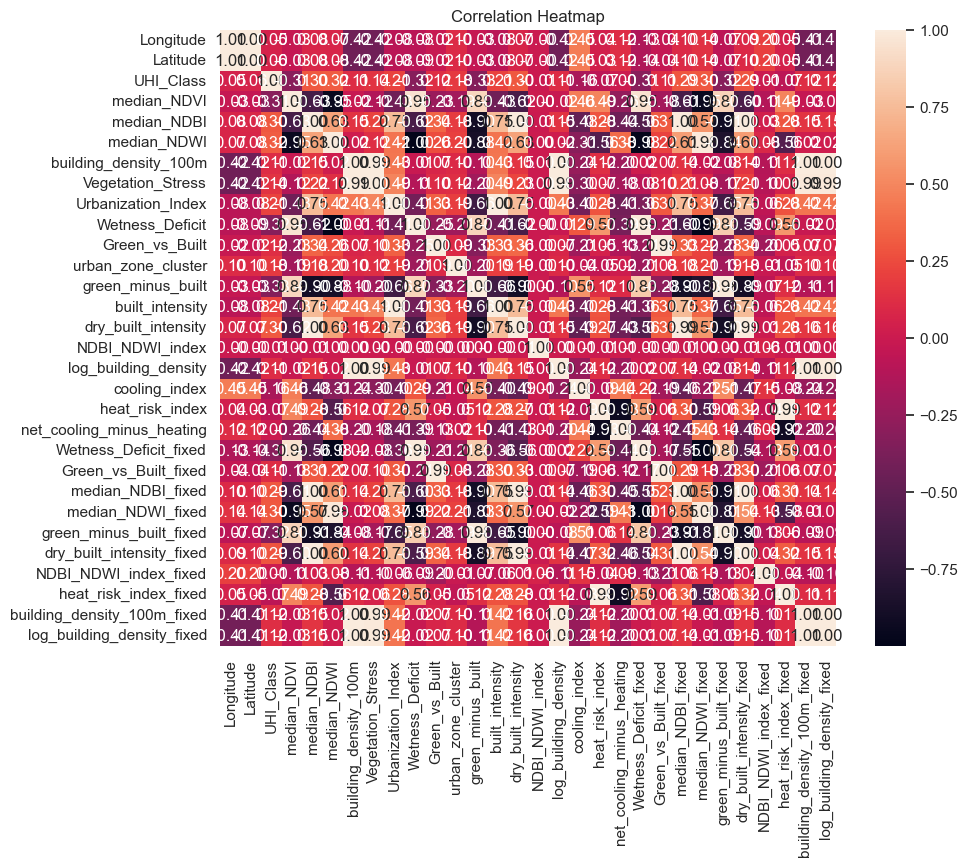

In [163]:
# compute correlation matrix
corr_matrix = uhi_data.corr(numeric_only=True)

# plot heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix,
            annot=True,
            fmt=".2f",
            square=True)
plt.title("Correlation Heatmap")
plt.show()


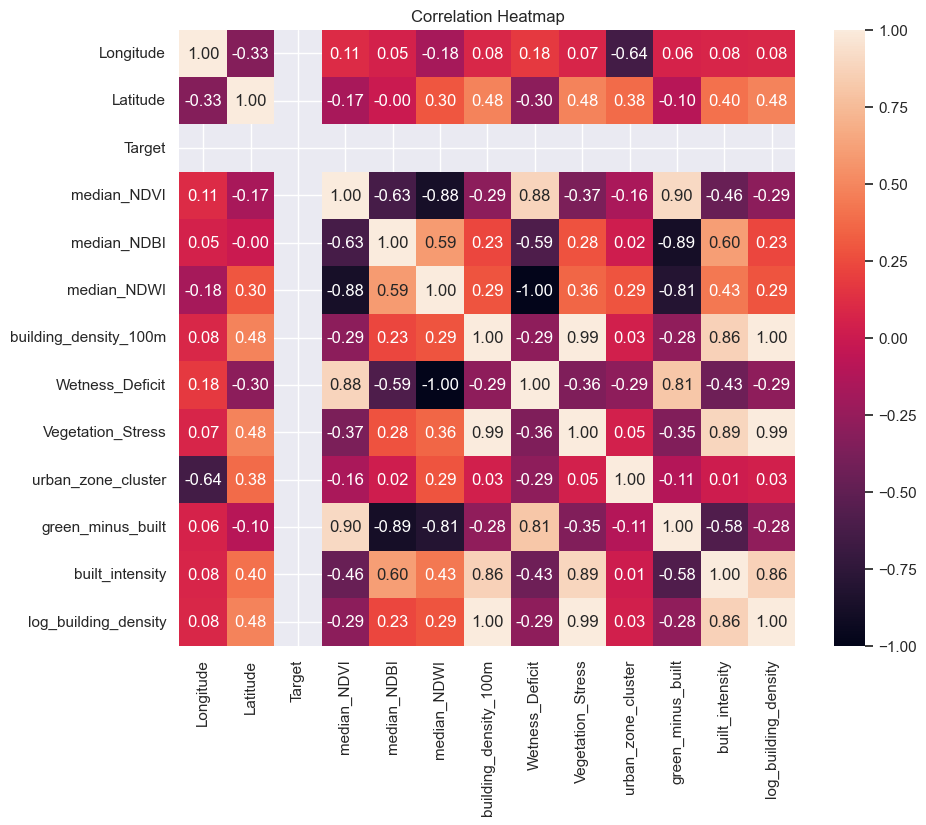

In [164]:
# compute correlation matrix for Test
corr_matrix = test_data.corr(numeric_only=True)

# plot heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix,
            annot=True,
            fmt=".2f",
            square=True)
plt.title("Correlation Heatmap")
plt.show()

In [165]:
uhi_data.head()

Longitude   Latitude  UHI_Class  median_NDVI  median_NDBI  median_NDWI  \
0 -70.580508 -33.586980          0     0.508786     0.052612    -0.177526   
1 -70.579480 -33.592099          0     0.777169     0.008264    -0.198858   
2 -70.578366 -33.597419          1    -0.981618     0.055125    -0.063500   
3 -70.566661 -33.597109          0     0.529442     0.025901    -0.192771   
4 -70.566296 -33.597079          1    -1.279927     0.003715    -0.072275   

   building_density_100m  Vegetation_Stress  Urbanization_Index  \
0              -0.043795          -0.076075            0.030014   
1              -0.841281          -0.871972           -0.350159   
2              -1.165595          -1.115342           -0.288738   
3               1.097849           1.044536            0.100407   
4               0.849280           1.004127           -0.317246   

   Wetness_Deficit  ...  Wetness_Deficit_fixed  Green_vs_Built_fixed  \
0         0.163416  ...               0.397533              0.722211   
1         0.181370  ...               0.595797              2.169501   
2         0.061565  ...              -0.974613              0.090290   
3         0.176279  ...               0.540713              1.656069   
4         0.069782  ...              -0.845705              1.578668   

   median_NDBI_fixed  median_NDWI_fixed  green_minus_built_fixed  \
0           0.140906          -0.398071                 0.251596   
1          -0.377557          -0.610089                 0.651810   
2           0.171108           0.993272                -0.559501   
3          -0.174638          -0.550899                 0.411595   
4          -0.429200           0.868026                -0.301535   

   dry_built_intensity_fixed  NDBI_NDWI_index_fixed  heat_risk_index_fixed  \
0                   0.175090              -0.615986               0.442508   
1                  -0.363434              -0.189347               0.134573   
2                   0.139377              -1.814832              -0.942122   
3                  -0.151466              -0.341023               0.287841   
4                  -0.422016              -0.206331              -1.404540   

   building_density_100m_fixed  log_building_density_fixed  
0                     0.043580                    0.043608  
1                    -0.832806                   -0.832771  
2                    -1.219495                   -1.219499  
3                     1.090300                    1.090251  
4                     0.877624                    0.877591  

[5 rows x 30 columns]

In [166]:
test_data.head()

Longitude  Latitude  Target  median_NDVI  median_NDBI  median_NDWI  \
0 -13.272932  8.447807     NaN    -1.293429     0.159763    -0.111930   
1 -13.272938  8.447757     NaN    -1.293429     0.159763    -0.111930   
2 -13.272997  8.447133     NaN     1.093889     0.088703    -0.234831   
3 -13.273002  8.447015     NaN     0.703475     0.053067    -0.191596   
4 -13.273007  8.446915     NaN     0.421062     0.083048    -0.215661   

   building_density_100m  Wetness_Deficit  Vegetation_Stress  \
0               0.001499         1.111930           0.001464   
1               0.001399         1.111930           0.001367   
2               0.001000         1.234831           0.000844   
3               0.001099         1.191596           0.000966   
4               0.001099         1.215661           0.000988   

  Urbanization_Index Green_vs_Built  urban_zone_cluster  green_minus_built  \
0          -0.006997       0.450545                 3.0          -1.290826   
1          -0.134406       2.839267                 3.0          -1.290826   
2          -0.103392       2.817812                 3.0           0.963335   
3           0.058259       4.668261                 3.0           0.972825   
4           0.070531       6.452356                 3.0           0.596046   

   built_intensity dry_built_intensity NDBI_NDWI_index  log_building_density  \
0         0.000636            0.177646        5.240791              0.001498   
1         0.000620            0.177646        5.240791              0.001398   
2         0.000485            0.109533       -2.214056              0.000999   
3         0.000454            0.063234       -1.766158              0.001099   
4         0.000487            0.100958         -2.2525              0.001099   

  cooling_index heat_risk_index net_cooling_minus_heating  
0     -0.089645        1.264696                 -1.354342  
1     -0.089548        1.137287                 -1.226835  
2     -0.080062        1.220142                 -1.300204  
3     -0.071184        1.302921                 -1.374105  
4      -0.11512        1.369239                  -1.48436

In [167]:
test_data.drop(["Target"],axis =1, inplace = True)

In [168]:
# Extracting specific columns (NDVI, NDBI, NDWI, building_density_100m) from the validation dataset
test=test_data.loc[:,["median_NDVI","median_NDBI","median_NDWI","building_density_100m","Wetness_Deficit","Vegetation_Stress","Urbanization_Index",	"Green_vs_Built","urban_zone_cluster","green_minus_built","built_intensity","dry_built_intensity","NDBI_NDWI_index","log_building_density",	"cooling_index","heat_risk_index","net_cooling_minus_heating"]]
test.head()

median_NDVI  median_NDBI  median_NDWI  building_density_100m  \
0    -1.293429     0.159763    -0.111930               0.001499   
1    -1.293429     0.159763    -0.111930               0.001399   
2     1.093889     0.088703    -0.234831               0.001000   
3     0.703475     0.053067    -0.191596               0.001099   
4     0.421062     0.083048    -0.215661               0.001099   

   Wetness_Deficit  Vegetation_Stress Urbanization_Index Green_vs_Built  \
0         1.111930           0.001464          -0.006997       0.450545   
1         1.111930           0.001367          -0.134406       2.839267   
2         1.234831           0.000844          -0.103392       2.817812   
3         1.191596           0.000966           0.058259       4.668261   
4         1.215661           0.000988           0.070531       6.452356   

   urban_zone_cluster  green_minus_built  built_intensity dry_built_intensity  \
0                 3.0          -1.290826         0.000636            0.177646   
1                 3.0          -1.290826         0.000620            0.177646   
2                 3.0           0.963335         0.000485            0.109533   
3                 3.0           0.972825         0.000454            0.063234   
4                 3.0           0.596046         0.000487            0.100958   

  NDBI_NDWI_index  log_building_density cooling_index heat_risk_index  \
0        5.240791              0.001498     -0.089645        1.264696   
1        5.240791              0.001398     -0.089548        1.137287   
2       -2.214056              0.000999     -0.080062        1.220142   
3       -1.766158              0.001099     -0.071184        1.302921   
4         -2.2525              0.001099      -0.11512        1.369239   

  net_cooling_minus_heating  
0                 -1.354342  
1                 -1.226835  
2                 -1.300204  
3                 -1.374105  
4                  -1.48436

In [169]:
# Extracting specific columns (NDVI, NDBI, NDWI, building_density_100m) from the validation dataset
train=uhi_data.loc[:,["UHI_Class","median_NDVI","median_NDBI","median_NDWI","building_density_100m","Wetness_Deficit","Vegetation_Stress","Urbanization_Index",	"Green_vs_Built","urban_zone_cluster","green_minus_built","built_intensity","dry_built_intensity","NDBI_NDWI_index","log_building_density",	"cooling_index","heat_risk_index","net_cooling_minus_heating"]]
test.head()

median_NDVI  median_NDBI  median_NDWI  building_density_100m  \
0    -1.293429     0.159763    -0.111930               0.001499   
1    -1.293429     0.159763    -0.111930               0.001399   
2     1.093889     0.088703    -0.234831               0.001000   
3     0.703475     0.053067    -0.191596               0.001099   
4     0.421062     0.083048    -0.215661               0.001099   

   Wetness_Deficit  Vegetation_Stress Urbanization_Index Green_vs_Built  \
0         1.111930           0.001464          -0.006997       0.450545   
1         1.111930           0.001367          -0.134406       2.839267   
2         1.234831           0.000844          -0.103392       2.817812   
3         1.191596           0.000966           0.058259       4.668261   
4         1.215661           0.000988           0.070531       6.452356   

   urban_zone_cluster  green_minus_built  built_intensity dry_built_intensity  \
0                 3.0          -1.290826         0.000636            0.177646   
1                 3.0          -1.290826         0.000620            0.177646   
2                 3.0           0.963335         0.000485            0.109533   
3                 3.0           0.972825         0.000454            0.063234   
4                 3.0           0.596046         0.000487            0.100958   

  NDBI_NDWI_index  log_building_density cooling_index heat_risk_index  \
0        5.240791              0.001498     -0.089645        1.264696   
1        5.240791              0.001398     -0.089548        1.137287   
2       -2.214056              0.000999     -0.080062        1.220142   
3       -1.766158              0.001099     -0.071184        1.302921   
4         -2.2525              0.001099      -0.11512        1.369239   

  net_cooling_minus_heating  
0                 -1.354342  
1                 -1.226835  
2                 -1.300204  
3                 -1.374105  
4                  -1.48436

In [170]:
# Split the data into features (X) and target (y), and then into training and testing sets
X = train.drop(columns=['UHI_Class']).values
y = train ['UHI_Class'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

In [171]:
# Scale the training and test data using standardscaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [172]:
from imblearn.over_sampling import SMOTE
sm = SMOTE()
X_res, y_res = sm.fit_resample(X_train, y_train)


In [173]:
#checking the shape of the train and test set 
print(f"the shape of X_train:{X_train.shape}")
print(f"the shape of X_test:{X_test.shape}")
print(f"the shape of y_train:{y_train.shape}")
print(f"the shape of y_test:{y_train.shape}")

the shape of X_train:(33690, 17)
the shape of X_test:(11231, 17)
the shape of y_train:(33690,)
the shape of y_test:(33690,)


In [174]:
# importation of models

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import  XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesRegressor


In [175]:
from sklearn.metrics import f1_score
RF = RandomForestClassifier(random_state=42, class_weight="balanced")
RF.fit(X_train, y_train)
y_pred_RF = RF.predict(X_test)

f1_RF = f1_score(y_test, y_pred_RF, average='macro')
print("Random Forest F1:", f1_RF)

Random Forest F1: 0.629231373710348


In [176]:
from lightgbm import LGBMClassifier

LGM = LGBMClassifier(random_state=42,class_weight="balanced")
LGM.fit(X_train, y_train)
y_pred_LGM = LGM.predict(X_test)

f1_LGM = f1_score(y_test, y_pred_LGM, average='macro')
print("LightGBM F1:", f1_LGM)



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001685 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3670
[LightGBM] [Info] Number of data points in the train set: 33690, number of used features: 17
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
LightGBM F1: 0.6466438956976672


In [177]:
SVM = SVC(class_weight="balanced")
SVM.fit(X_train, y_train)
y_pred_SVM = SVM.predict(X_test)

f1_SVM = f1_score(y_test, y_pred_SVM, average='macro')
print("SVM F1:", f1_SVM)


SVM F1: 0.6023028584628195


In [178]:
XGB = XGBClassifier(random_state=42,class_weight="balanced")
XGB.fit(X_train, y_train)
y_pred_XGB = XGB.predict(X_test)

f1_XGB = f1_score(y_test, y_pred_XGB, average='macro')
print("XGBoost F1:", f1_XGB)

XGBoost F1: 0.6410623524677478


In [179]:
ADA = AdaBoostClassifier(random_state=42)
ADA.fit(X_train, y_train)
y_pred_ADA = ADA.predict(X_test)

f1_ADA = f1_score(y_test, y_pred_ADA, average='macro')
print("AdaBoost F1:", f1_ADA)

AdaBoost F1: 0.6227961416142015


In [180]:
from sklearn.neighbors import KNeighborsClassifier

KNN = KNeighborsClassifier(leaf_size =5,p=1,weights="distance",n_jobs=-1,algorithm= 'brute')
KNN.fit(X_train, y_train)
y_pred_KNN = KNN.predict(X_test)

f1_KNN = f1_score(y_test, y_pred_KNN, average='macro')
print("KNN F1:", f1_KNN)


KNN F1: 0.5767753321908273


In [181]:
# Make predictions on the training data
insample_predictions = LGM.predict(X_train)

In [182]:
# calculate accuracy and classification report for in-sample predictions
Y_train = y_train.tolist()
accuracy = accuracy_score(Y_train, insample_predictions)
print(f'Accuracy: {accuracy}')
print(classification_report(Y_train, insample_predictions))

Accuracy: 0.6846838824577026
              precision    recall  f1-score   support

           0       0.71      0.70      0.70     10580
           1       0.61      0.64      0.62     11257
           2       0.74      0.72      0.73     11853

    accuracy                           0.68     33690
   macro avg       0.69      0.68      0.69     33690
weighted avg       0.69      0.68      0.69     33690



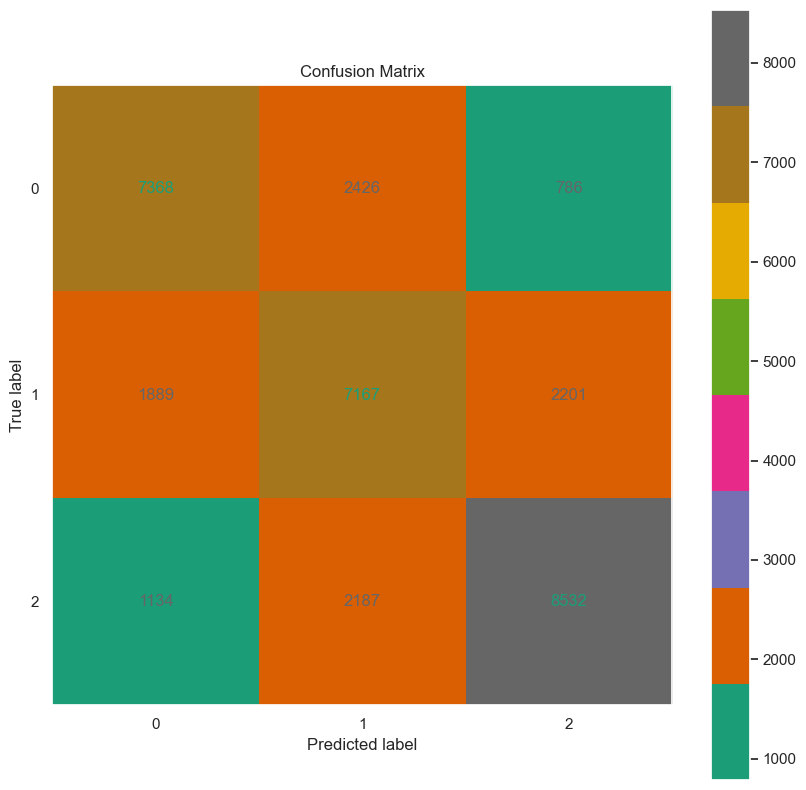

In [183]:
train_labels = np.unique(y_train)
cm = confusion_matrix(y_train, insample_predictions, labels=train_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_labels)
disp.plot(cmap='Dark2')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()

In [184]:
# Make predictions on the test data
outsample_predictions = LGM.predict(X_test)

In [185]:
# calculate accuracy and classification report for in-sample predictions
Y_test = y_test.tolist()
accuracy = accuracy_score(Y_test, outsample_predictions)
print(f'Accuracy: {accuracy}')
print(classification_report(Y_test, outsample_predictions))

Accuracy: 0.6466031519900276
              precision    recall  f1-score   support

           0       0.68      0.67      0.67      3527
           1       0.57      0.58      0.58      3753
           2       0.69      0.69      0.69      3951

    accuracy                           0.65     11231
   macro avg       0.65      0.65      0.65     11231
weighted avg       0.65      0.65      0.65     11231



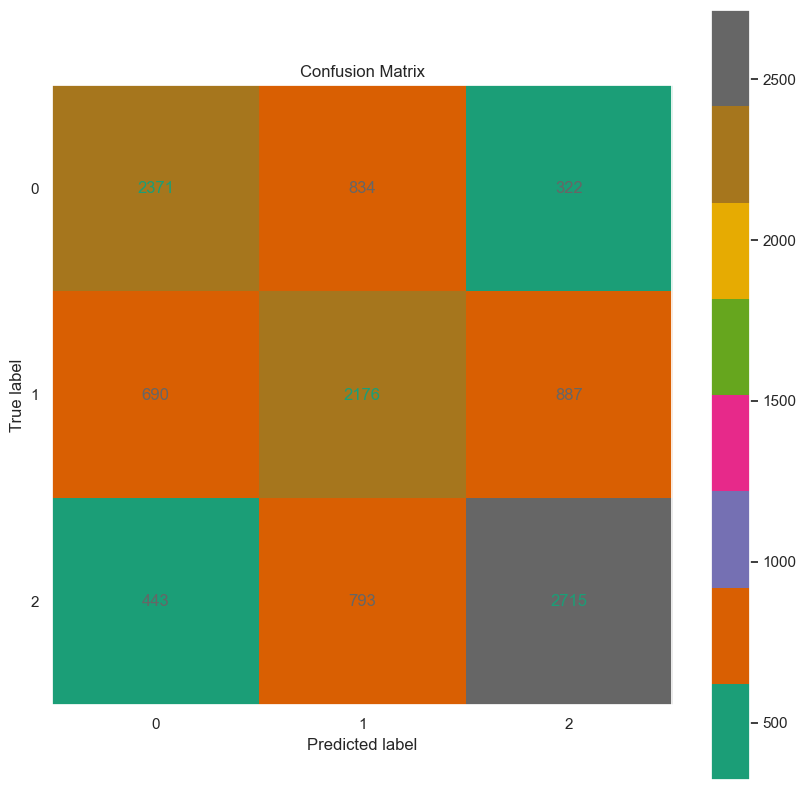

Accuracy: 0.6466


In [186]:
# Compute the confusion matrix to evaluate the classification performance.
test_labels=np.unique(y_test)
cm = confusion_matrix(Y_test, outsample_predictions, labels=test_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_labels)
disp.plot(cmap="Dark2")
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()

# Optional: Print accuracy
print(f"Accuracy: {accuracy_score(Y_test, outsample_predictions):.4f}")

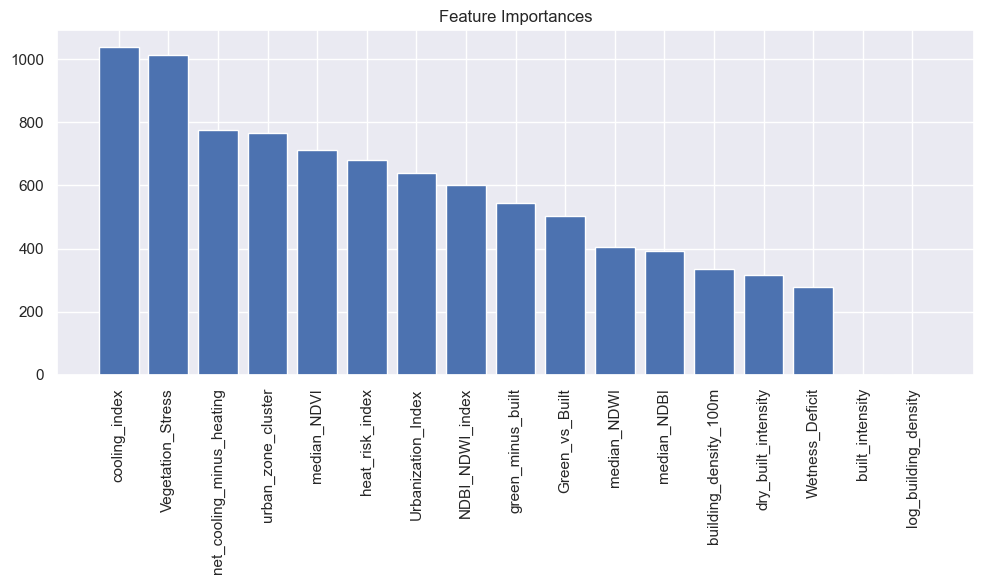

In [187]:
# Extract feature importance scores from the trained random forest model.
importances = LGM.feature_importances_

# Prepare feature names from the training dataset (excluding target column).
data = train.drop(columns=['UHI_Class'])
feature_names = data.columns

# Sort features by importance in descending order.
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")

# Create a bar plot to visualize the importance of each feature.
plt.bar(range(len(importances)), importances[indices], align='center')

# Set plot title and configure x-axis ticks with feature names rotated for readability.
plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()

In [188]:
from sklearn.metrics import make_scorer
f1_scorer = {
    'f1': make_scorer(f1_score, average='macro')
}
from sklearn.metrics import make_scorer
def stratified_f1_cv(models, X, y, cv, scorer):
    results = {}

    for model_name, model in models.items():
        print(f"Evaluating model: {model_name}")

        cv_results = cross_validate(
            model,
            X,
            y,
            cv=cv,
            scoring=scorer,
            return_train_score=False
        )

        results[model_name] = {
            'f1_score': np.mean(cv_results['test_f1'])
        }

    return pd.DataFrame(results).T


In [189]:
models = {
    'Rf': RandomForestClassifier(random_state=42),
    'SVm': SVC(kernel='rbf'),
    'KNn': KNeighborsClassifier(),
    'DT': DecisionTreeClassifier(random_state=42),
    'ADa': AdaBoostClassifier(random_state=42),
    'LGMI': LGBMClassifier(random_state=42)}


In [190]:
from sklearn.model_selection import StratifiedKFold, cross_validate
skf = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

f1_results_df = stratified_f1_cv(
    models,
    X_train,
    y_train,
    skf,
    f1_scorer
)

Evaluating model: Rf
Evaluating model: SVm
Evaluating model: KNn
Evaluating model: DT
Evaluating model: ADa
Evaluating model: LGMI
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3668
[LightGBM] [Info] Number of data points in the train set: 26952, number of used features: 17
[LightGBM] [Info] Start training from score -1.158236
[LightGBM] [Info] Start training from score -1.096278
[LightGBM] [Info] Start training from score -1.044557
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002488 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3670
[LightGBM] [Info] Number of data points in the train set: 26952, number of used features: 17
[LightGBM] [Info] Start training from score -1.158236
[LightGBM] [Info] Start training from score -1.096278
[LightGBM] [Info] Sta

In [191]:
print("\nStratified Cross-Validation (F1 score only):")
print(f1_results_df)


Stratified Cross-Validation (F1 score only):
      f1_score
Rf    0.617868
SVm   0.593818
KNn   0.580191
DT    0.537779
ADa   0.612700
LGMI  0.638764


In [192]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, f1_score
f1_scorer = make_scorer(f1_score, average='macro')

skf = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

models_and_params = {

    'RF(hyperparameter)': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
    },

    'LightGBM(hyperparameter)': {
        'model': LGBMClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'num_leaves': [31, 50],
            'max_depth': [-1, 10]
        }
    },

    'XGB(hyperparameter)': {
        'model': XGBClassifier(
            random_state=42,
            use_label_encoder=False,
            eval_metric='logloss'
        ),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 6],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0]
        }
    },

    'ADA(hyperparameter)': {
        'model': AdaBoostClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 1.0]
        }
    },

    'SVM(hyperparameter)': {
        'model': SVC(),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto']
        }
    },

    'KNN(hyperparameter)': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7, 9],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        }
    }
}



In [193]:
def stratified_f1_hyperparameter_tuning(models_and_params, X, y, cv, scorer):
    results = []

    for model_name, config in models_and_params.items():
        print(f"Tuning model: {model_name}")

        grid = GridSearchCV(
            estimator=config['model'],
            param_grid=config['params'],
            scoring=scorer,
            cv=cv,
            n_jobs=-1
        )

        grid.fit(X, y)

        results.append({
            'Model': model_name,
            'Best_F1': grid.best_score_,
            'Best_Params': grid.best_params_
        })

    return pd.DataFrame(results)


In [194]:
tuning_results = stratified_f1_hyperparameter_tuning(
    models_and_params,
    X_train,
    y_train,
    skf,
    f1_scorer
)

Tuning model: RF(hyperparameter)
Tuning model: LightGBM(hyperparameter)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004692 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3670
[LightGBM] [Info] Number of data points in the train set: 33690, number of used features: 17
[LightGBM] [Info] Start training from score -1.158236
[LightGBM] [Info] Start training from score -1.096211
[LightGBM] [Info] Start training from score -1.044620
Tuning model: XGB(hyperparameter)
Tuning model: ADA(hyperparameter)
Tuning model: SVM(hyperparameter)
Tuning model: KNN(hyperparameter)


In [195]:
print("\nHyperparameter Tuning Results (F1 score only):")
print(tuning_results)


Hyperparameter Tuning Results (F1 score only):
                      Model   Best_F1  \
0        RF(hyperparameter)  0.637043   
1  LightGBM(hyperparameter)  0.639226   
2       XGB(hyperparameter)  0.638441   
3       ADA(hyperparameter)  0.614877   
4       SVM(hyperparameter)  0.613868   
5       KNN(hyperparameter)  0.595862   

                                         Best_Params  
0  {'max_depth': 10, 'min_samples_leaf': 1, 'min_...  
1  {'learning_rate': 0.1, 'max_depth': -1, 'n_est...  
2  {'colsample_bytree': 1.0, 'learning_rate': 0.1...  
3        {'learning_rate': 1.0, 'n_estimators': 200}  
4        {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}  
5  {'metric': 'euclidean', 'n_neighbors': 9, 'wei...  


In [196]:
# Feature Scaling 
test_transformed = sc.transform(test)
test_transformed

array([[ -1.30020746,   1.44040449,   0.43603404, ...,  -2.25150684,
          0.9554043 , -29.51777496],
       [ -1.30020746,   1.44040449,   0.43603404, ...,  -2.24830677,
         -0.73807184, -27.29302851],
       [  1.09813727,   0.60790964,  -0.87161047, ...,  -1.93737031,
          0.36320466, -28.57317585],
       ...,
       [  0.57798542,   0.69221156,  -1.24368502, ...,  -4.57814096,
          1.93687013, -32.04460641],
       [  1.32993255,   0.60084706,  -1.15517829, ...,  -2.03898783,
          2.2858198 , -31.1511023 ],
       [  0.39132205,   0.90129864,  -0.8327839 , ...,  -3.6512208 ,
          1.95559851, -31.57579809]])

In [197]:
#Making predictions
final_predictions = LGM.predict(test_transformed)

# Optional: convert to Series if needed
final_prediction_series = pd.Series(final_predictions)

In [202]:
#Combining the results into dataframe
submission_df = pd.DataFrame({'ID':test_file['ID'].values, 'Target':final_prediction_series.values})

In [203]:
#Displaying the sample submission dataframe
display(submission_df)

ID  Target
0          ID_1       2
1          ID_2       2
2          ID_3       2
3          ID_4       2
4          ID_5       2
...         ...     ...
14100  ID_14101       2
14101  ID_14102       1
14102  ID_14103       1
14103  ID_14104       1
14104  ID_14105       0

[14105 rows x 2 columns]

In [204]:
# Replace text labels with numeric values
mapping = {
    0: "Low",
    1: "Medium",
    2: "High"
}

submission_df["Target"] = submission_df["Target"].replace(mapping)


In [205]:
display(submission_df)

ID  Target
0          ID_1    High
1          ID_2    High
2          ID_3    High
3          ID_4    High
4          ID_5    High
...         ...     ...
14100  ID_14101    High
14101  ID_14102  Medium
14102  ID_14103  Medium
14103  ID_14104  Medium
14104  ID_14105     Low

[14105 rows x 2 columns]

In [206]:
#Dumping the predictions into a csv file.
submission_df.to_csv("./Predicted_Dataset.csv",index=False)